In [66]:
"""
Created on Mon Sep 16 11:35:32 2024

@author: Vera
"""
# %% python -m cProfile myscript.py # Run this in the terminal to get timings for different function calls

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mplcolors 
import time
import pickle
from scipy.optimize import fsolve
from scipy.optimize import root
from scipy.optimize import broyden1
from scipy.optimize import differential_evolution
from scipy.optimize import newton
from scipy.optimize import bisect
from scipy.linalg import eig
from scipy.linalg import inv

# CHOICES
figuresaving = True
teststartingvolatiles=True
PH2Opaper = ['Luo'][0] # Luo2024 
PCpaper = ['Fischer', 'Blanchard','Johansen', 'Tsutsumi'][1] # Fischer2020 or Blanchard2022 or AnatomyIII or Tsutsumi2025
PNpaper = ['Grewal', 'Huang','Johansen'][1] # Grewal2019 or Huang2024 or AnatomyIII
constantdeltaIW = False # should oxygen fugacity stay the same as the planet grows?
homogeneousdeltaIW = True # should deltaIW be the same at the surface and throughout the entire magma ocean?
saturation = False # should volatile saturation in metal droplets be accounted for
planetesimalaccretion = False # not working yet. fsolve finds bad solutions
latevolatileaccretion = True or planetesimalaccretion # if planetesimalaccretion then latevolatileaccretion too
cappedtemperature = True
constanttemperature = True
continuefromrun = False # are you continuing from an earlier run?
nosedifrac = 0 # 1e-2 # for how big fraction of the total time should sedimentation be halted. CHOICE 0 to 1. 
timechoice = False # should settime be the CHOICE
masschoice = True # or should Mfinal be the CHOICE
bothchoice = timechoice == masschoice # If timechoice == masschoice then both are CHOICES. (Both being False also works here.)
constantpebblerate = False # decide if the planet mass should grow linearly or exponentially
evendist = True  # decide initial distribution of volatiles to have a constant mass concentration throughout magma ocean
# decide initial distribution of volatiles to be concentrated in the layer closest to the core
innerdelta = not evendist
growthbool = True # decide if the planet should grow (met. and sil. accretion)
constantdensity = False  # decide to use the uncompressed silicate density throughout

number_of_boundaries = 50 # spatial discretization of volatile transport CHOICE
number_of_layers = number_of_boundaries-1
# cspread = 0.1  # Alt. 0. Allow 10 sigma inaccuracy. can't have too much spread if diffusion only transports to nearest layer
cspread = 0.25 # Alt. 1. Allow 4 sigma inaccuracy.
plotstepspacing = 1  # Every n timesteps plots are printed
# plot at most ___ plots. Redefines plotstepspacing if necessary
max_number_of_plots = 300 # CHOICE, 400 seems to be just too big for the cluster job memory limit? slurmstepd: error: StepId=49244262.batch exceeded memory limit (6679385088 > 6287261696), being killed
max_len_savefiles = 10*max_number_of_plots # CHOICE

number_of_structure_boundaries = int(1e4)
number_of_structure_iterations = 10
structureplotstepspacing = 1  # number_of_structure_timesteps
restructuringspacing = 20

#gasspacing = 1
gasspacing = restructuringspacing//2 

timecheckspacing = 100 # how often to check time elapsed

if constanttemperature:
    Tconst = 3000 # K, CHOICE.
M0 = 1e-4 # mass at which mass first starts accreting pebbles (units = Earth masses). 1e-2 I read somewhere(?), 1e-4 from Anders or maybe 1e-6 from Claudia. 
formationtime = 5e6 # time [yr] needed to form one Earth mass planet

startingmass = 0.02 # how many earth masses to start with
stoppingmass = 0.64 # after how many earth masses do we stop accretion. 0.64 (error: +0.12, -0.14) from HaiyangWang2025 pre-published best guess. 0.6 carry-over from AnatomyIII 
settime = 5e5 # years of accretion to simulate

if not bothchoice:
    if masschoice: # Let the final mass decide how many years of accretion to simulate
        settime = formationtime*np.log(stoppingmass/startingmass)/np.log(1/M0)
    elif timechoice: # Let the years of accretion to simulate decide what the stopping mass should be
        stoppingmass = startingmass*np.exp(settime/formationtime*np.log(1/M0))
print(str(sys.argv[0])+'. Starting mass: '+str(startingmass)+'. M0: '+"{:.2e}".format(M0)+'. Mfinal: '+str(stoppingmass)+'. Tfinal: '+"{:.2e}".format(settime)+'. Nosedifrac: '+"{:.2e}".format(nosedifrac))

# -------------------------------General functions-----------------------------
def delta(array): # calculates the forward difference to the next element in array. returns array with one less element than input array
    return array[1:]-array[:-1]

# calculates the mean value between subsequent elements in array. returns array with one less element than input array
def centeraveraging(array):
    return (array[1:]+array[:-1])/2

# initializing
volatiles = np.array(['hydrogen', 'carbon', 'nitrogen'])
volatilesshort = np.array(['H', 'C', 'N'])
gasvolatiles = np.array(['H'+r'$_2$'+'O', 'CO'+r'$_2$', 'N'+r'$_2$'])
extragasvolatiles = np.array(['H'+r'$_2$', 'CO']) # alternate (reduced) speciation of gaseous volatile-bearing species
fullgasvolatiles = np.concatenate((gasvolatiles, extragasvolatiles))
vcolors = np.array(['c', 'r', 'g'])
fullvcolors = np.concatenate((vcolors, vcolors[:-1]))
irange = range(len(volatiles))
Ppaperlabel = [' - '+PH2Opaper,' - '+PCpaper, ' - '+PNpaper] # label figures with the part. coef. used
# volatiles = np.array(['hydrogen', 'carbon', 'nitrogen', 'oxygen'])
# vcolors = np.array(['c', 'r', 'g', 'b'])
# irange = range(len(volatiles))

print('Partition coefficient papers: ', Ppaperlabel) # print which papers we use for the partition coefficients
print('Late volatile accretion: ', latevolatileaccretion)
print('Saturation adjustment: ', saturation)


pi = np.pi
sqrtpi = np.sqrt(np.pi)
sqrt2 = np.sqrt(2)

# conversions
GPaconversion = 1.0041778e-15  # conversion to GPa from Pg, km, year units
densityconversion = 1e3  # converts from Pg km-3 to kg m-3
secondsperyear = 31556926  # 31 556 926 seconds per year
Cpconv = 995839577 # converts specific heat capacity from units of J kg-1 K-1 to km2 yr-2 K-1
GPatobar = 1e4 # converts from GPa to bar
GPatokbar = GPatobar/1e3 # converts from GPa to kbar

# units: years, km, Pg (Petagram)
G = 66465320.9  # gravitational constant, km3 Pg-1 yr-2
sigmaBoltzmann = 1781.83355 # Boltzmann constant sigma = 5.67*1e-8 W/m^2 K^-4 converted to Petagram year^-3 K^-4
kB = 1.37490492e-26 # kB Boltzmann constant = 1.37490492e-23 J/K in Pg km2 yr-2 K-1

vmet = 1*1e-3*secondsperyear  # 1 m/s in km yr-1, falling speed of metal blobs
silicatedensity = 3.4 # Pg km-3 (equiv. to g cm-3 )
coremetaldensity = 10.48
earthmass = 5.9712e12  # Earth's mass in Pg
venusmass = 4.86732e12 # Venus' mass in Pg
mproton = 1.67262192e-39 # proton mass in Pg

Lsun = 1.20862995e31 # solar luminosity. 3.84600e26 J/s in Pg km2 yr-3
AU = 149597871 # 1 AU in km  
a0 = 1.6*AU # CHOICE of starting point. 
a = np.copy(a0) # PLACEHOLDER. Use proper a(M(t)) growth track. 

# Calculate initial pebble mass accretion rate
if constantpebblerate:
    pebblerate0 = 1*earthmass/formationtime # Pg yr-1, PLACEHOLDER VALUE, x order(s) of magnitude less than what is required to form a 1 Earth mass planet over 5 Myr.
else:
    tau = formationtime/np.log(1/M0)
    pebblerate0 = startingmass*earthmass/tau # Pg yr-1

pebblemetalfrac = 0.3  # mass fraction of metal (iron) in accreted pebbles. Mass fraction here means met/(met+sil) PLACEHOLDER
coremassfraction = pebblemetalfrac # consistent with formation
# coreradiusfraction = 1/(1+coremetaldensity/silicatedensity*(1/coremassfraction-1))**(1/3) # 3480/6371 in Earth's Core chapter by David Loper. PLACEHOLDER

# Set planet mass, initial uncompressed radius is determined from CHOICE of planet mass
protomass = startingmass*earthmass
mc0 = coremassfraction*protomass # fraction of the total protoplanetary mass that is composed of the core
rcore0 = (3*mc0/(4*pi*coremetaldensity))**(1/3)
rsurf0 = ((protomass-mc0)/(4*pi*silicatedensity/3)+rcore0**3)**(1/3) # km, initial planet radius

# compression and expansion values
alpha0 = 3e-5  # volumetric thermal expansion coefficient, K-1
heatconductivity = 4*31425635.8 # base heat conductivity in AnatomyI, 4 W m-1 K-1 in Pg km year-3 K-1
K0 = 200  # bulk modulus, GPa
K0prime = 4  # bulk modulus derivative w.r.t pressure
# silicate melt heat capacity at constant pressure (1200 J kg-1 K-1), km2 yr-2 K-1
Cpsil = Cpconv*1200
gsurf0 = G*protomass/rsurf0**2  # gravity at surface

# atmosphere
Mearthatm = 5.15e6  # Pg, current mass of Earth's atmosphere
Mvenusatm = 4.8e8 # Pg
atmexponent = 0 # PLACEHOLDER CHOICE. what exponent in scaling law for guess of initial atmosphere
Matmlow = Mearthatm*(protomass/earthmass)**atmexponent # Pg, mass of the atmosphere of the protoplanet modelled
Matmhigh = Mvenusatm*(protomass/venusmass)**atmexponent
Matmguess = Matmhigh # CHOICE, should it be? 
opacitypho = 1e-3*1e6  # (gray) Rosseland mean opacity from Badescu2010. 1e6 factor for conversion from m^2 kg^-1 to km^2 Pg^-1, PLACEHOLDER
def opacityfunc(p, T): # scaling from Rogers2024. pressure input in GPa
    pinbar = p*GPatobar
    alpha, beta = 0.68, 0.45
    kappa = 1.29e-2*1e6*(pinbar/1)**alpha*(1/1000)**beta # 1e5 factor for conversion from cm^2 g^-1 to km^2 Pg^-1    
    return kappa

monoatomicgamma = 5/3 # 1.666666
diatomicgamma = 7/5 # 1.4
triatomicgamma = 8/6 # 1.3333
lowgamma = 1.25 # higher temperatures --> lower Cp, lower Cp/Cv. 
envgamma = triatomicgamma # CHOICE. adiabatic gamma from the top of the outgassed atmosphere (bottom of the envelope) up to the RCB. 

# molar masses of main volatile gas species
amuH2O = 18 
amuCO2 = 44 
amuN2 = 28 
amui = np.array([amuH2O, amuCO2, amuN2])

# molar masses of reduced volatile gas species
amuH2 = 2
amuCO = 28
amuiextra = np.array([amuH2, amuCO]) 

amuifull = np.concatenate((amui, amuiextra))

# molar masses of the atoms
amuC = 12
amuN = 14

# molar masses of melt species
amuOH = 17
amuCO3 = 60
amuNH = 15
amuNH2 = 16
amuNH3 = 17


def molefraction(w, amu): # calculates the mole fraction of each species using the weight fraction (or mass) and atomic mass of each species
    return np.array([(w[i]/amu[i])/(np.sum(w/amu)) for i in range(len(w))])

def weightfraction(x, amu): # calculates the weight fraction of each species using the mole fraction and atomic mass of each species
    return np.array([(x[i]*amu[i])/(np.sum(x*amu)) for i in range(len(x))])

# melt properties. LEGACY EXCEPT FOR NBOperT and deltaIW?
deltaIW = -2 # log scale of difference from oxygen fugacity produced by IW buffer at surface pT.
deltaIWmagmaocean = deltaIW # log scale of difference from oxygen fugacity produced by IW buffer in magma ocean. 
            
    
melt = 'enstatite'
NBOperT = 2 # CHOICE
if melt=='enstatite': # MgSiO3 simplified. Same resulting product if considering Mg2Si2O6 instead since amuMelt is doubled and Siperformula becomes is halved. 
    amuMelt = 100 
    Tperformula = 1 # one Mg in MgSiO3
    NBOperO = NBOperT/3 # three O per one Mg
else: # forsterite, Mg2SiO4
    amuMelt = 140
    Tperformula = 2 # two Mg in MgSiO3PLACEHOLDER
    NBOperO = NBOperT/2 # four O per two Mg

# number of volatile-bearing products per volatile reactant
alphaH2O = 2 # H2O(gas) + O(melt) = 2 OH(melt) e.g. Stolper1982. 
alphaCO2 = 1 # CO2(gas) + O(melt) = CO3(melt) e.g. Ortenzi2020, Fegley2020. Or more accurately M2SiO4(melt)+CO2(g) = MCO3(melt) + MSiO3(melt) e.g. Spera1980. 
alphaN2chem = 2 # N2(gas)+_*H2O(gas)+(3-_)*O(melt) = 2 NH_ + 3/2 O(gas) e.g. Grewal2020.
alphaN2phys = 1 # N2(gas) = N2(melt)  
# alphai = np.array([alphaH2O, alphaCO2, alphaN2]) 
alphai = np.array([[alphaH2O, 1],[alphaCO2, 1],[alphaN2chem, alphaN2phys]]) # 1 for dummy variables where Ki = 0. 

alphailichtenberg = np.array([[1.747, 1],[alphaCO2, 1],[alphaN2chem, alphaN2phys]]) # 1 for dummy variables where Ki = 0. 

# initial total mass of volatiles on Earth
MH2Otot0 = 2e3*1e-6*earthmass # Fig. 11, AnatomyIII.
MCtot0 = 44/12*((1-coremassfraction)*140*1e-6+coremassfraction*0.3/100)*earthmass # Hirschmann2018 for 140 ppm. Chen2014 for 0.3wt% C in bulk core (0.2-1wt% from cited papers). 44/12 conversion factor since 
MNtot0 = 10**0.5*1e-6*earthmass # mass fraction of total planet mass of Venus in atmosphere, from same figure in AnatomyIII

# Store all initial volatile masses in volatile mass array
Mitot0 = np.array([MH2Otot0, MCtot0, MNtot0])#*stoppingmass # multiply by stoppingmass to get fraction of Earth's volatiles 

if latevolatileaccretion:
    # Alternative 1: Pick volatile stopping masses based on AnatomyIII, fig. 11
    volatilestoppingmass = earthmass*np.array([startingmass, 0.1, 0.1]) # Pg, starting mass if we don't want to accrete more during run
    # Alternative 2: Accrete planetesimals. Volatiles continue accreting for the full duration
    if planetesimalaccretion:
        volatilestoppingmass = earthmass*stoppingmass*np.ones(len(volatiles)) # Pg
    
    initialvolatilefraction = earthmass*startingmass/volatilestoppingmass # calculate fraction of volatile mass that is already there

    Mitot0 *= initialvolatilefraction # less volatiles to start with if we accrete volatiles to higher masses
    # exponential (w.r.t) accretion of volatiles
    pebblevolatilefrac = np.where(volatilestoppingmass>startingmass*earthmass, (Mitot0/initialvolatilefraction-Mitot0)/(volatilestoppingmass-earthmass*startingmass), 0)
    print('Pebble volatile frac:', pebblevolatilefrac)
    print('Volatile accretion stopping masses:', volatilestoppingmass/earthmass, 'M_E')

XFeOfin = 0.059 # mole fraction. Current day. Badro2015, figure text of fig. 1. Needed for PNfuncGrewal
XO = 0.05 # 8wt% from Fischer2020 upper limit of core currently. ~5wt% seems like a good guess from Badro2015 fig. 1.
XS = 0
XNi = 0.15 # PLACEHOLDER: WHAT IS MY SOURCE? fraction of metal that is Ni instead of Fe. 

def deltaIWmassfunc(protomass, XFeO0=0.17): # simple deltaIW trajectories from Badro2015. 17 mol% FeO corresponds to track 9. Least steep track that still satisfies geochemistry for Si and O in the core. 
    XFeO = XFeO0+(XFeOfin-XFeO0)*protomass/(stoppingmass*earthmass)
    return 2*np.log10(XFeO/(1-XNi)) # Some Ni in the metal, the rest is Fe. 
    
# IDEA. Specify priors for XFeO, XO, and XS based on calc.d upper limits of core mass fraction. 


/software/astro/mambaforge/lib/python3.10/site-packages/ipykernel_launcher.py. Starting mass: 0.02. M0: 1.00e-04. Mfinal: 0.64. Tfinal: 1.88e+06. Nosedifrac: 0.00e+00
Partition coefficient papers:  [' - Luo', ' - Blanchard', ' - Huang']
Late volatile accretion:  True
Saturation adjustment:  False
Pebble volatile frac: [0.00000000e+00 3.65933333e-02 3.16227766e-05]
Volatile accretion stopping masses: [0.02 0.1  0.1 ] M_E


/tmp/ipykernel_3946311/3820663383.py:262: RuntimeWarning: invalid value encountered in divide
  pebblevolatilefrac = np.where(volatilestoppingmass>startingmass*earthmass, (Mitot0/initialvolatilefraction-Mitot0)/(volatilestoppingmass-earthmass*startingmass), 0)


In [67]:
# LOADER 
variablefoldername = '' 
variablefoldername = 'Pebble - SolFac=0.5 - IW-1.5 - Blanchard'+'/' # PUT IN SOMETHING MANUALLY

timearray = np.loadtxt(variablefoldername+'time.out', delimiter=',')
simulationtimearray = np.loadtxt(variablefoldername+'simulationtime.out') # real time [s] since beginning of simulation, one number per time step
surfcondtimearray = np.loadtxt(variablefoldername+'Surf.out', delimiter=',') # rsurf, psurf, Tsurf order
cmbcondtimearray = np.loadtxt(variablefoldername+'CMB.out', delimiter=',') # rhocmb, pcmb, Tcmb orde
Miatmtimearray = np.loadtxt(variablefoldername+'Misurf.out', delimiter=',') # Miatm for each time step
Miatmextratimearray = np.loadtxt(variablefoldername+'Misurfextra.out', delimiter=',') # Miatmextra for each time step
Micoretimearray = np.loadtxt(variablefoldername+'Micore.out', delimiter=',') # Micore for each time step
Mctimearray = np.loadtxt(variablefoldername+'Mcore.out', delimiter=',') # Mcore for each time step
Mmagmatimearray = np.loadtxt(variablefoldername+'Mmagma.out', delimiter=',') # mass of magma ocean for each time step
protomasstimearray = np.loadtxt(variablefoldername+'protomass.out', delimiter=',') # protomass for each time step
pebbleratetimearray = np.loadtxt(variablefoldername+'pebblerate.out', delimiter=',') # pebblerate for each time step
diffusivitytimearray = np.loadtxt(variablefoldername+'diffusivity.out', delimiter=',') # (enhanced) diffusivity of the magma ocean for each time step

timeplotarray = np.loadtxt(variablefoldername+'timeplot.out', delimiter=',') # file that stores time in years at each time step where plots are produced or 1D variables are recorded
rkfromfile = np.loadtxt(variablefoldername+'rk.out', delimiter=',') # rows are layer boundaries for a given t (corresponding to timeplot.out)
pressurefromfile = np.loadtxt(variablefoldername+'pressure.out', delimiter=',') # rows are pressure profile for a given t (corresponding to timeplot.out)
temperaturefromfile = np.loadtxt(variablefoldername+'temperature.out', delimiter=',') # -||- but temperature profile
densityfromfile = np.loadtxt(variablefoldername+'density.out', delimiter=',') # -||- but density profile
Mtotfromfile = np.loadtxt(variablefoldername+'Mtot.out', delimiter=',') # -||- but total mass in each layer
Mvolfromfile = np.stack([np.loadtxt(variablefoldername+'M'+volatiles[i]+'.out', delimiter=',') for i in irange], axis=1) # special care necessary due to being 3d array
Pvolfromfile = np.stack([np.loadtxt(variablefoldername+'P'+volatiles[i]+'.out', delimiter=',') for i in irange], axis=1) # partition coefficient for each volatile for each time step. 3d array.

rsurf_evo, psurf_evo, Tsurf_evo = surfcondtimearray
rhocmb_evo, pcmb_evo, Tcmb_evo = cmbcondtimearray

# Calculating total volatile mass in magma ocean
Mimagma = np.sum(Mvolfromfile, axis=2)

# Miatmfull calculation
Miatmsumtimearray = Miatmtimearray+np.vstack((Miatmextratimearray, np.zeros(len(timearray))))
Miatmequivsumtimearray = Miatmtimearray+np.vstack((np.array([M*amui[:2]/amuiextra for M in Miatmextratimearray.transpose()]).transpose(), np.zeros(len(timearray))))
Miatmfulltimearray = np.concatenate((Miatmtimearray, Miatmextratimearray))

# Interpolating to more sparse values. 
protomasstimeplotarray = np.interp(timeplotarray, timearray, protomasstimearray)

# Calculate Mmet array
drtimeplotarray = rkfromfile[:,1]-rkfromfile[:,0]
Mmettimeplotarray = pebblemetalfrac*delta(protomasstimeplotarray)/delta(timeplotarray)*centeraveraging(drtimeplotarray)/vmet
Mmettimeplotarray = np.append(Mmettimeplotarray, Mmettimeplotarray[-1]) # Crude way of matching lengths, error shouldn't matter

# What part. coef. paper was used in the run
with open('Ppaperfile', 'rb') as f:
    Ppaperlabel = pickle.load(f)

print(Ppaperlabel)

[' - Luo', ' - Blanchard', ' - Huang']


RATHER THAN INTERPOLATE I CAN SLICE LIKE [::10] IF I FIND WHY TIMEARRAY AND TIMEPLOTARRAY DON'T STORE SAME VALUES

In [68]:
print(timearray.shape)
print(simulationtimearray.shape)
print(surfcondtimearray.shape)
print(cmbcondtimearray.shape)
print(Miatmtimearray.shape)
print(Miatmextratimearray.shape)
print(Miatmsumtimearray.shape)
print(Miatmfulltimearray.shape)
print(Micoretimearray.shape)
print(Mctimearray.shape)
print(Mmagmatimearray.shape)
print(protomasstimearray.shape)

print(timeplotarray.shape)
print(rkfromfile.shape)
print(pressurefromfile.shape)
print(temperaturefromfile.shape)
print(densityfromfile.shape)
print(Mtotfromfile.shape)
print(Mvolfromfile.shape)
print(protomasstimeplotarray.shape)


(2711,)
(2711,)
(3, 2711)
(3, 2711)
(3, 2711)
(2, 2711)
(3, 2711)
(5, 2711)
(3, 2711)
(2711,)
(2711,)
(2711,)
(271,)
(271, 49)
(271, 49)
(271, 49)
(271, 49)
(271, 49)
(271, 3, 49)
(271,)


In [69]:
# Plot from index _startind to _stopind. MANUAL CHOICE.Useful to see past starting weirdness
truncateplots = False
plotsaving = True

if truncateplots:
    shortstartind = 14 # Manual selection. Slightly less than automatic selection. (Early overshooting of outgassed atm.)
    # shortstartind = np.argmax(psurf_evo) # Automatic selection.
    shortstopind = -1
    longstartind = 140
    longstopind = -1
else:
    shortstartind = 0
    shortstopind = -1
    longstartind = 0
    longstopind = -1


In [70]:
# Plotting params
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.labelsize'] = 10 # font size
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams.update({'font.size': 12})


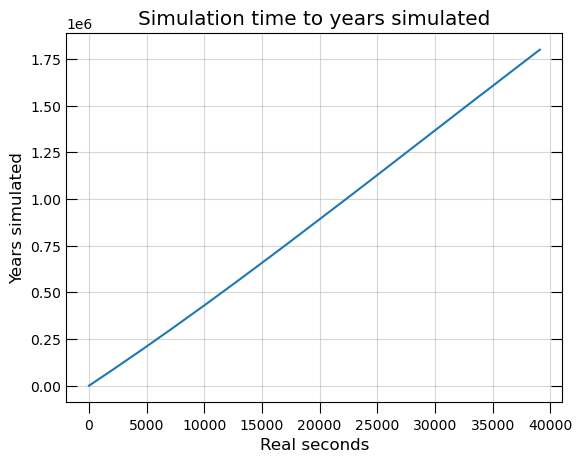

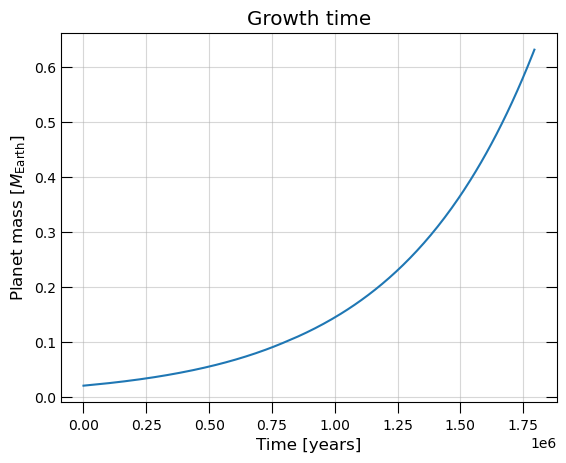

In [71]:
plt.figure()
plt.plot(simulationtimearray, timearray)
plt.title('Simulation time to years simulated')
plt.ylabel('Years simulated')
plt.xlabel('Real seconds')
plt.grid(alpha=0.5)

plt.figure()
plt.plot(timeplotarray, protomasstimeplotarray/earthmass)
plt.title('Growth time')
plt.ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.xlabel('Time [years]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
plt.grid(alpha=0.5)



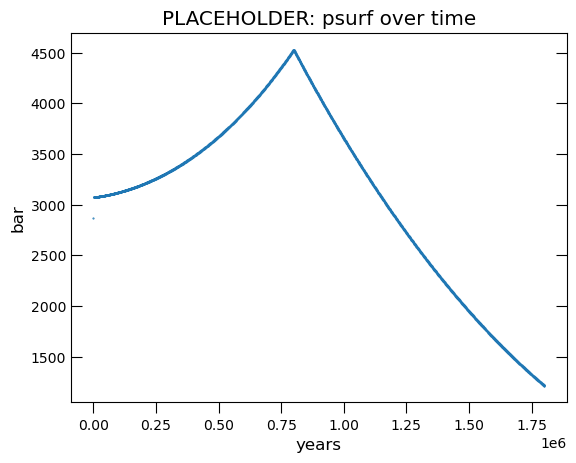

In [72]:
plt.figure()
plt.title('PLACEHOLDER: psurf over time')
plt.xlabel('years')
plt.ylabel('bar')
plt.plot(timearray, psurf_evo*GPatobar,'.', markersize=1)


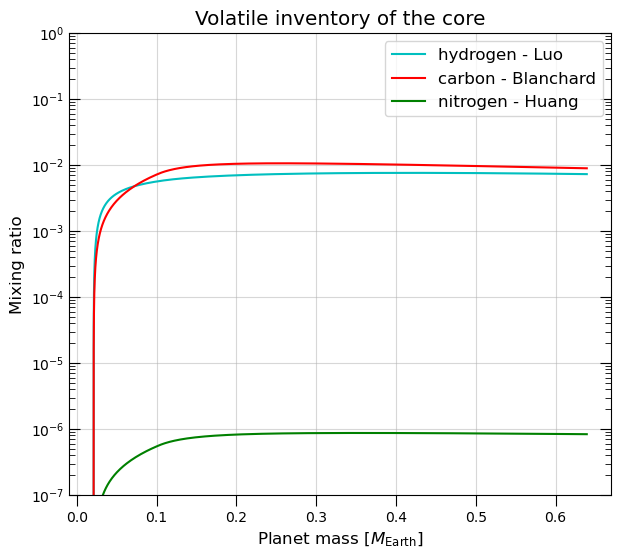

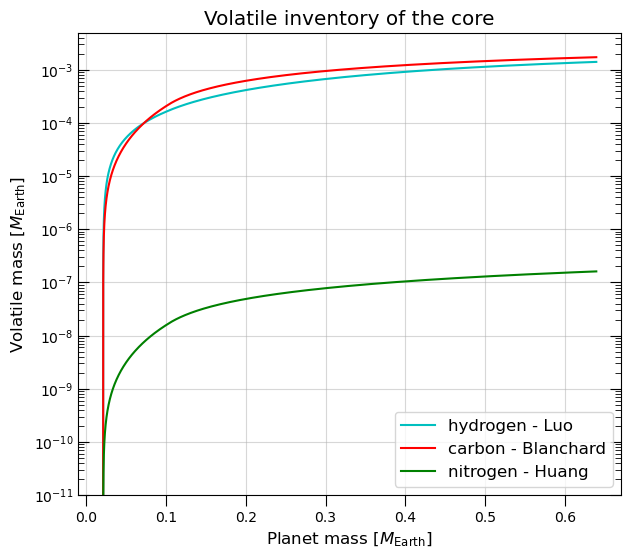

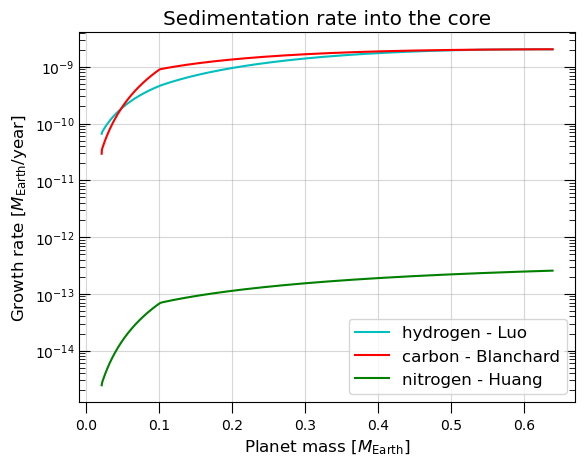

In [73]:
# Xicore vs. protomass
Xicorefig = plt.figure(figsize=(7,6))
Xicoretimearray = Micoretimearray/Mctimearray
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Xicoretimearray[i][longstartind:longstopind], color=vcolors[i], label=volatiles[i]+Ppaperlabel[i])
    plt.title('Volatile inventory of the core')
    plt.ylabel('Mixing ratio')
    plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}$]')
    plt.grid(alpha=0.5)
    plt.ylim(bottom=1e-7, top=1)
plt.legend()

# Micore vs. protomass
Micorefig = plt.figure(figsize=(7,6))
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Micoretimearray[i][longstartind:longstopind]/earthmass, color=vcolors[i], label=volatiles[i]+Ppaperlabel[i])
    plt.title('Volatile inventory of the core')
    plt.ylabel('Volatile mass '+r'$[M_\mathrm{Earth}$]')
    plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}$]')
    plt.grid(alpha=0.5)
    plt.ylim(bottom=1e-11)
plt.legend()
if plotsaving:
    Micorefig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/Micore.png', bbox_inches='tight', dpi=200)

# dMicore/dt vs. protomass
plt.figure()
for i in irange:
    sedrate = delta(Micoretimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind])/earthmass
    plt.semilogy(centeraveraging(protomasstimearray[longstartind:longstopind])/earthmass, sedrate, color=vcolors[i], label=volatiles[i]+Ppaperlabel[i])
    plt.title('Sedimentation rate into the core')
    plt.ylabel('Growth rate '+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
    plt.xlabel('Planet mass ' + r'$[M_\mathrm{Earth}$]')
    # plt.gca().set_xlim(xmin=0.024)
    plt.grid(alpha=0.5)
plt.legend()



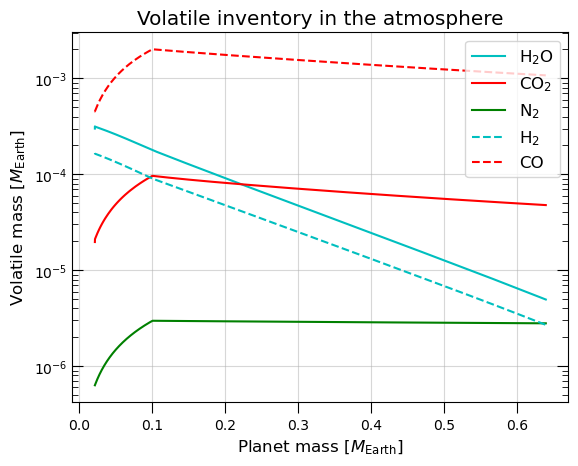

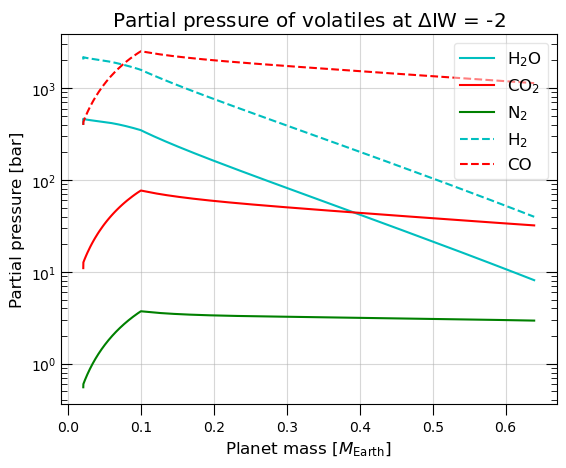

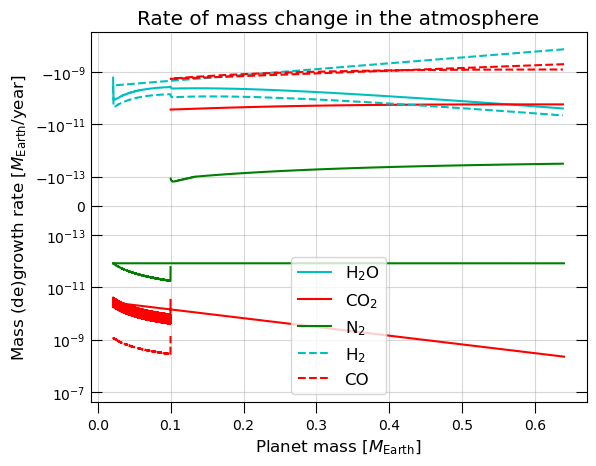

In [74]:
# Miatm vs time
# plt.figure()
# for i in irange:
#     plt.semilogy(timearray, Miatmtimearray[i]/earthmass, color=vcolors[i])
#     plt.title('Volatile inventory in the atmosphere')
#     plt.ylabel('Mass'+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
#     plt.xlabel('Time [years]')
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0,3))
#     plt.grid(alpha=0.5)

# Miatm vs protomass
plt.figure()
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Miatmtimearray[i][longstartind:longstopind]/earthmass, color=vcolors[i], label=gasvolatiles[i])
for i in range(len(extragasvolatiles)):
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, Miatmextratimearray[i][longstartind:longstopind]/earthmass, '--', color=vcolors[i], label=extragasvolatiles[i])
plt.title('Volatile inventory in the atmosphere')
plt.ylabel('Volatile mass '+r'$[M_\mathrm{Earth}]$')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
plt.legend()

# pi vs. protomass
deltaIWstr = r'$\Delta$IW = '+str(deltaIW) # alt. 1. Constant deltaIW label
# deltaIWstr = r'$\Delta$IW$_0$ = '+"{:.1f}".format(deltaIWmassfunc(protomasstimearray[0]))

pi_evo = np.array([GPatobar*psurf_evo[j]*molefraction(Miatmfulltimearray[:,j], amuifull) for j in range(len(timearray))]).transpose()
pifig = plt.figure()
for i in irange:
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[i][longstartind:longstopind], '-', color=vcolors[i], label=fullgasvolatiles[i])
for i in range(len(extragasvolatiles)):
    plt.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[len(volatiles)+i][longstartind:longstopind], '--',  color=vcolors[i], label=fullgasvolatiles[len(volatiles)+i])
plt.legend()

plt.title('Partial pressure of volatiles at '+deltaIWstr)
plt.ylabel('Partial pressure [bar]')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
plt.legend(fancybox=True, framealpha=0.5)
if plotsaving:
    pifig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/piatm.png', bbox_inches='tight', dpi=200)

# dMiatm/dt vs. protomass
plt.figure()
dissratemin = []
for i in irange:
    dissrate = (delta(Miatmtimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass
    posind = np.nonzero(dissrate>0)[0]
    negind = np.nonzero(dissrate<=0)[0]
    plt.plot(centeraveraging(protomasstimearray)[posind+longstartind-1]/earthmass, dissrate[posind],'-', color=vcolors[i], label=gasvolatiles[i])
    plt.plot(centeraveraging(protomasstimearray)[negind+longstartind-1]/earthmass, dissrate[negind],'-', color=vcolors[i])
    dissratemin += [np.min(np.abs(dissrate))] 
for i in range(len(extragasvolatiles)):
    dissrate = (delta(Miatmextratimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass
    posind = np.nonzero(dissrate>0)[0]
    negind = np.nonzero(dissrate<0)[0]
    plt.plot(centeraveraging(protomasstimearray)[posind+longstartind-1]/earthmass, dissrate[posind],'--', color=vcolors[i], label=extragasvolatiles[i])
    plt.plot(centeraveraging(protomasstimearray)[negind+longstartind-1]/earthmass, dissrate[negind],'--', color=vcolors[i])
    dissratemin += [np.min(np.abs(dissrate))] 
plt.yscale('symlog', linthresh=10**(int(np.log10(np.min(dissratemin)))))
if (longstartind in negind):
    plt.gca().invert_yaxis()

plt.title('Rate of mass change in the atmosphere')
plt.ylabel('Mass (de)growth rate '+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
plt.xlabel('Planet mass ' + r'$[M_\mathrm{Earth}$]')
plt.legend()
plt.grid(alpha=0.5)




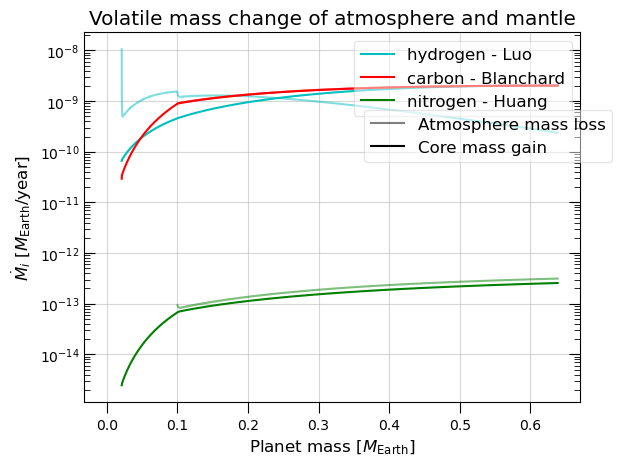

In [75]:
# Compare dissolution to sedimentation rates
fig, ax = plt.subplots()
fracratemin = []
for i in irange:
    sedrate = delta(Micoretimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind])/earthmass
    dissrate = (delta(Miatmequivsumtimearray[i][longstartind:longstopind])/delta(timearray[longstartind:longstopind]))/earthmass
    fracrate = sedrate/dissrate

    posind = np.nonzero(fracrate>0)[0]
    negind = np.nonzero(fracrate<=0)[0]
    
    sedline = ax.semilogy(centeraveraging(protomasstimearray[longstartind:longstopind])/earthmass, sedrate, color=vcolors[i], label=volatiles[i]+Ppaperlabel[i])
    # sedline = ax.semilogy(centeraveraging(protomasstimearray)[negind+longstartind-1]/earthmass, sedrate[negind],'-', color=vcolors[i], label=volatiles[i])
    dissline = ax.semilogy(centeraveraging(protomasstimearray)[negind+longstartind]/earthmass, -dissrate[negind],'-', color=vcolors[i], alpha=0.5)
    fracratemin += [np.min(np.abs(fracrate))] 
leg1 = plt.legend(loc='upper right', framealpha=0.5)
dummy1, = ax.semilogy(0, 0, '-', alpha=0.5, color='k', label='Atmosphere mass loss')
dummy2, = ax.semilogy(0, 0, '-', color='k', label='Core mass gain')
leg2 = ax.legend(handles=[dummy1, dummy2], loc=(0.565,0.65), framealpha=0.5)
ax.add_artist(leg1)

plt.title('Volatile mass change of atmosphere and mantle')
plt.ylabel(r'$\dot{M}_{i}$ '+r'$[M_\mathrm{Earth}/\mathrm{year}]$')
plt.xlabel('Planet mass ' + r'$[M_\mathrm{Earth}$]')
# plt.gca().set_xlim(left=0.1)
plt.grid(alpha=0.5)
if plotsaving:
    fig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/masschangeboth.png', bbox_inches='tight', dpi=200)


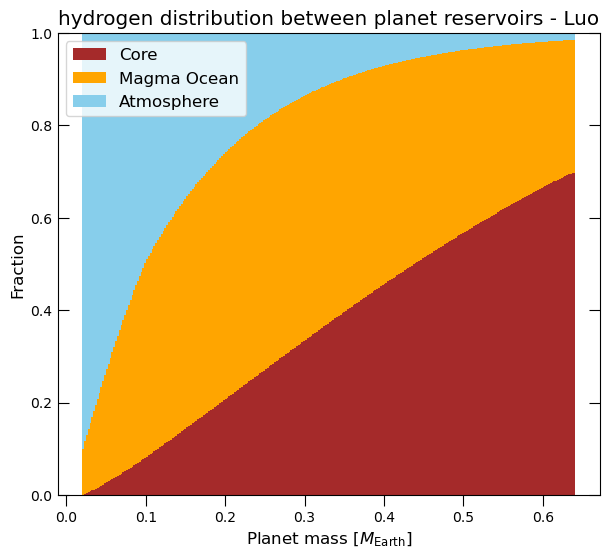

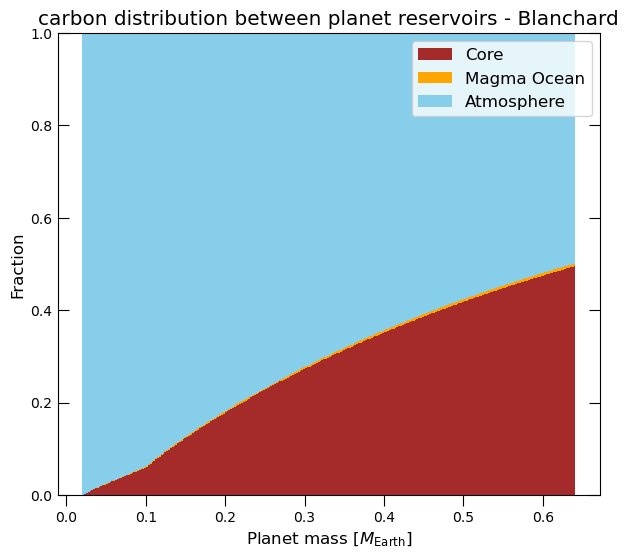

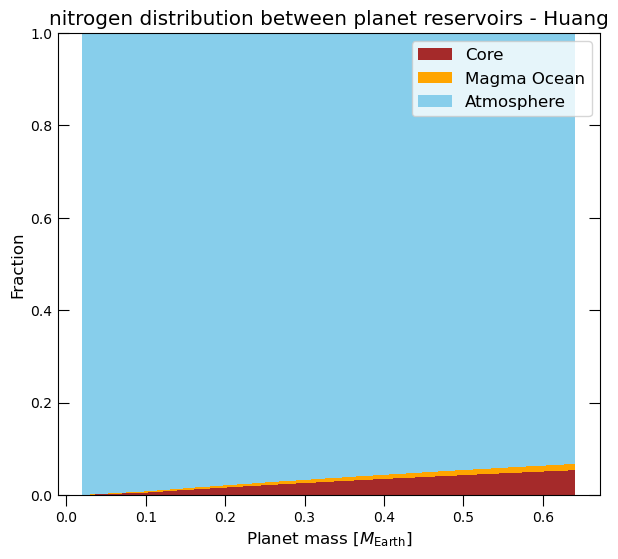

In [76]:
# Volatile storage, where are they? 

npoints = (shortstopind%len(timeplotarray))-shortstartind # modulo operator bypasses problem where we've define stopind = -1 (final point)
protomasslin, protostep = np.linspace(protomasstimearray[longstartind], protomasstimearray[longstopind], npoints, retstep=True)

Miatmused = [Miatmsumtimearray, Miatmequivsumtimearray][1] # choose how to tally atmosphere mass. 0: naively count mass of species, 1: count mass of reduced species as if they were containing the extra oxygen atom. 
Miatmsuminterp = np.array([np.interp(protomasslin, protomasstimearray, Miatmused[i]) for i in irange])
Mimagmainterp = np.array([np.interp(protomasslin, protomasstimeplotarray, Mimagma[:, i]) for i in irange])
Micoreinterp = np.array([np.interp(protomasslin, protomasstimearray, Micoretimearray[i]) for i in irange])
Mitotinterp = Miatmsuminterp+Micoreinterp+Mimagmainterp # total volatile inventory

fiatminterp = Miatmsuminterp/Mitotinterp
fimagmainterp = Mimagmainterp/Mitotinterp
ficoreinterp = Micoreinterp/Mitotinterp

reservoircolors = ['brown', 'orange', 'skyblue']

for i in irange:
    reservoirfig = plt.figure(figsize=(7,6))
    plt.bar(protomasslin/earthmass, ficoreinterp[i], width=protostep/earthmass, color=reservoircolors[0], label='Core')
    plt.bar(protomasslin/earthmass, fimagmainterp[i], width=protostep/earthmass, bottom=ficoreinterp[i], color=reservoircolors[1], label='Magma Ocean')
    plt.bar(protomasslin/earthmass, fiatminterp[i], width=protostep/earthmass, bottom=ficoreinterp[i]+fimagmainterp[i], color=reservoircolors[2], label='Atmosphere')
    plt.title(volatiles[i]+' distribution between planet reservoirs'+Ppaperlabel[i])
    plt.ylabel('Fraction')
    plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    plt.gca().set_ylim(0, 1)
    plt.legend()
    if plotsaving:
        reservoirfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/reservoir'+volatiles[i]+'.png', bbox_inches='tight', dpi=200)


0.6968037549889563


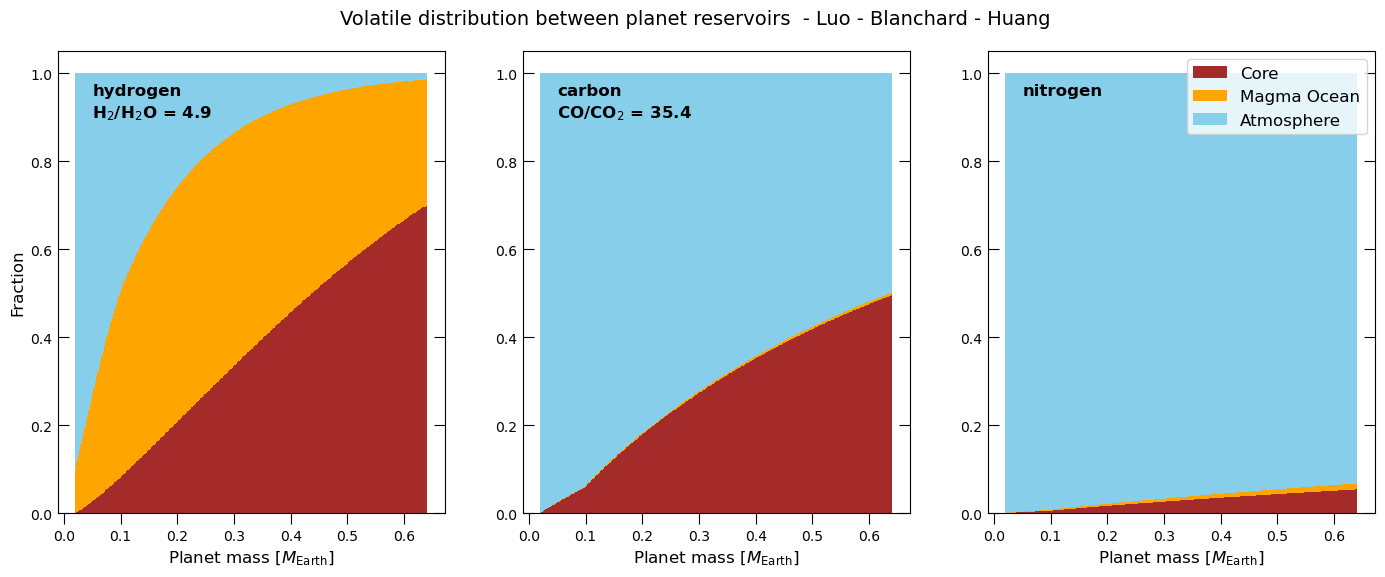

In [77]:
npoints = (shortstopind%len(timeplotarray))-shortstartind # modulo operator bypasses problem where we've define stopind = -1 (final point)
protomasslin, protostep = np.linspace(protomasstimearray[longstartind], protomasstimearray[longstopind], npoints, retstep=True)

widereservoirfig, axs = plt.subplots(1, 3, figsize=(17,6))
for i in irange:
    axs[i].bar(protomasslin/earthmass, ficoreinterp[i], width=protostep/earthmass, color=reservoircolors[0], label='Core')
    axs[i].bar(protomasslin/earthmass, fimagmainterp[i], width=protostep/earthmass, bottom=ficoreinterp[i], color=reservoircolors[1], label='Magma Ocean')
    axs[i].bar(protomasslin/earthmass, fiatminterp[i], width=protostep/earthmass, bottom=ficoreinterp[i]+fimagmainterp[i], color=reservoircolors[2], label='Atmosphere')
    axs[i].set_xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    axs[i].text(0.05, 0.95, volatiles[i], weight=1000)
    axs[i].set_ylim(0, 1.05)
    if i != 2:
        moleratio = pi_evo[i+3, -1]/pi_evo[i, -1]
        axs[i].text(0.05, 0.90, fullgasvolatiles[i+3]+'/'+fullgasvolatiles[i]+' = '+str("{:.1f}".format(moleratio)), weight=1000)
widereservoirfig.suptitle('Volatile distribution between planet reservoirs '+Ppaperlabel[0]+Ppaperlabel[1]+Ppaperlabel[2], y=0.95, fontsize=14)
axs[0].set_ylabel('Fraction', fontsize=12)

print(ficoreinterp[0][-1])

# axs[i].gca().set_ylim(0, 1)
plt.legend()
if plotsaving:
    widereservoirfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/widereservoir.png', bbox_inches='tight', dpi=200)



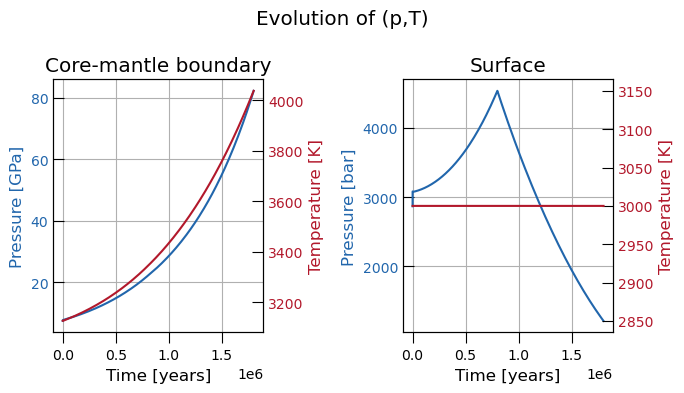

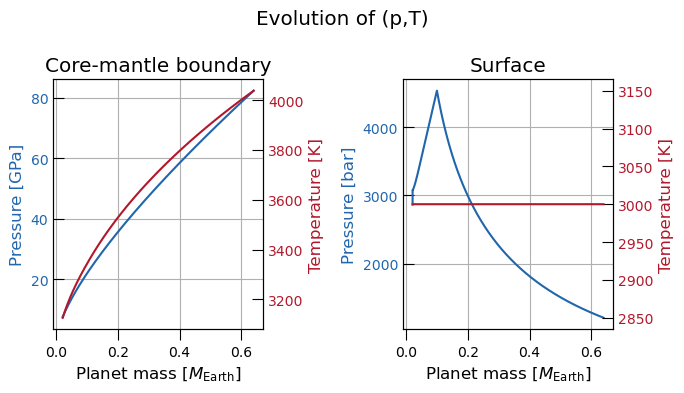

In [78]:
# evolution of p, T over time.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=((7,4)))
fig.suptitle('Evolution of (p,T)')
colors = ['#2166ac', '#b2182b']

ax1.set_title('Core-mantle boundary')
ax1.set_xlabel('Time [years]')
ax1.set_ylabel('Pressure [GPa]', color=colors[0])
ax1.plot(timearray, cmbcondtimearray[1,:], color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,3))

ax3 = ax1.twinx()  # shared x-axis
ax3.set_ylabel('Temperature [K]', color=colors[1])
ax3.plot(timearray, cmbcondtimearray[2,:], color=colors[1])
ax3.tick_params(axis='y', labelcolor=colors[1])

ax2.set_title('Surface')
ax2.set_xlabel('Time [years]')
ax2.set_ylabel('Pressure [bar]', color=colors[0])
ax2.plot(timearray, surfcondtimearray[1,:]*GPatobar, color=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[0])
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,3))

ax4 = ax2.twinx()  # shared x-axis
ax4.set_ylabel('Temperature [K]', color=colors[1])
ax4.plot(timearray, surfcondtimearray[2,:], color=colors[1])
ax4.tick_params(axis='y', labelcolor=colors[1])

ax1.locator_params(axis='both', nbins=6)  # set number of tick-marks
ax2.locator_params(axis='both', nbins=6)
ax1.grid(True)  # plot a grid
ax2.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped


# EVOLUTION OF (p, T) w.r.t PROTOMASS
# evolution of p, T over time. DO SAME PLOT BUT WITH X AXIS = PROTOMASSTIMEARRAY
fig, (ax1, ax2) = plt.subplots(1,2, figsize=((7,4)))
fig.suptitle('Evolution of (p,T)')
colors = ['#2166ac', '#b2182b']

ax1.set_title('Core-mantle boundary')
ax1.set_xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
ax1.set_ylabel('Pressure [GPa]', color=colors[0])
ax1.plot(protomasstimearray/earthmass, cmbcondtimearray[1,:], color=colors[0])
ax1.tick_params(axis='y', labelcolor=colors[0])

ax3 = ax1.twinx()  # shared x-axis
ax3.set_ylabel('Temperature [K]', color=colors[1])
ax3.plot(protomasstimearray/earthmass, cmbcondtimearray[2,:], color=colors[1])
ax3.tick_params(axis='y', labelcolor=colors[1])

ax2.set_title('Surface')
ax2.set_xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
ax2.set_ylabel('Pressure [bar]', color=colors[0])
ax2.plot(protomasstimearray/earthmass, surfcondtimearray[1,:]*GPatobar, color=colors[0])
ax2.tick_params(axis='y', labelcolor=colors[0])

ax4 = ax2.twinx()  # shared x-axis
ax4.set_ylabel('Temperature [K]', color=colors[1])
ax4.plot(protomasstimearray/earthmass, surfcondtimearray[2,:], color=colors[1])
ax4.tick_params(axis='y', labelcolor=colors[1])

ax1.locator_params(axis='both', nbins=6)  # set number of tick-marks
ax2.locator_params(axis='both', nbins=6)
ax1.grid(True)  # plot a grid
ax2.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

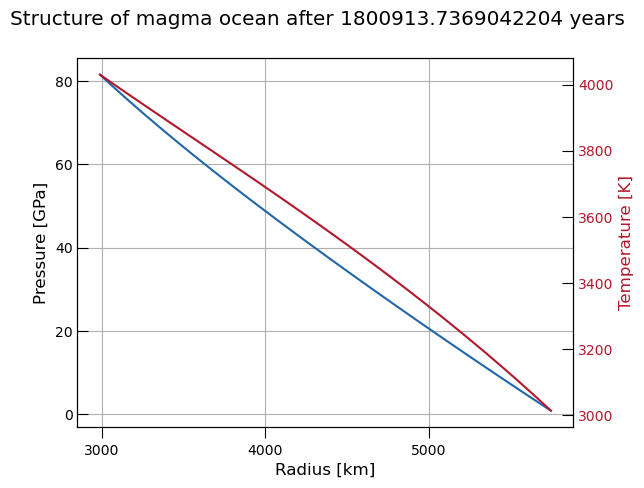

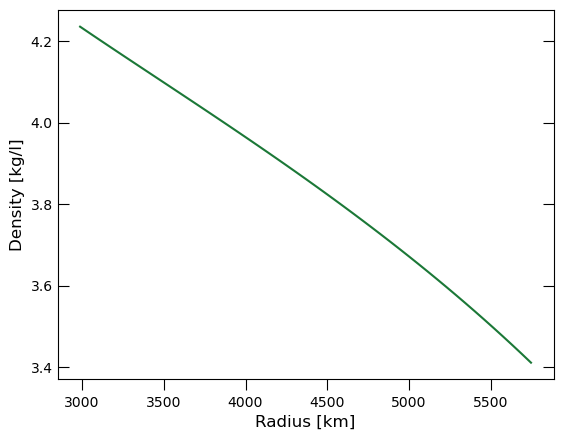

In [79]:
fig, ax1 = plt.subplots(1,1)
fig.suptitle('Structure of magma ocean after '+str(timearray[-1]) +
                         ' years')
colors = ['#1b7837', '#762a83', '#2166ac', '#b2182b']
ax1.set_ylabel('Pressure [GPa]')
ax1.set_xlabel('Radius [km]')
ax1.plot(rkfromfile[-1], pressurefromfile[-1], color=colors[2])

ax2 = ax1.twinx()
ax2.plot(rkfromfile[-1], temperaturefromfile[-1], color=colors[3])
ax2.set_ylabel('Temperature [K]', color=colors[3])
ax2.tick_params(axis='y', labelcolor=colors[3])
ax1.locator_params(axis='both', nbins=6)  # set number of tick-marks
ax1.grid(True)  # plot a grid

plt.figure()
plt.ylabel('Density [kg/l]')
plt.xlabel('Radius [km]')
plt.plot(rkfromfile[-1], densityfromfile[-1], color=colors[0])


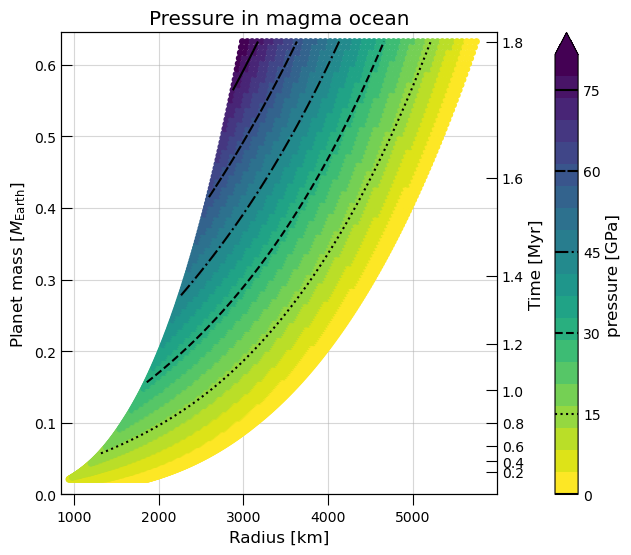

In [80]:
linestylelist=['-', ':', '--','-.', (0, (5,1)), '-']
extratop = 1.02
massplotmatrix = np.tile(protomasstimeplotarray/earthmass, (len(rkfromfile[0]), 1)).transpose()

# Pressure colorplot
pressurefig = plt.figure(figsize=(7.5,6))
plt.title('Pressure in magma ocean')
cmap = plt.get_cmap('viridis_r', 20)
y = pressurefromfile
CS = plt.scatter(rkfromfile, massplotmatrix, c=y, cmap=cmap, norm=mplcolors.Normalize(vmin=y.min(), vmax=y.max()), s=15)
colorax = plt.gca()
colorax.set_xlabel('Radius [km]')
colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
colorax.set_ylim(bottom=0, top=protomasstimeplotarray[-1]/earthmass*extratop)
colorax.set_xlim(left=rkfromfile[0,0]*0.9)
cbar = pressurefig.colorbar(CS, label='pressure [GPa]', extend='max', pad=0.1)
contour = colorax.contour(rkfromfile, massplotmatrix, y, levels=5, colors='k', linewidths=1.5, linestyles=linestylelist)
for j in range(len(contour.levels)):
    cbar.ax.axhline(contour.levels[j], color='k', linestyle=linestylelist[j%len(linestylelist)])
plt.gca().set_ylim(bottom=0)
plt.gca().set_xlim(left=rkfromfile[0,0]*0.9)
cbar.ax.set_yticks(contour.levels[contour.levels<y.max()])
colorax.grid(alpha=0.5)
colorax.set_axisbelow(True)

ax2 = colorax.twinx()
lintimestep = 0.2
lintime = np.arange(1e6*lintimestep, timeplotarray[-1]+1e6*lintimestep, 1e6*lintimestep)
massinterp = np.interp(lintime, timeplotarray, protomasstimeplotarray/earthmass)
ax2.set_yticks(massinterp, labels=["{:.1f}".format(t/1e6) for t in lintime])
ax2.set_ylabel('Time [Myr]')
ax2.set_ylim(colorax.get_ylim())

cbar.ax.tick_params(axis='y', which='major', direction='out', size=0)
cbar.ax.tick_params(axis='y', which='minor', direction='out', size=0)
if plotsaving:
    pressurefig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/pressure.png', bbox_inches='tight', dpi=200)
    

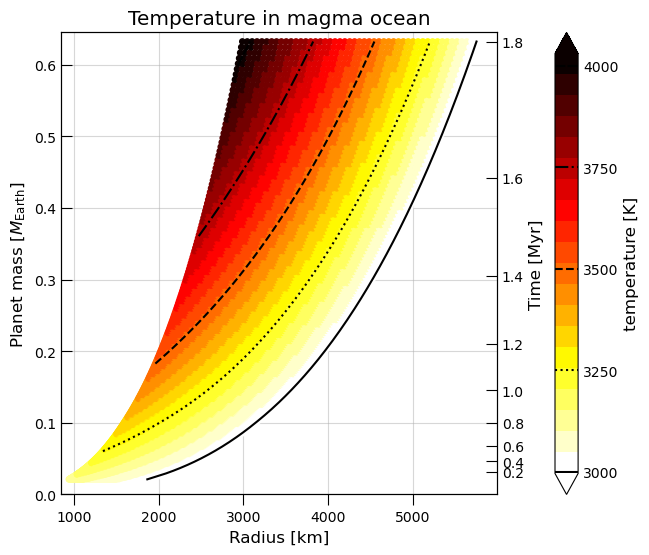

In [81]:

# Temperature colorplot
temperaturefig = plt.figure(figsize=(7.5,6))
plt.title('Temperature in magma ocean')
cmap = plt.get_cmap('hot_r', 20)
y = temperaturefromfile
CS = plt.scatter(rkfromfile, massplotmatrix, c=y, cmap=cmap, norm=mplcolors.Normalize(vmin=y.min()-5, vmax=y.max()), s=15)
plt.plot(rkfromfile[:,-1], protomasstimeplotarray/earthmass, color='k', linewidth=1.5)
colorax = plt.gca()
colorax.set_xlabel('Radius [km]')
colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
colorax.set_ylim(bottom=0, top=protomasstimeplotarray[-1]/earthmass*extratop)
colorax.set_xlim(left=rkfromfile[0,0]*0.9)
cbar = temperaturefig.colorbar(CS, label='temperature [K]', extend='both', pad=0.1)
contour = colorax.contour(rkfromfile, massplotmatrix, y, levels=4, colors='k', linewidths=1.5, linestyles=linestylelist)
for j in range(len(contour.levels)):
    cbar.ax.axhline(contour.levels[j], color='k', linestyle=linestylelist[j%len(linestylelist)])
cbar.ax.set_yticks(contour.levels[contour.levels<y.max()])
colorax.grid(alpha=0.5)
colorax.set_axisbelow(True)

ax2 = colorax.twinx()
lintimestep = 0.2
lintime = np.arange(1e6*lintimestep, timeplotarray[-1]+1e6*lintimestep, 1e6*lintimestep)
massinterp = np.interp(lintime, timeplotarray, protomasstimeplotarray/earthmass)
ax2.set_yticks(massinterp, labels=["{:.1f}".format(t/1e6) for t in lintime])
ax2.set_ylabel('Time [Myr]')
ax2.set_ylim(colorax.get_ylim())

cbar.ax.tick_params(axis='y', which='major', direction='out', size=0)
cbar.ax.tick_params(axis='y', which='minor', direction='out', size=0)
if plotsaving:
    temperaturefig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/temperature.png', bbox_inches='tight', dpi=200)


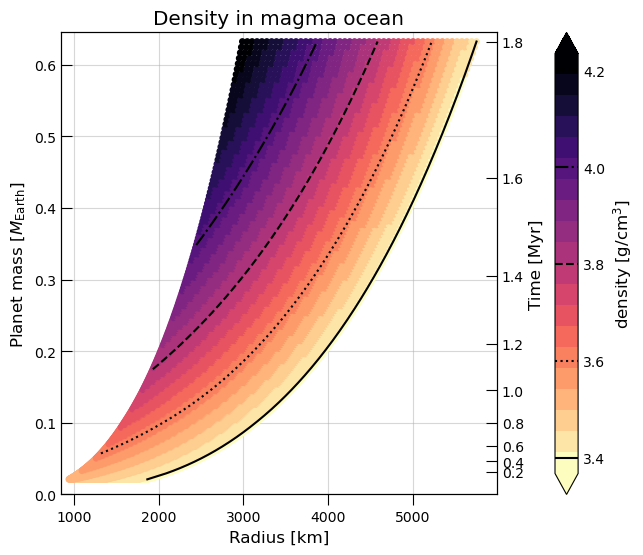

In [82]:
# density colorplot
densityfig = plt.figure(figsize=(7.5,6))
plt.title('Density in magma ocean')
cmap = plt.get_cmap('magma_r', 20)
y = densityfromfile
CS = plt.scatter(rkfromfile, massplotmatrix, c=y, cmap=cmap, norm=mplcolors.Normalize(vmin=y.min()*0.99, vmax=y.max()), s=15)
plt.plot(rkfromfile[:,-1], protomasstimeplotarray/earthmass, color='k', linewidth=1.5)
colorax = plt.gca()
colorax.set_xlabel('Radius [km]')
colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
colorax.set_ylim(bottom=0, top=protomasstimeplotarray[-1]/earthmass*extratop)
colorax.set_xlim(left=rkfromfile[0,0]*0.9)
cbar = densityfig.colorbar(CS, label='density '+r'$[\mathrm{g/cm}^3]$', extend='both', pad=0.1)
contour = colorax.contour(rkfromfile, massplotmatrix, y, levels=4, colors='k', linewidths=1.5, linestyles=linestylelist)
for j in range(len(contour.levels)):
    cbar.ax.axhline(contour.levels[j], color='k', linestyle=linestylelist[j%len(linestylelist)])
cbar.ax.set_yticks(contour.levels[contour.levels<y.max()])
colorax.grid(alpha=0.5)
colorax.set_axisbelow(True)

ax2 = colorax.twinx()
lintimestep = 0.2
lintime = np.arange(1e6*lintimestep, timeplotarray[-1]+1e6*lintimestep, 1e6*lintimestep)
massinterp = np.interp(lintime, timeplotarray, protomasstimeplotarray/earthmass)
ax2.set_yticks(massinterp, labels=["{:.1f}".format(t/1e6) for t in lintime])
ax2.set_ylabel('Time [Myr]')
ax2.set_ylim(colorax.get_ylim())

cbar.ax.tick_params(axis='y', which='major', direction='out', size=0)
cbar.ax.tick_params(axis='y', which='minor', direction='out', size=0)
if plotsaving:
    densityfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/density.png', bbox_inches='tight', dpi=200)


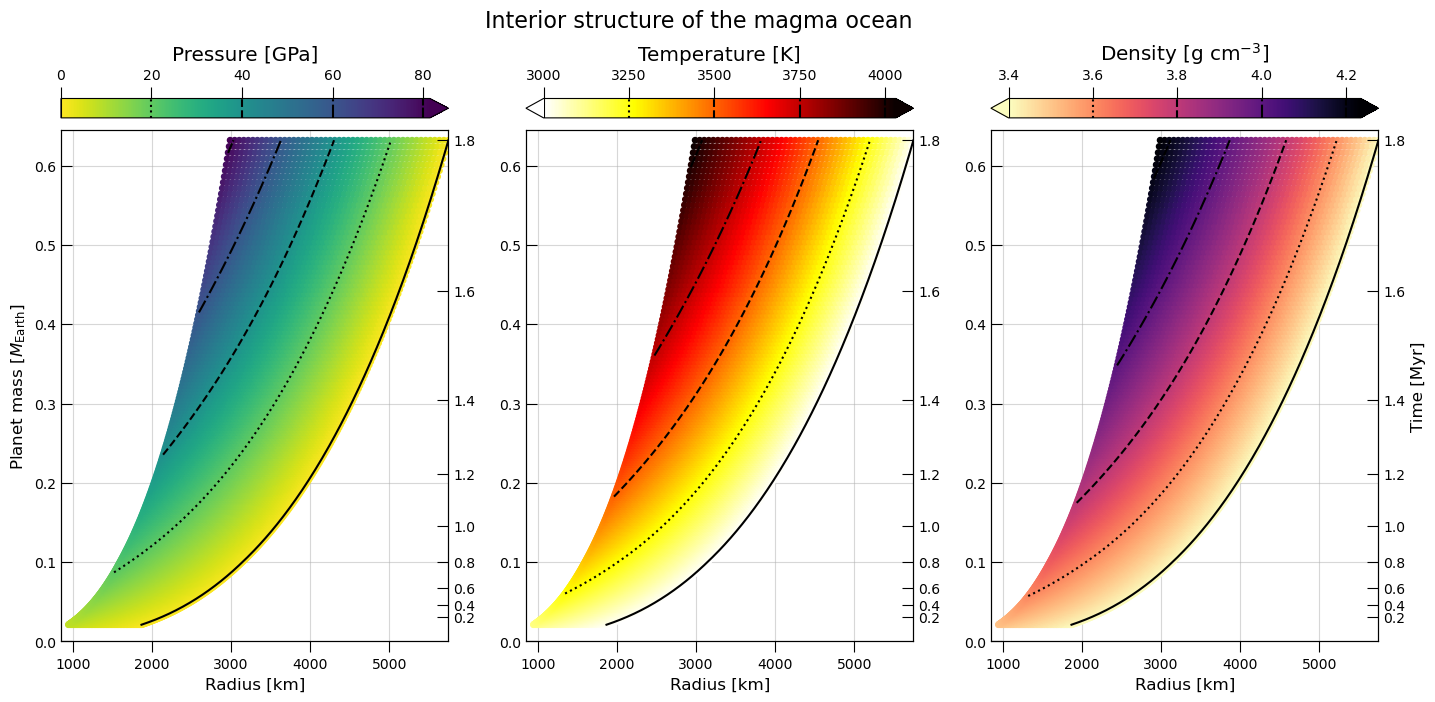

In [83]:
# p, T, rho colorplots in a single figure
widestructurefig, axs = plt.subplots(1, 3, figsize=(17,8))
widestructurefig.suptitle('Interior structure of the magma ocean', y=0.90, fontsize=16)

cmap_names = ['viridis_r', 'hot_r', 'magma_r']
# pressure

for i in range(3):
    y = [pressurefromfile, temperaturefromfile, densityfromfile][i]
    CS = axs[i].scatter(rkfromfile, massplotmatrix, c=y, cmap=plt.get_cmap(cmap_names[i]), norm=mplcolors.Normalize(vmin=y.min(), vmax=y.max()), s=15)
    axs[i].plot(rkfromfile[:,-1], protomasstimeplotarray/earthmass, color='k', linewidth=1.5)
    # axs[i].set_title(['Pressure', 'Temperature', 'Density'][i])
    axs[i].set_xlabel('Radius [km]')
    axs[i].grid(alpha=0.5)
    axs[i].set_axisbelow(True)
    
    cbar = widestructurefig.colorbar(CS, extend=['max', 'both', 'both'][i], pad=0.02, orientation='horizontal', location='top')
    cbar.ax.yaxis.set_label_position("left")
    contour = axs[i].contour(rkfromfile, massplotmatrix, y, levels=4, colors='k', linewidths=1.5, linestyles=linestylelist)
    axs[i].set_ylim(bottom=0, top=protomasstimeplotarray[-1]/earthmass*extratop)
    axs[i].set_xlim(left=rkfromfile[0,0]*0.9)
    cbar.ax.set_title(['Pressure [GPa]', 'Temperature [K]', 'Density '+r'$[\mathrm{g} \ \mathrm{cm}^{-3}]$'][i])
    for j in range(len(contour.levels)):
        cbar.ax.axvline(contour.levels[j], color='k', linestyle=linestylelist[j%len(linestylelist)])
    cbar.ax.set_xticks(contour.levels[contour.levels<y.max()])

    ax2 = axs[i].twinx()
    lintimestep = 0.2
    lintime = np.arange(1e6*lintimestep, timeplotarray[-1]+1e6*lintimestep, 1e6*lintimestep)
    massinterp = np.interp(lintime, timeplotarray, protomasstimeplotarray/earthmass)
    ax2.set_yticks(massinterp, labels=["{:.1f}".format(t/1e6) for t in lintime])
    ax2.set_ylim(axs[i].get_ylim())

    cbar.ax.tick_params(axis='y', which='major', direction='out', size=8)
    cbar.ax.tick_params(axis='y', which='minor', direction='out', size=4)
axs[0].set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
ax2.set_ylabel('Time [Myr]')

if plotsaving:
    widestructurefig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/widestructure.png', bbox_inches='tight', dpi=200)


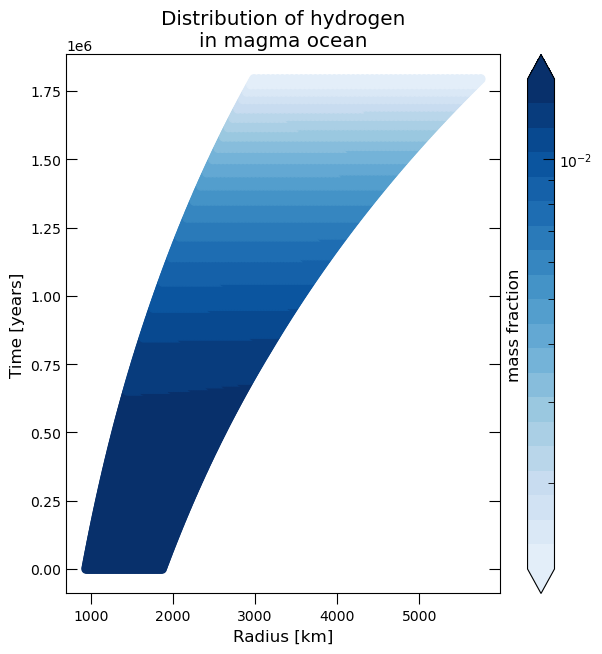

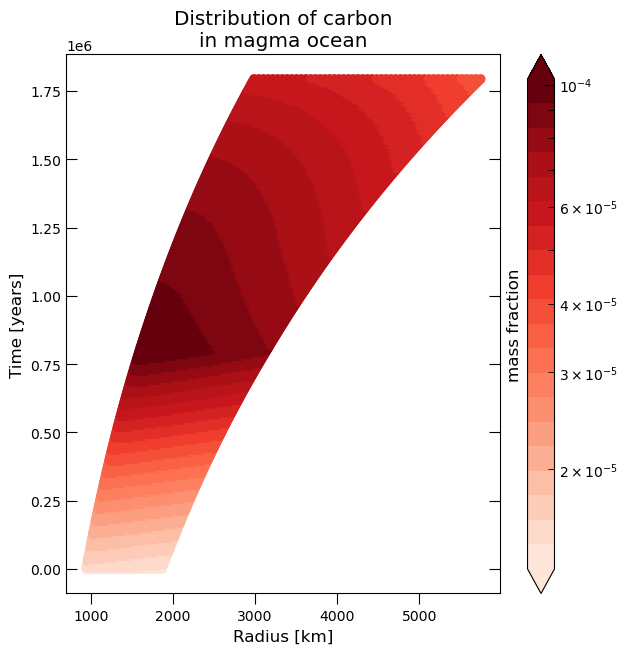

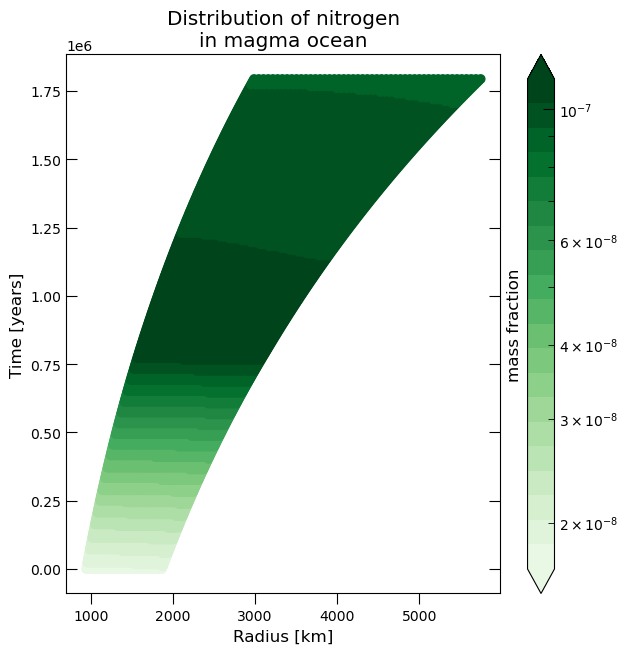

In [84]:
volatilecolorstyles = np.array(['Blues','Reds','Greens'])

timeplotmatrix = np.tile(timeplotarray, (len(rkfromfile[0]), 1)).transpose()
for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    CS = plt.scatter(rkfromfile, timeplotmatrix, c=y, cmap=cmap, norm=mplcolors.LogNorm(vmin=y.min(), vmax=y.max()))
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_xlabel('Radius [km]')
    colorax.set_ylabel('Time [years]')
    colorax.ticklabel_format(style='sci', axis='y', scilimits=(0,3))
    cbar = colorfig.colorbar(CS, label='mass fraction', extend='both')
    cbar.ax.yaxis.set_label_position("left")
    # contourlevels = np.logspace(np.log10(y.min()), np.log10(y.max()), 21)
    # contour = colorax.contour(rkfromfile, timeplotmatrix, y, levels=contourlevels, colors='k', linewidths=1)
    # cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])



    

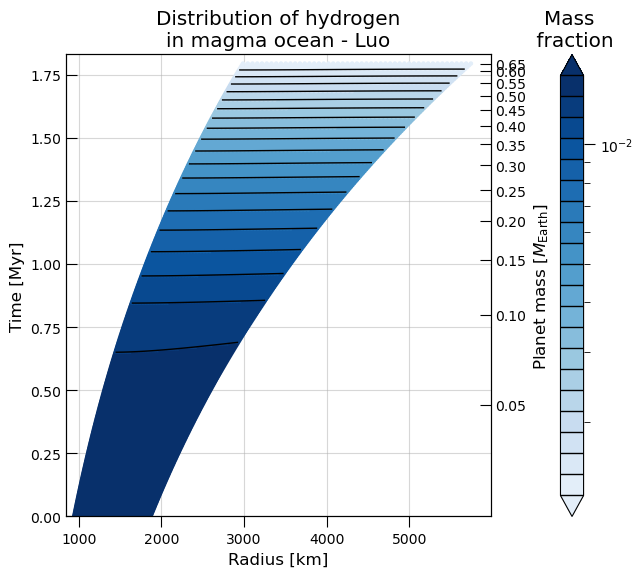

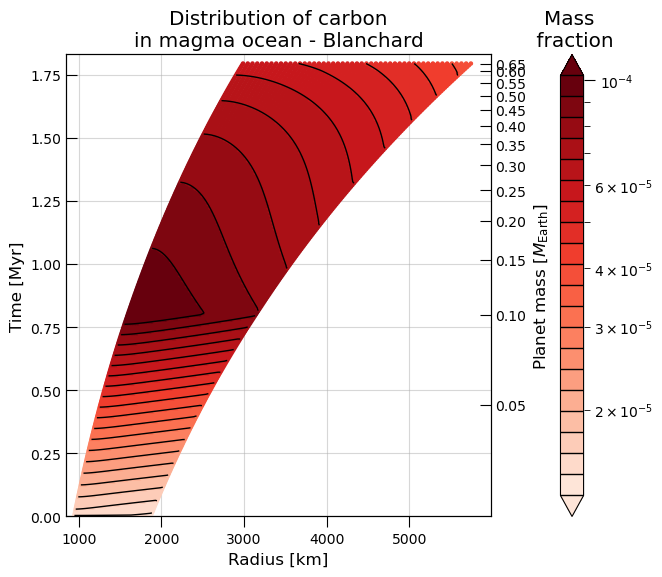

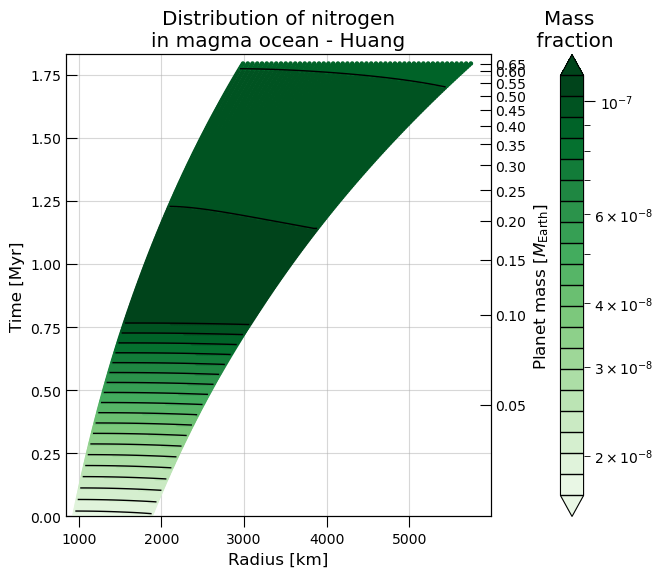

In [85]:
timeplotmatrix = np.tile(timeplotarray, (len(rkfromfile[0]), 1)).transpose()
# cutofftime = timearray[np.nonzero(Micoretimearray[0]>0)[0][0]] # option 0, plot from first starting to sediment
cutoffind = shortstartind # option 1, start plot manually from chosen time
for i in irange:
    colorfig = plt.figure(figsize=(7.5,6))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    
    CS = plt.scatter(rkfromfile[cutoffind:], timeplotmatrix[cutoffind:]/1e6, c=y[cutoffind:], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[cutoffind:].min(), vmax=y[cutoffind:].max()), s=5)
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean'+Ppaperlabel[i])
    colorax = plt.gca()
    colorax.set_xlabel('Radius [km]')
    colorax.set_ylabel('Time [Myr]')
    colorax.set_ylim(bottom=0, top=timeplotarray[-1]*extratop/1e6)
    colorax.set_xlim(left=rkfromfile[0,0]*0.9)
    colorax.ticklabel_format(style='sci', axis='y', scilimits=(0,3))
    colorax.grid(alpha=0.5)
    colorax.set_axisbelow(True)
    
    cbar = colorfig.colorbar(CS, extend='both', pad=0.12)
    cbar.ax.set_title('Mass \n fraction')
    # cbar.ax.yaxis.set_label_position("left")
    contourlevels = np.logspace(np.log10(y[cutoffind:].min()), np.log10(y[cutoffind:].max()), 21)
    contour = colorax.contour(rkfromfile[cutoffind:], timeplotmatrix[cutoffind:]/1e6, y[cutoffind:], levels=contourlevels, colors='k', linewidths=1)
    cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])
    ax2 = colorax.twinx()
    protostep = 0.05
    protomasslin = np.arange(protostep, protomasstimeplotarray[-1]/earthmass+protostep, protostep)
    timeinterp = np.interp(protomasslin, protomasstimeplotarray/earthmass, timeplotarray)
    ax2.set_yticks(timeinterp/1e6, labels=["{:.2f}".format(mlin) for mlin in protomasslin])
    ax2.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    ax2.set_ylim(colorax.get_ylim())

    cbar.ax.tick_params(axis='y', which='major', direction='out', size=8)
    cbar.ax.tick_params(axis='y', which='minor', direction='out', size=4)
    # if plotsaving:
    #     colorfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/color'+volatiles[i]+'.png', bbox_inches='tight', dpi=200)


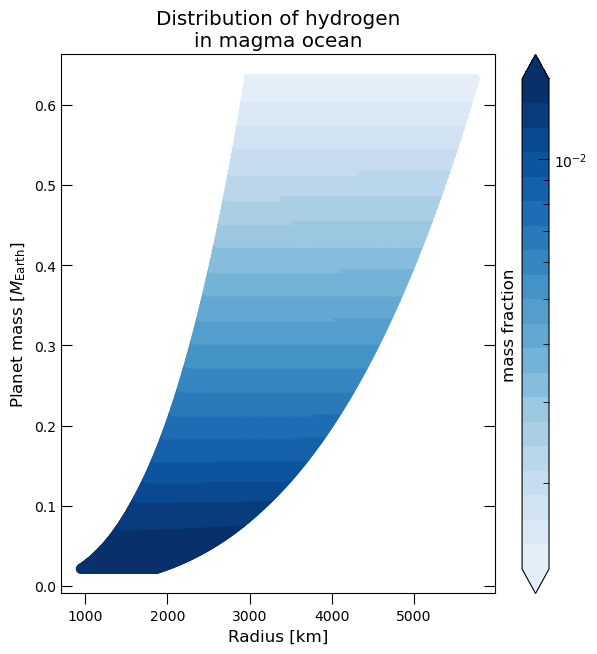

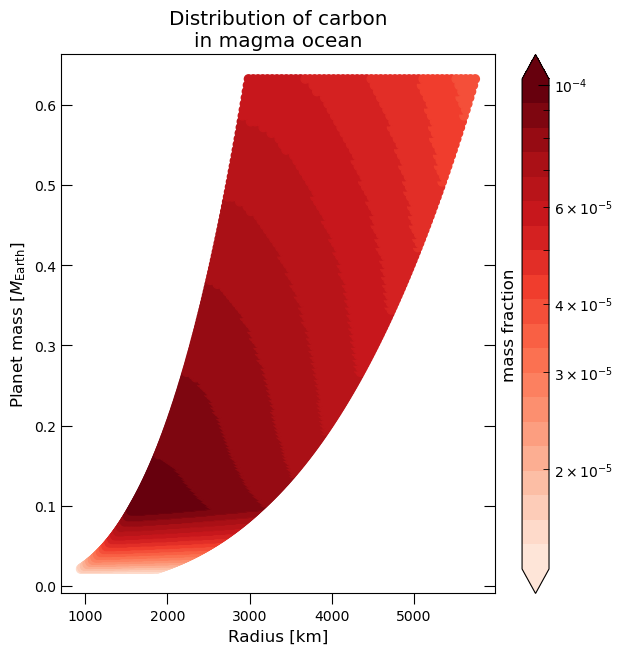

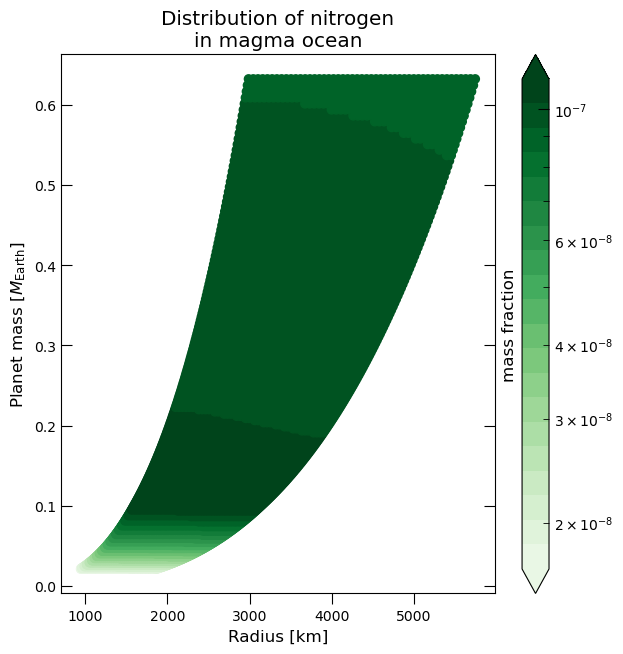

In [86]:
# mass radius distribution color plot
protomassplotmatrix = np.tile(protomasstimeplotarray, (len(rkfromfile[0]), 1)).transpose()
cutoffmass = protomasstimearray[np.nonzero(Micoretimearray[0]>0)[0][0]] # ensure that you've started accreting
cutoffind = np.nonzero(cutoffmass<=protomasstimeplotarray)[0][0]

for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = Mvolfromfile[:,i]/Mtotfromfile
    CS = plt.scatter(rkfromfile[cutoffind:], protomassplotmatrix[cutoffind:]/earthmass, c=y[cutoffind:], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[cutoffind:].min(), vmax=y[cutoffind:].max()))
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_xlabel('Radius [km]')
    colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    cbar = colorfig.colorbar(CS, label='mass fraction', extend='both')
    cbar.ax.yaxis.set_label_position("left")
    # contourlevels = np.logspace(np.log10(y[cutoffind:].min()), np.log10(y[cutoffind:].max()), 21)
    # contour = colorax.contour(rkfromfile[cutoffind:], protomassplotmatrix[cutoffind:]/earthmass, y[cutoffind:], levels=contourlevels, colors='k', linewidths=1)
    # cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])



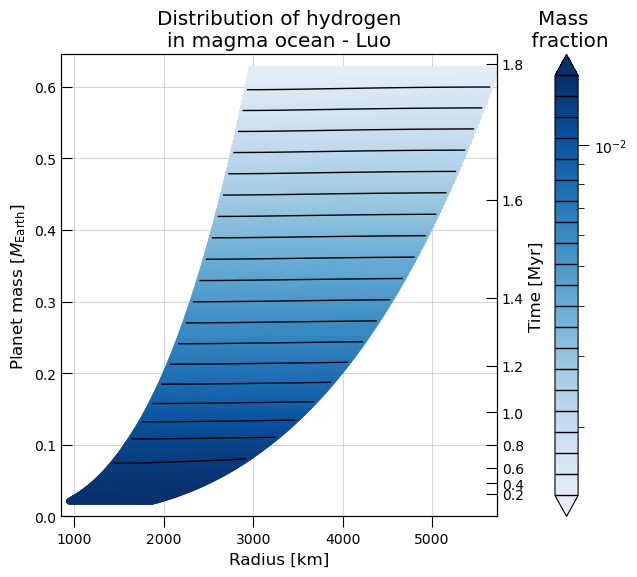

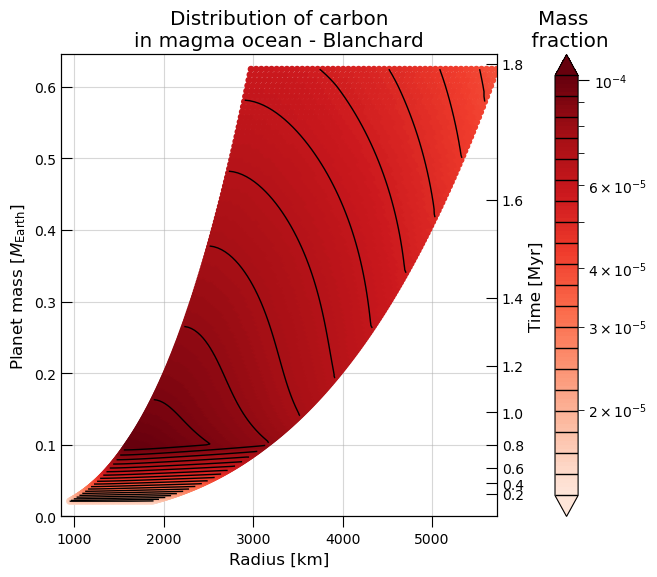

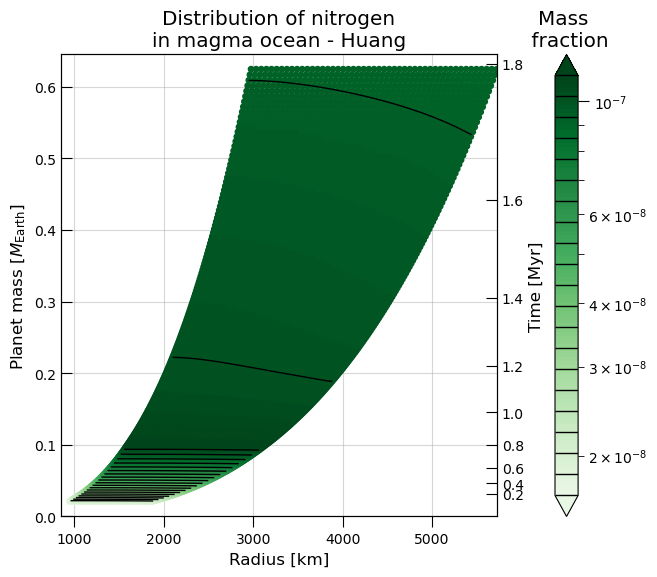

In [87]:
# cutoff mass radius distribution color plot
protomassplotmatrix = np.tile(protomasstimeplotarray, (len(rkfromfile[0]), 1)).transpose()
startcut = 0.05*earthmass # CHOICE, lowest mass plotted
stopcut = 0.6*earthmass # CHOICE, highest mass plotted
startind = np.nonzero(startcut<=protomasstimeplotarray)[0][0]
if stopcut<protomasstimeplotarray[-1]:
    stopind = np.nonzero(stopcut<=protomasstimeplotarray)[0][0]
else:
    stopind = len(protomasstimeplotarray)-1

# Or use same cut-off choice as other plots
startind = shortstartind
stopind = shortstopind

for i in irange:
    colorfig = plt.figure(figsize=(7.5,6))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 100)), 100)
    y = Mvolfromfile[:,i]/Mtotfromfile

    CS = plt.scatter(rkfromfile[startind:stopind], protomassplotmatrix[startind:stopind]/earthmass, c=y[startind:stopind], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[startind:stopind].min(), vmax=y[startind:stopind].max()), s=15)
    plt.title('Distribution of '+volatiles[i]+'\n'+'in magma ocean'+Ppaperlabel[i])
    colorax = plt.gca()
    colorax.set_xlabel('Radius [km]')
    colorax.set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    colorax.grid(alpha=0.5)
    colorax.set_axisbelow(True)

    cbar = colorfig.colorbar(CS, extend='both', pad=0.10)
    cbar.ax.yaxis.set_label_position("left")
    contourlevels = np.logspace(np.log10(y[startind:stopind].min()), np.log10(y[startind:stopind].max()), 21)
    contour = colorax.contour(rkfromfile[startind:stopind], protomassplotmatrix[startind:stopind]/earthmass, y[startind:stopind], levels=contourlevels, colors='k', linewidths=1)
    cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])
    colorax.set_ylim(bottom=0, top=protomasstimeplotarray[-1]/earthmass*extratop)
    colorax.set_xlim(left=rkfromfile[0,0]*0.9)
    cbar.ax.set_title('Mass \n fraction')
    
    ax2 = colorax.twinx()
    lintimestep = 0.2
    lintime = np.arange(1e6*lintimestep, timeplotarray[-1]+1e6*lintimestep, 1e6*lintimestep)
    massinterp = np.interp(lintime, timeplotarray, protomasstimeplotarray/earthmass)
    ax2.set_yticks(massinterp, labels=["{:.1f}".format(t/1e6) for t in lintime])
    ax2.set_ylabel('Time [Myr]')
    ax2.set_ylim(colorax.get_ylim())

    cbar.ax.tick_params(axis='y', which='major', direction='out', size=8)
    cbar.ax.tick_params(axis='y', which='minor', direction='out', size=4)
    if plotsaving:
        colorfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/color'+volatiles[i]+'.png', bbox_inches='tight', dpi=200)


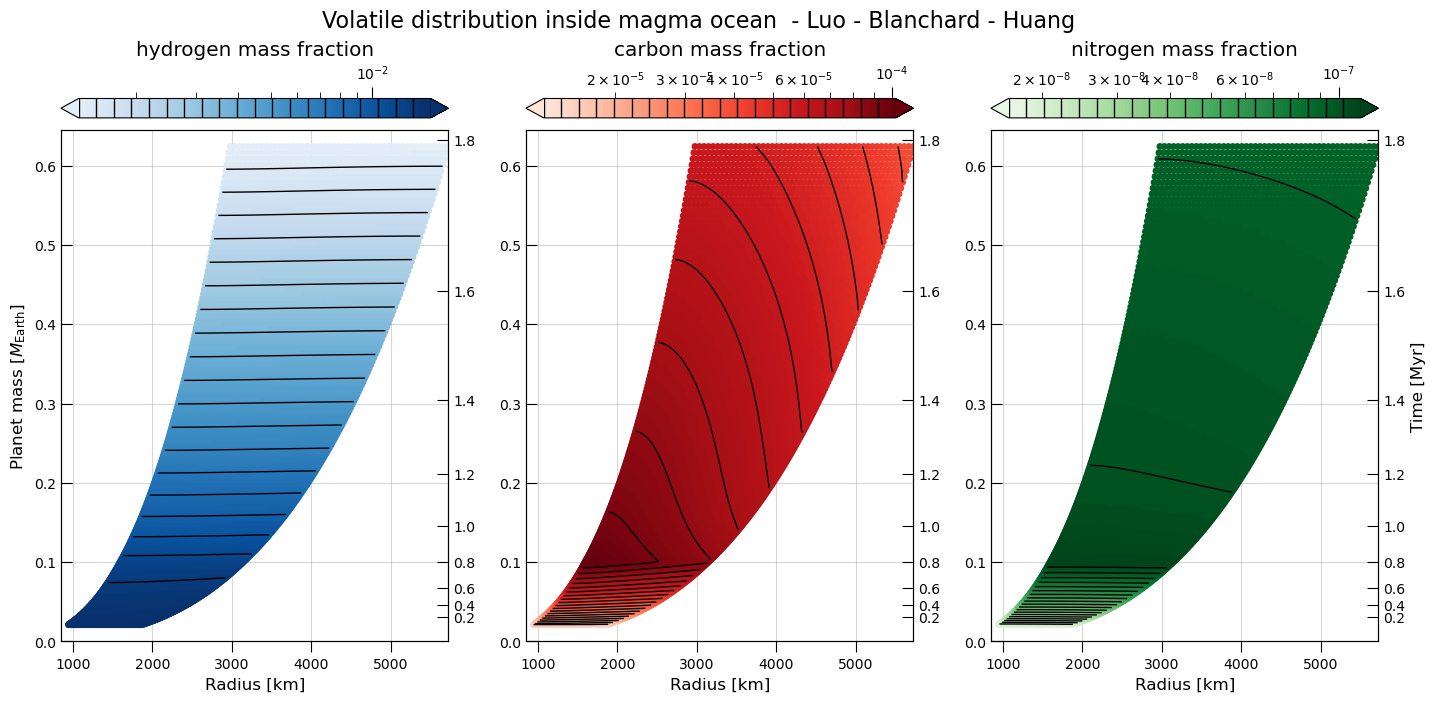

In [88]:
widedistributionfig, axs = plt.subplots(1, 3, figsize=(17,8))
widedistributionfig.suptitle('Volatile distribution inside magma ocean '+Ppaperlabel[0]+Ppaperlabel[1]+Ppaperlabel[2], y=0.90, fontsize=16)
for i in irange:
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 100)), 100)
    y = Mvolfromfile[:,i]/Mtotfromfile

    CS = axs[i].scatter(rkfromfile[startind:stopind], protomassplotmatrix[startind:stopind]/earthmass, c=y[startind:stopind], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[startind:stopind].min(), vmax=y[startind:stopind].max()), s=15)
    # axs[i].set_title(volatiles[i])
    axs[i].set_xlabel('Radius [km]')
    axs[i].grid(alpha=0.5)
    axs[i].set_axisbelow(True)

    cbar = colorfig.colorbar(CS, extend='both', pad=0.02, orientation='horizontal', location='top')
    cbar.ax.yaxis.set_label_position("left")
    contourlevels = np.logspace(np.log10(y[startind:stopind].min()), np.log10(y[startind:stopind].max()), 21)
    contour = axs[i].contour(rkfromfile[startind:stopind], protomassplotmatrix[startind:stopind]/earthmass, y[startind:stopind], levels=contourlevels, colors='k', linewidths=1)
    cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])
    axs[i].set_ylim(bottom=0, top=protomasstimeplotarray[-1]/earthmass*extratop)
    axs[i].set_xlim(left=rkfromfile[0,0]*0.9)
    cbar.ax.set_title(volatiles[i]+' mass fraction')
    
    ax2 = axs[i].twinx()
    lintimestep = 0.2
    lintime = np.arange(1e6*lintimestep, timeplotarray[-1]+1e6*lintimestep, 1e6*lintimestep)
    massinterp = np.interp(lintime, timeplotarray, protomasstimeplotarray/earthmass)
    ax2.set_yticks(massinterp, labels=["{:.1f}".format(t/1e6) for t in lintime])
    ax2.set_ylim(colorax.get_ylim())

    cbar.ax.tick_params(axis='y', which='major', direction='out', size=8)
    cbar.ax.tick_params(axis='y', which='minor', direction='out', size=4)
axs[0].set_ylabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
ax2.set_ylabel('Time [Myr]')

if plotsaving:
    widedistributionfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/widedistribution.png', bbox_inches='tight', dpi=200)


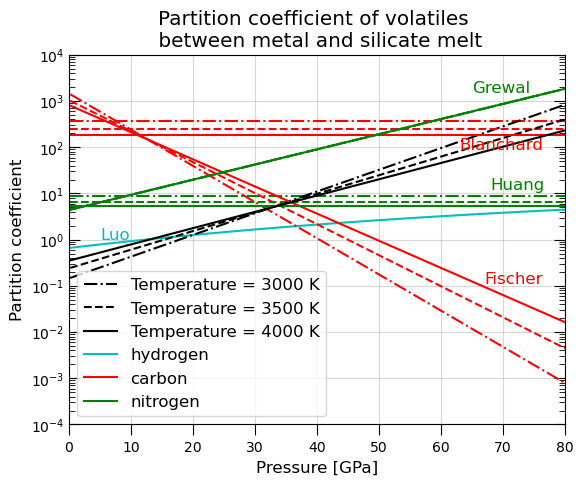

In [132]:
# Partition coefficient as function of p,T (and hydrogen fraction at final time step)

# Carbon partition coefficient. Parametrization from Fischer2020. Pressure, temperature in GPa, K units.
def PCfuncFischer(p, T, deltaIW=deltaIWmagmaocean, Xoxygen=XO, Xsulfur=XS, NBOperT=NBOperT, microprobe=False):
    if cappedtemperature:
        T = np.where(T>5500, 5500, T) # approximate limit of parametrization 
    if microprobe: # derived from microprobe analysis in Fischer2020
            log10PC = 1.81+2470/T-227*p/T+9.7 * \
            np.log10(1-Xsulfur)-30.6*np.log10(1-Xoxygen) - \
            0.123*NBOperT-0.211*deltaIW
    else: # derived from nanoSIMS analysis in Fischer2020
        log10PC = 1.49+3000/T-235*p/T+9.6 * \
            np.log10(1-Xsulfur)-19.5*np.log10(1-Xoxygen) - \
            0.118*NBOperT-0.238*deltaIW
    return 10**log10PC


def PCfuncBlanchard(p, T, deltaIW=deltaIWmagmaocean, valence=2): # Blanchard2022
    if cappedtemperature:
        T = np.where(T>4000, 4000, T) # limits of their experiments
    if valence==2:
        logKD = 0.3+3822/T+0*p/T # log10 distribution coeff.
        PC = (10**logKD)*(10**(-deltaIW/2)) 
    else: # valence == 4
        logKD = -1+4842/T+31*p/T # log10 distribution coeff.
        PC = 10**logKD*10**-deltaIW
    return PC


def PCfuncTsutsumi(p, T, deltaIW=deltaIWmagmaocean, NBOperT=NBOperT): # Tsutsumi2025 
    log10PC = 1.51-0.68*deltaIW-0.33*NBOperT # does not use p or T
    return 10**log10PC*np.ones_like(p)


def PCfunc(p, T, PCpaper=PCpaper): # choice of which PC paper to use
    if PCpaper=='Fischer':
        return PCfuncFischer(p, T)
    elif PCpaper=='Blanchard': 
        return PCfuncBlanchard(p, T)
    elif PCpaper=='Tsutsumi':
        return PCfuncTsutsumi(p, T)
    else:
        return 300*np.ones_like(p) # return constant value from AnatomyIII otherwise

    
# Nitrogen partition function. Parametrization from Grewal2019. Pressure, temperature in GPa, K units.
def PNfuncGrewal(p, T, XFeO=XFeOfin, Xsulfur=XS, Xsilicon=0, NBOperT=NBOperT):
    if cappedtemperature:
        T = np.where(temperature>2200, 2200, np.where(temperature<1500, 1500, temperature)) # approximate limit of parametrization 
    a, b, c, d, e, f, g, h = -1415.40, 5816.24, 166.14, 343.44, -38.36, 139.52, 0.82, 1.13
    # calculate log10 of the partition coefficient for nitrogen.
    lnPN = a+b/T+c*p/T+d*np.log(100*(1-Xsulfur))+e*np.log(100*(1-Xsulfur))**2+f*np.log(100*(1-Xsilicon))+g*NBOperT+h*np.log(100*XFeO)
    return np.exp(lnPN)  # return the partition coefficient

# Nitrogen partition function. Parametrization from Huang2024. Pressure, temperature in GPa, K units. 
def PNfuncHuang(p, T, Xcarbon=0, Xsulfur=XS, Xsilicon=0, Xoxygen=XO, NBOperT=NBOperT, deltaIW=deltaIWmagmaocean):
    if cappedtemperature:
        T = np.where(T>4980, 4980, np.where(T<1523, 1523, T)) # approximate limit of parametrization 
    a, b, c, d, e, f, g, h, i = 0, 2732, 0, 4.04, 2.00, 5.57, 6.28, 0.49, 0.40
    # calculate log10 of the partition coefficient for nitrogen.
    logPN = a+b/T+c*p/T+d*np.log10(1-Xcarbon)+e*np.log10(1-Xsulfur)+f*np.log10(1-Xsilicon)+g*np.log10(1-Xoxygen)+h*NBOperT+i*deltaIW
    return 10**logPN  # return the partition coefficient

def PNfunc(p, T, PNpaper=PNpaper):
    if PNpaper == 'Grewal':
        return PNfuncGrewal(p, T)
    else:
        return PNfuncHuang(p, T)

# Water partition function from Tsutsumi2025
def PH2OfuncTsutsumi(p, T, deltaIW=deltaIWmagmaocean, xcmetal=0):
    if cappedtemperature:
        T = np.where(T>4760, 4760, np.where(T<1523, 1523, T)) # approximate limit of parametrization 
        p = np.where(p>56, 56, np.where(p<33, 33, p))
    log10PH2O = 2.31-1542/T-38.9*p/T+6.69*np.log10(1-xcmetal)-1/4*deltaIW
    return 10**log10PH2O


# Water partition function. Parametrization from Luo2024. Function of water concentration in metal melt.
def PH2Ofunc(p, XH2Omet):
    XH2Omet = np.where(XH2Omet>1e-8, XH2Omet, 1e-8) # PREVENTS log10(0). 
    log10PH2O = 1.26-0.34 * \
        np.log10(XH2Omet*100)+0.08*np.log10(XH2Omet*100)**2-4007/(1+np.exp((p+616)/80.6))
    return 10**log10PH2O


# mass of water in metal droplets/mass of metal droplets, (torn long-edge @ page 8 of block C for derivation) 
def watermetalfraction(PH2O, MH2O, Msil, Mmet):
    return PH2O*MH2O/(PH2O*Mmet+Msil)


# calculates PH2O then watermetalfraction, then back to PH2O using a starting guess for the mass fraction of water in the metal droplets.
def iterativePH2O(p, MH2O, Msil, Mmet, CH2Ometguess=0.01, iterations=15):
    for j in range(iterations):
        PH2Oguess = PH2Ofunc(p, CH2Ometguess)
        CH2Ometguess = watermetalfraction(PH2Oguess, MH2O, Msil, Mmet)
    return PH2Oguess, CH2Ometguess

def PH2OTagawa(p, T, deltaIW=deltaIWmagmaocean, standalone=False):
    if standalone: # Do not use earlier LVP experiments
        KDTagawa = 10**(2.42-2892/T-32.0*p/T)
    else:
        KDTagawa = 10**(0.692-4590/T+141*p/T)
    PH2O = KDTagawa*10**(-deltaIW/4)
    return PH2O

with open('continuefile', 'rb') as f:
        simulatedyears, protomass0, pebblerate0, mc0, Msil, Mmet, rsurf, rk, rcore, psurf, Tsurf, pressure, temperature, density, D, CH2Omet, Pvol, Mvol, Micore0, Miatm, Miatmextra0, fO2surf0, eigval0, eigvec0, Vinv0 = pickle.load(f)
        
plin = np.linspace(0.2, 80, number_of_layers)
Tlin = np.linspace(3000, 4000, 3)
temperaturelinestyles = ['-.','--','-']

PH2Olin, CH2Olin = iterativePH2O(plin, Mvol[0], Msil, Mmet)

partfig = plt.figure()
plt.semilogy(plin, PH2Olin, color=vcolors[0])
for Tind in range(len(Tlin)):
    PH2OTsutsumilin = PH2OfuncTsutsumi(plin, Tlin[Tind])
    PClinold = PCfuncFischer(plin, Tlin[Tind], microprobe=False)
    PClinoldEPMA = PCfuncFischer(plin, Tlin[Tind], microprobe=True)
    PClin = PCfuncBlanchard(plin, Tlin[Tind], valence=2)
    PCTsutsumilin = PCfuncTsutsumi(plin, Tlin[Tind])
    PNlinold = PNfuncGrewal(plin, Tlin[Tind])
    PNlin =  PNfuncHuang(plin, Tlin[Tind])
    # plt.semilogy(plin, PH2OTsutsumilin, color=vcolors[0], linestyle=temperaturelinestyles[Tind])
    plt.semilogy(plin, PClinold, color=vcolors[1], linestyle=temperaturelinestyles[Tind])
    # plt.semilogy(plin, PClinoldEPMA, color='orange', linestyle=temperaturelinestyles[Tind])
    plt.semilogy(plin, PClin, color=vcolors[1], linestyle=temperaturelinestyles[Tind])
    # plt.semilogy(plin, PCTsutsumilin, color='k', linestyle=temperaturelinestyles[Tind])
    plt.semilogy(plin, PNlin, color=vcolors[2], linestyle=temperaturelinestyles[Tind])
    plt.semilogy(plin, PNlinold, color=vcolors[2], linestyle=temperaturelinestyles[Tind])    
    plt.semilogy(0, 0, label='Temperature = '+str(Tlin[Tind])[:-2]+' K', color='k', linestyle=temperaturelinestyles[Tind%len(temperaturelinestyles)])
    
    # Tagawa2021
    KDTagawa = 10**(0.692-4590/Tlin[Tind]+141*plin/Tlin[Tind])
    # KDTagawa = 10**(2.42-2892/Tlin[Tind]-32.0*plin/Tlin[Tind]) # Standalone

    plt.semilogy(plin, KDTagawa*10**(-deltaIW/4), color='k', linestyle=temperaturelinestyles[Tind%len(temperaturelinestyles)])

for i in irange:
    plt.semilogy(0, 0, label=volatiles[i], color=vcolors[i])
plt.text(5, 1e0, 'Luo', color=vcolors[0])
plt.text(67, 1.1e-1, 'Fischer', color=vcolors[1])
plt.text(63, 8.8e1, 'Blanchard', color=vcolors[1])
plt.text(68, 12, 'Huang', color=vcolors[2])
plt.text(65, 1.5e3, 'Grewal', color=vcolors[2])

# plt.text()
# plt.text()

plt.gca().set_xlim(0, plin[-1])
plt.gca().set_ylim(1e-4, 1e4)
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('Pressure [GPa]')
plt.ylabel('Partition coefficient')
plt.title('Partition coefficient of volatiles \n between metal and silicate melt')
if plotsaving:
    partfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/partitioncoef.png', bbox_inches='tight', dpi=200)

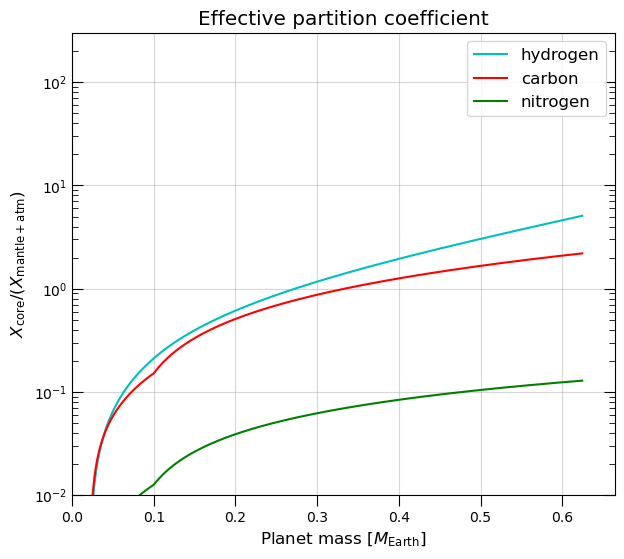

In [90]:
# Effective partition coefficient w.r.t planet mass
Xicoretimearray = Micoretimearray/Mctimearray
Miatmplusmantle = Mimagma.transpose()+np.array([np.interp(timeplotarray, timearray, M) for M in Miatmequivsumtimearray])
Xiatmplusmantle = Miatmplusmantle/np.sum(Mtotfromfile, axis=1)

# interpolate Xicore to more sparse time array
Xicoretimeplotarray = np.array([np.interp(timeplotarray, timearray, Xi) for Xi in Xicoretimearray])

Peff = Xicoretimeplotarray/Xiatmplusmantle # effective partition coefficient (being in the atmosphere counts as being in the mantle for the sake of this definition)
# nconvolve = 5 # smooth the plot (by plotting a sliding average of the points)
# Peffconvolve = np.array([np.convolve(P, np.ones(nconvolve)/nconvolve, mode='valid') for P in Peff])

effectivefig = plt.figure(figsize=(7,6))
for i in irange:
    plt.semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Peff[i][shortstartind:shortstopind], '-', color=vcolors[i], label=volatiles[i])
    # plt.semilogy(protomasstimeplotarray/earthmass, Peff[i], '.', markersize=1, color=vcolors[i])
    # plt.semilogy(protomasstimeplotarray[nconvolve//2:-nconvolve//2+1]/earthmass, Peffconvolve[i], color=vcolors[i], label=volatiles[i])
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.ylabel(r'$X_{\mathrm{core}}/(X_{\mathrm{mantle+atm}})$')
plt.title('Effective partition coefficient')

plt.gca().set_xlim(0, protomasstimeplotarray[shortstopind]/earthmass*1.05)
plt.gca().set_ylim(1e-2, 3e2)
if plotsaving:
    effectivefig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/Peff.png', bbox_inches='tight', dpi=200)


2.233598156700514
[101.27447488 101.27447488 101.76399585 102.87310568 103.99978753
 105.1453616  106.31118381 107.49865029 108.70920216 109.94433044
 111.20558137 112.49456192 113.81294573 115.16247944 116.54498939
 117.96238894 119.41668625 120.90999276 122.44453225 124.02265087
 125.6468278  127.31968712 129.04401057 130.82275163 132.65905097
 134.55625333 136.51792621 138.54788048 140.65019304 142.82923212
 145.08968516 147.43658996 149.87536929 152.41186952 155.05240401
 157.80380154 160.67346087 163.66941213 166.80038621 170.07589314
 173.50631117 177.102988   180.87835627 184.84606563 189.02113423
 193.42012306 198.06133707 202.96505825 208.15381595]


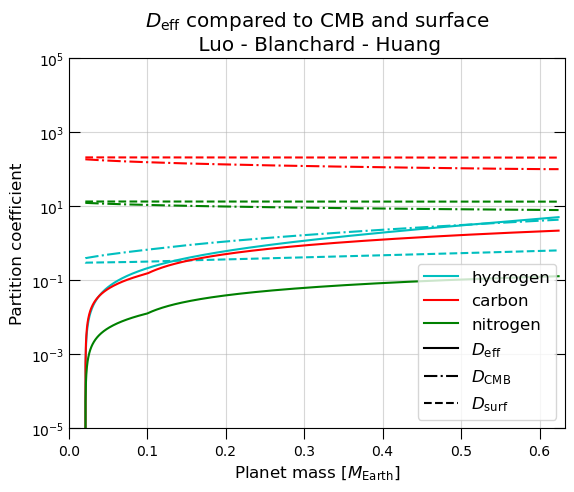

In [91]:
# Peff vs. Pcmb,current

peffcomparisonfig, ax = plt.subplots()
for i in irange:
    plt.semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Pvolfromfile[shortstartind:shortstopind,i,0], '-.', color=vcolors[i], alpha=1)
    plt.semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Pvolfromfile[shortstartind:shortstopind,i,-1], '--', color=vcolors[i], alpha=1)
    plt.semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Peff[i][shortstartind:shortstopind], '-', color=vcolors[i], label=volatiles[i])
leg1 = plt.legend(loc='upper right')
dummy1, = ax.semilogy(0, 0, '-', color='k', label='$D_{\mathrm{eff}}$')
dummy2, = ax.semilogy(0, 0, '-.', alpha=1, color='k', label='$D_{\mathrm{CMB}}$')
dummy3, = ax.semilogy(0, 0, '--', alpha=1, color='k', label='$D_{\mathrm{surf}}$')
leg2 = ax.legend(handles=[dummy1, dummy2, dummy3], loc=(0.565,0.65))

print(Peff[1,-1])
print(Pvolfromfile[-1, 1])

plt.gca().set_xlim(0, protomasstimeplotarray[shortstopind]/earthmass)
plt.gca().set_ylim(1e-5, 1e5)
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.ylabel('Partition coefficient')
plt.title(r"$D_{\mathrm{eff}}$ compared to CMB and surface"+'\n'+Ppaperlabel[0][2:]+Ppaperlabel[1]+Ppaperlabel[2])
if plotsaving:
    peffcomparisonfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/Peffcomparison.png', bbox_inches='tight', dpi=200)


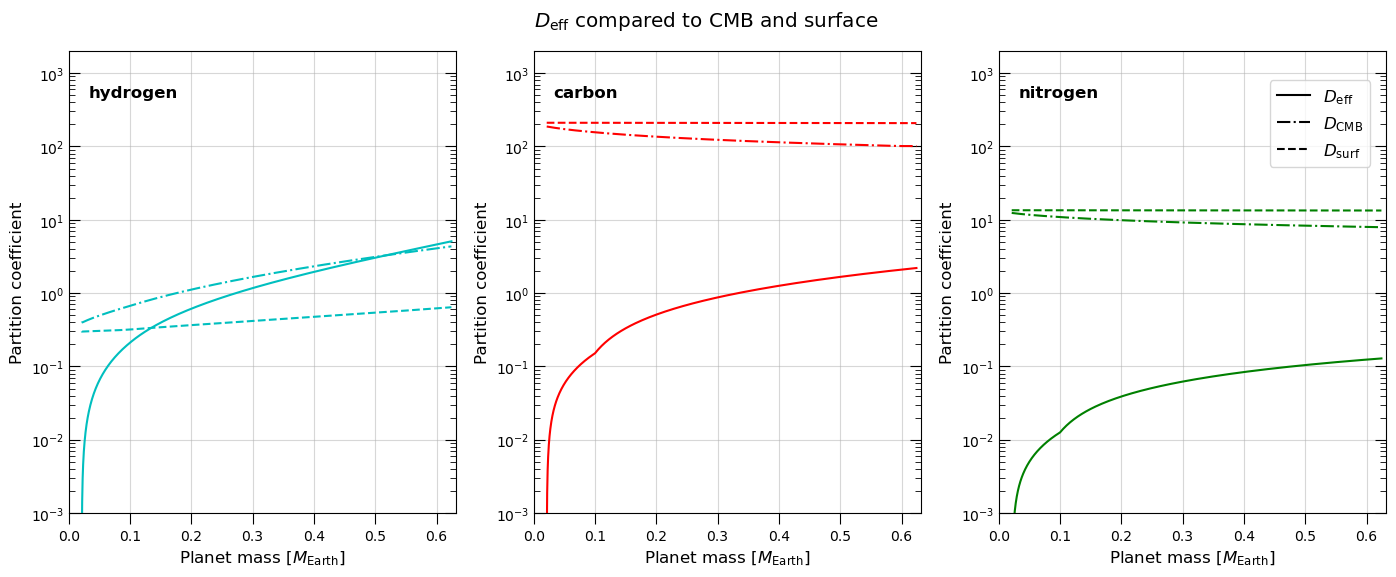

In [92]:
# Peff vs. Pcmb,current
widepeffcomparisonfig, axs = plt.subplots(1, 3, figsize=(17,6))
widepeffcomparisonfig.suptitle(r"$D_{\mathrm{eff}}$"+' compared to CMB and surface', y=0.95)
for i in irange:
    axs[i].semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Pvolfromfile[shortstartind:shortstopind,i,0], '-.', color=vcolors[i], alpha=1)
    axs[i].semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Pvolfromfile[shortstartind:shortstopind,i,-1], '--', color=vcolors[i], alpha=1)
    axs[i].semilogy(protomasstimeplotarray[shortstartind:shortstopind]/earthmass, Peff[i][shortstartind:shortstopind], '-', color=vcolors[i])

    axs[i].set_xlim(0, protomasstimeplotarray[shortstopind]/earthmass)
    axs[i].set_ylim(1e-3, 2e3)

    axs[i].grid(alpha=0.5)
    axs[i].set_xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
    axs[i].set_ylabel('Partition coefficient')
    # axs[i].set_title(volatiles[i])
    axs[i].text(0.05, 0.90, volatiles[i], weight=1000, transform=axs[i].transAxes)

dummy1, = axs[i].semilogy(0, 0, '-', color='k', label='$D_{\mathrm{eff}}$')
dummy2, = axs[i].semilogy(0, 0, '-.', alpha=1, color='k', label='$D_{\mathrm{CMB}}$')
dummy3, = axs[i].semilogy(0, 0, '--', alpha=1, color='k', label='$D_{\mathrm{surf}}$')
leg2 = axs[i].legend(handles=[dummy1, dummy2, dummy3], loc=(0.70, 0.75))

# plt.title(r"$P_{\mathrm{eff}}$ vs. $P_{\mathrm{CMB}}$")
if plotsaving:
    widepeffcomparisonfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/widePeffcomparison.png', bbox_inches='tight', dpi=200)

In [93]:
def Kifunc(Matm, fO2surf, rsurf, protomass, pebblerate, H2Oindex=0, meltindex=2, Miatmfull=None, species='CO2'): # choice of melt from which experimental K for CO2 is taken
    psurf, Tsurf = pTsurf(rsurf, Matm=Matm, protomass=protomass, pebblerate=pebblerate, a=a, Miatmfull=Miatmfull, species=species)
    pinkbar = psurf*GPatokbar
    pinbar = psurf*GPatobar
    
    if H2Oindex==0 and cappedtemperature:
        Tsurf = np.where(Tsurf>1500, 1500, Tsurf) # approximate limit of Burnham1994. Slight extrapolation
    
    KH2Ointermediate = 0.2 # Stolper1982, fig. 4. approximate equilibrium constant for intermediate water dissolution step H2O(g) -> H2O(m)
    KH2Oburnham = KH2Ointermediate*1/(np.exp(5.00+np.log(pinbar)*(4.481e-8*Tsurf**2-1.51e-4*Tsurf-1.137)+np.log(pinbar)**2*(1.831e-8*Tsurf**2-4.882e-5*Tsurf+4.656e-2)+7.80e-3*np.log(pinbar)**3-5.012e-4*np.log(pinbar)**4+Tsurf*(4.754e-3-1.621e-6*Tsurf))) # Burnham 1994, eq. 7. Taken to power -1 because their K is defined for the inverse reaction. PLACEHOLDER INCORRECT. IS ONLY EQ. CONST FOR THE H2O(melt)+O->2 OH(melt) REACTION!
    KH2Ostolper = KH2Ointermediate*np.exp(-3+pinkbar/10) # Stolper1982, fig. 4 and eq. 8. Product of K1 and K2. Slopes up one log unit after 10 kbar.
    KH2O = np.array([KH2Oburnham, KH2Ostolper])[H2Oindex] # index choice
    
    KCO2withNepheline = 1/np.exp(12.5+5.5*pinkbar/30) # Spera1980, fig. 1. Minus sign since we want the reverse equilibrium constant
    KCO2withOlivineMelilite = 1/np.exp(13+5*pinkbar/30) # Spera1980, fig. 3. -||-
    KCO2fromAnders = 4.4*1e-12*1e5 # AnatomyII, 1e5 to convert from per Pascal to per bar.
    KCO2 = np.array([KCO2withNepheline, KCO2withOlivineMelilite, KCO2fromAnders])[meltindex] # index choice
    
    R = 8.31446261815324 # J/(mol*K), universal gas constant    
    if cappedtemperature:
        Tsurf = np.where(Tsurf>1300+273, 1300+273, Tsurf) # approximate limit of Bernadou2021
    KN2chem = (np.exp(-(183733+172*Tsurf-5*pinbar)/(R*Tsurf)))**2*fO2surf**(-3/2) # Bernadou2021, eq. 14 & Table 6. fO2 dependence from eq. 18. Squaring because we compose our equivalent reaction with whole number volatile-bearing products and reactants. 
    if meltindex==2: # Follow AnatomyII eq. 12. for nitrogen dissolution iff we followed eq. 11 for carbon dissolution
        KN2phys = 6.11*1e-13*1e5 # AnatomyII, 1e5 to convert from per Pascal to per bar
    else:
        KN2phys = np.exp(-(29344+121*Tsurf+4*pinbar)/(R*Tsurf)) # Bernadou2021, eq. 13 & Table 6.

    return np.array([[KH2O, 0], [KCO2, 0], [KN2chem, KN2phys]])

def molefraction(w, amu): # calculates the mole fraction of each species using the weight fraction (or mass) and atomic mass of each species
    return np.array([(w[i]/amu[i])/(np.sum(w/amu)) for i in range(len(w))])


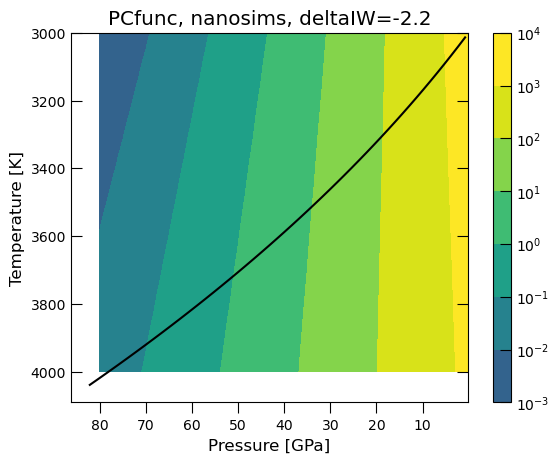

In [94]:
# TESTS 2025-05-13, after development meeting

plin = np.linspace(0.2, 80, number_of_layers)
Tlin = np.linspace(3000, 4000, number_of_layers)
X, Y = np.meshgrid(plin, Tlin)

microprobe='nanosims'
microprobebool=microprobe=='microprobe'
deltaIWchoice = -2.2
Z = PCfuncFischer(X, Y, microprobe=microprobebool, deltaIW=deltaIWchoice, NBOperT=2.6, Xoxygen=0.08)

fO2fig = plt.figure()
CS = plt.contourf(X,Y,Z,10,norm=mplcolors.LogNorm(vmin=1e-5, vmax=1e3))
cbar = fO2fig.colorbar(CS)
# invert axes so that going to the left or going down on the plot corresponds to further into the magma ocean
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title('PCfunc, '+str(microprobe)+', deltaIW='+str(deltaIWchoice)) # PLACEHOLDER, specify what deltaIW is in the figure title
plt.xlabel('Pressure [GPa]')
plt.ylabel('Temperature [K]')
plt.plot(pressure, temperature, color='k')


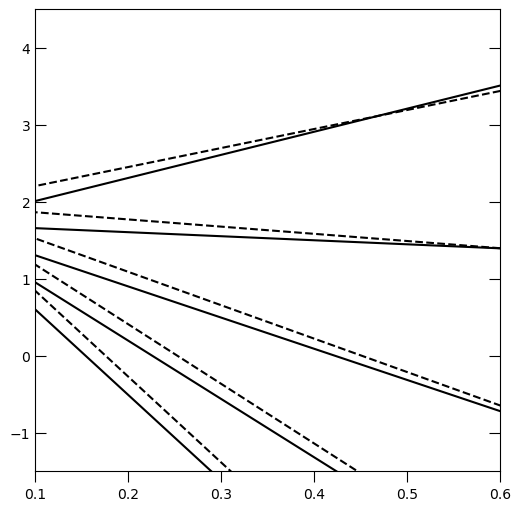

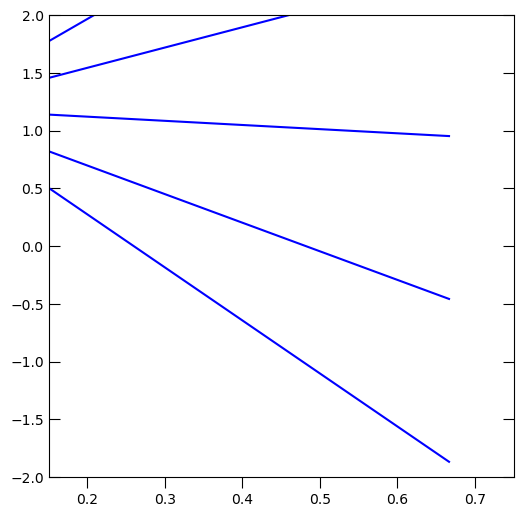

In [136]:
plt.figure(figsize=(6,6))
ptester = np.array([0, 15, 30, 45, 60])
Ttester = np.linspace(1500, 10000)
storecappedtemperature=cappedtemperature # save prev. value before overwriting
cappedtemperature=False # just to plot the same as Fischer
for p in ptester:
    plt.plot(1000/Ttester, np.log10(PCfuncFischer(p, Ttester, microprobe=True, deltaIW=-2.2, NBOperT=2.6, Xoxygen=0, Xsulfur=0)), linestyle='--', label='p = '+str(p)+' GPa', color='k')
    plt.plot(1000/Ttester, np.log10(PCfuncFischer(p, Ttester, microprobe=False, deltaIW=-2.2, NBOperT=2.6, Xoxygen=0, Xsulfur=0)), linestyle='-', label='p = '+str(p)+' GPa', color='k')

plt.gca().set_ylim((-1.5), (4.5))
plt.gca().set_xlim(0.1,0.6)

plt.figure(figsize=(6,6))
for p in ptester:
    plt.plot(1000/Ttester, np.log10(PH2OTagawa(p, Ttester)), color='blue')
plt.gca().set_ylim((-2), (2))
plt.gca().set_xlim(0.15,0.75)

cappedtemperature=storecappedtemperature # switch back


Text(0.5, 1.0, 'Recreating Bernadou2021 Fig. 3')

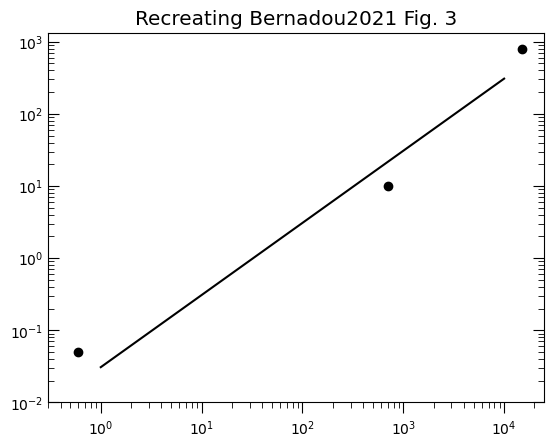

In [96]:
def pTsurf(rsurf, Matm=Matmguess, pebblerate=pebblerate0, protomass=protomass, gamma=envgamma, a=a0, Lstar=Lsun, species='CO2', Miatmfull=None):
    gsurf = G*protomass/rsurf**2
    if constanttemperature:
        Tsurf = Tconst 
        ppho = 2/3*gsurf/opacitypho*GPaconversion
        psurf = ppho + gsurf*Matm/(4*pi*rsurf**2)*GPaconversion # thin outgassed atmosphere approximation, penv approx = 0
    else:
        Ltot = pebblerate*G*protomass/rsurf
        
        penv, Tenv = pTenvbot(rsurf, pebblerate, protomass, gamma, a, Lstar)
        ppho = penv+2/3*gsurf/opacitypho*GPaconversion
        psurf = ppho + gsurf*Matm/(4*pi*rsurf**2)*GPaconversion # thin outgassed atmosphere approximation
        Tatmbot = Tatmintegral(psurf, ppho, Tenv, species, Miatmfull)
        Tsurf = (Tatmbot**4+Ltot/(4*pi*rsurf**2*sigmaBoltzmann))**(1/4)
    return psurf, Tsurf

Miatmfull = np.concatenate((Miatmtimearray[:,-1], Miatmextratimearray[:,-1]))
Matm = np.sum(Miatmfull) 
KN2 = Kifunc(Matm, fO2surf0, rsurf, protomass0, pebblerate0, meltindex=0)[2]
pN2bar = np.linspace(1, 10000)
XN2 = KN2[1]*pN2bar+(KN2[0]*pN2bar)**(1/2)
plt.figure()
plt.loglog(pN2bar, XN2*1e6, color='k')
plt.loglog([0.6, 700, 15000], [0.05, 10, 800],'o',color='k')
plt.gca().axis(xmin=3e-1, ymin=1e-2)
plt.title('Recreating Bernadou2021 Fig. 3')

In [97]:
Ki = Kifunc(Matm, fO2surf0, rsurf, protomass0, pebblerate0, meltindex=2)
KCO2 = Ki[1,0]
print('Comparison to AnatomyII eq. 11 and 12: \nCO2: '+str(KCO2*1/100000)+', N2: '+str(KN2[1]*1/100000))

Comparison to AnatomyII eq. 11 and 12: 
CO2: 4.400000000000001e-12, N2: 3.081606183543805e-13


Final atmosphere speciation as a function of deltaIW at the end of accretion: 

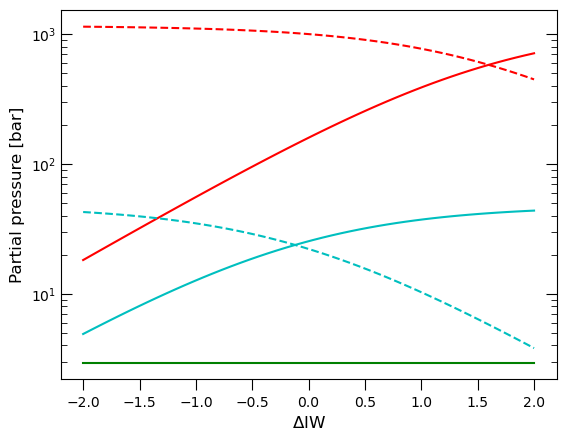

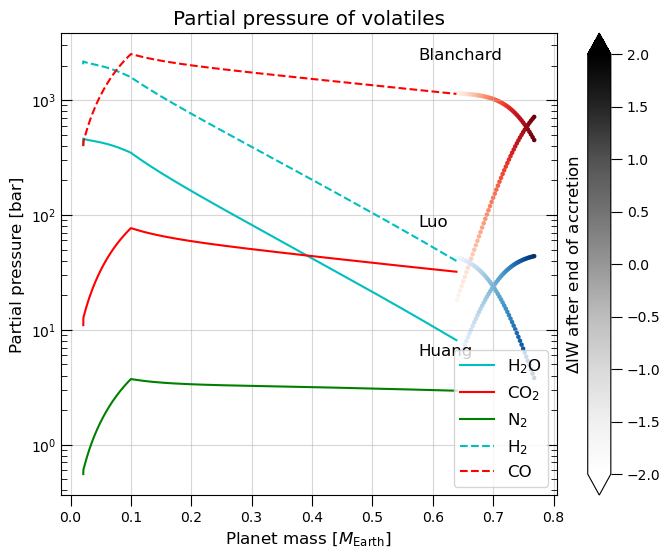

In [98]:
def IWfO2func(p, T): # oxygen fugacity of the IW-buffer Fe + O <-> FeO. Hirschmann2021. Valid for T>1000 K and P between 1e-4 and 100 GPa. "It extrapolates smoothly to higher temperature, though not calibrated above 3000 K." 
    def m(m0, m1, m2, m3, m4):
        return m0+m1*p+m2*p**2+m3*p**3+m4*p**(1/2)
    # parameters for fit to fcc (gamma-Fe) and bcc (alpha-Fe) allotropes of iron
    a = m(6.844864, 1.175691e-1, 1.143873e-3, 0, 0)
    b = m(5.791364e-4, -2.891434e-4, -2.737171e-7, 0, 0)
    c = m(-7.971469e-5, 3.198005e-5, 0, 1.059554e-10, 2.014461e-7)
    d = m(-2.769002e4, 5.285977e2, -2.919275, 0, 0)
    # parameters for fit to hcp (epsilon-Fe) allotrope of iron
    e = m(8.463095, -3.000307e-3, 7.213445e-5, 0, 0)
    f = m(1.148738e-3, -9.352312e-5, 5.161592e-7, 0, 0)
    g = m(-7.448624e-4, -6.329325e-6, 0, -1.407339e-10, 1.830014e-4)
    h = m(-2.782082e4, 5.285977e2, -8.473231e-1, 0, 0)

    hcpdomain = p>(-18.64 + 0.04359*T - 5.069e-6*T**2) # check for what p, T the iron is hcp
    def fit(P1, P2, P3, P4): # fitting function using either (a,b,c,d) or (e,f,g,h)
        return P1+P2*T+P3*T*np.log(T)+P4/T
    if cappedtemperature:
        np.where(temperature>3500, 3500, np.where(temperature>1000, temperature, 1000)) # K, approximate temperature limit for Hirschmann2021 parametrization
    log10fO2 = np.where(hcpdomain, fit(e,f,g,h), fit(a,b,c,d))
    return 10**log10fO2

def fO2func(p, T, deltaIW=deltaIW, cappedfraction=False): # oxygen fugacity 
    fO2para = IWfO2func(p, T)*10**deltaIW # fO2 as defined by Hirschmann2021 parametrization
    if cappedfraction:
        fO2max = p*cappedfraction # fO2 cannot exceed some fraction of the total pressure
        return np.where(fO2max<fO2para, fO2max, fO2para)
    else: 
        return fO2para

def gasgasfunc(Miatm, Miatmextra, amuifull, fO2, Tsurf, splitbool=True):
    xi0full = molefraction(np.concatenate((Miatm, Miatmextra)), amuifull) # initial mole fraction of each species
    xi0, xi0extra = np.split(xi0full, [len(Miatm)]) # split mole fraction into [H2O, CO2, N2] and [H2, CO]
    xwat = xi0[0]+xi0extra[0] # mole fraction of all "water"-bearing species
    xcar = xi0[1]+xi0extra[1] # mole fraction of all carbon-bearing species

    Kwat, Kcar = Kigasgas(Tsurf) # equilibrium constants for gas-gas reactions
    xH2O = xwat/(1+1/(Kwat*fO2)**(1/2))
    xCO2 = xcar/(1+1/(Kcar*fO2**(1/2)))
    xiextra = np.array([xwat-xH2O, xcar-xCO2])
    xN2 = xi0[2] 
    xi = np.array([xH2O, xCO2, xN2])
    xifull = np.concatenate((xi, xiextra))

    wifull = weightfraction(xifull, amuifull)
    Matm = Miatm[2]/wifull[2] # since N2 mass doesn't change set the total mass from the N2 weight fraction 
    Miatmfull = Matm*wifull
    # Miatmfull[2] = Miatm[2] # directly write the initial nitrogen mass
    if splitbool:
        Miatmeq, Miatmextraeq = np.split(Miatmfull, [len(Miatm)])
        oxygenmass = np.sum(Miatm-Miatmeq)+np.sum(Miatmextra-Miatmextraeq)
        print('gasgasfunc: Miatm,eq/Miatm0: '+str(Miatmeq/Miatm))
        return Miatmeq, Miatmextraeq, oxygenmass
    else:
        oxygenmass = np.sum(Miatm)+np.sum(Miatmextra)-np.sum(Miatmfull)
        return Miatmfull, xifull, wifull, oxygenmass

def Kigasgas(Tsurf): # equilibrium coefficients for gas gas specation. Direction: reduced + 1/2 O2 --> oxidized
    R = 8.31446261815324 # J/(mol*K), universal gas constant
    RT = R*Tsurf
    # Ortenzi2020. coefficients for delta G for oxygenic formation of CO, CO2 and H2O
    aH2O, bH2O, cH2O = -483095.0, 25.3687, 21.9563
    aCO, bCO, cCO = -214104.0, 25.2183, -262.1545 # units J, J/T, J/T
    aCO2, bCO2, cCO2 = -392647.0, 4.5855, -16.9762

    def fit(a, b, c):
        return a + b*Tsurf*np.log10(Tsurf) + c*Tsurf
    Gwat = fit(aH2O, bH2O, cH2O)
    Gcar = fit(aCO2, bCO2, cCO2)-1/2*fit(aCO, bCO, cCO)

    Kwat = np.exp(-Gwat/RT)
    Kcar = np.exp(-Gcar/RT)
    return Kwat, Kcar

# final masses in the atmosphere
Miatmfinal = Miatmtimearray[:, -1]
Miatmextrafinal = Miatmextratimearray[:, -1]

deltaIWlin = np.linspace(-2, 2, 50)
deltaIWplottingpoints = np.arange(deltaIWlin.min(), deltaIWlin.max(), 1)
xiatmspeciation = np.array([gasgasfunc(Miatmfinal, Miatmextrafinal, amuifull, fO2func(psurf_evo[-1], Tsurf_evo[-1], IW), Tsurf_evo[-1], splitbool=False)[1] for IW in deltaIWlin])
piatmspeciation = xiatmspeciation*psurf_evo[-1]*GPatobar # [bar]

# plt.figure()
for i in irange:
    plt.semilogy(deltaIWlin, piatmspeciation[:,i],color=vcolors[i])
for j in range(len(extragasvolatiles)):
    plt.semilogy(deltaIWlin, piatmspeciation[:,j+len(gasvolatiles)], '--', color=vcolors[j])
plt.xlabel(r"$\Delta$"+"IW")
plt.ylabel('Partial pressure [bar]')

# PLOT pi vs. protomass AGAIN. BUT WITH SPECIATION POINTS
pi_evo = np.array([GPatobar*psurf_evo[j]*molefraction(Miatmfulltimearray[:,j], amuifull) for j in range(len(timearray))]).transpose()
pi_final_extend = np.append(pi_evo[:,-1], pi_evo[2,-1])
scattercmapname = 'magma'

pifig = plt.figure(figsize=(8,6))
plt.title('Partial pressure of volatiles')
plt.ylabel('Partial pressure [bar]')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
ax1 = plt.gca()

for i in irange:
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[i][longstartind:longstopind], '-', color=vcolors[i], label=fullgasvolatiles[i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        ax1.scatter(protomasstimearray[longstopind]*(1+np.abs(deltaIWlin-deltaIW)/20)/earthmass, piatmspeciation[:,i], c=deltaIWlin, cmap=volatilecolorstyles[i], vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=5)
    ax1.text(0.90*protomasstimearray[longstopind]/earthmass, 2*np.max((pi_final_extend[i], pi_final_extend[i+len(volatiles)])), Ppaperlabel[i][3:])

for i in range(len(extragasvolatiles)):
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[len(volatiles)+i][longstartind:longstopind], '--',  color=vcolors[i], label=fullgasvolatiles[len(volatiles)+i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        SC = ax1.scatter(protomasstimearray[longstopind]*(1+np.abs(deltaIWlin-deltaIW)/20)/earthmass, piatmspeciation[:,i+len(gasvolatiles)], c=deltaIWlin, cmap=volatilecolorstyles[i], vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=5)

SCdummy = ax1.scatter(protomasstimearray[longstopind]*(1+np.abs(deltaIWlin)/20)/earthmass, piatmspeciation[:,i+len(gasvolatiles)], c=deltaIWlin, cmap='Greys', vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=0)
ax1.tick_params(axis='y', which='major', direction='in', size=8)
ax1.tick_params(axis='y', which='minor', direction='in', size=4)

# Put minor ticks
# y_major = mpl.ticker.LogLocator(base = 10.0, numticks = 100)
# y_minor = mpl.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 100)
# ax1.yaxis.set_major_locator(y_major)
# ax1.yaxis.set_minor_locator(y_minor)

scattercbar = pifig.colorbar(SCdummy, label="$\Delta$IW after end of accretion", extend='both')
scattercbar.ax.yaxis.set_label_position("left")
ax1.legend()
scattercbar.ax.tick_params(axis='y', which='major', direction='out', size=8)
scattercbar.ax.tick_params(axis='y', which='minor', direction='out', size=4)

# if plotsaving:
#     pifig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/piatm.png', bbox_inches='tight', dpi=200)

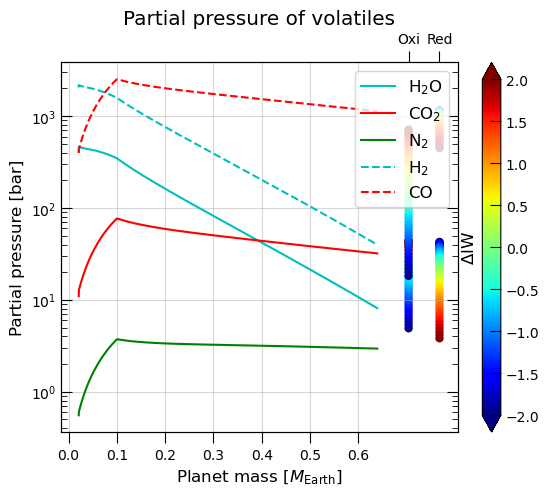

In [99]:
# PLOT pi vs. protomass AGAIN. BUT WITH SPECIATION POINTS
pi_evo = np.array([GPatobar*psurf_evo[j]*molefraction(Miatmfulltimearray[:,j], amuifull) for j in range(len(timearray))]).transpose()
scattercmapname = 'jet'
# scattercmap = plt.get_cmap(scattercmapname)
# scattercmap = cmap.from_list(scattercmapname, scattercmap.__call__(np.linspace(0.2, 1, 100)), 100)


pifig = plt.figure()
plt.title('Partial pressure of volatiles')
plt.ylabel('Partial pressure [bar]')
plt.xlabel('Planet mass '+r'$[M_\mathrm{Earth}]$')
plt.grid(alpha=0.5)
ax1 = plt.gca()
axtwiny = ax1.twiny()

for i in irange:
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[i][longstartind:longstopind], '-', color=vcolors[i], label=fullgasvolatiles[i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        ax1.scatter(np.repeat(protomasstimearray[longstopind]*1.1/earthmass, len(piatmspeciation[:,i])), piatmspeciation[:,i], c=deltaIWlin, cmap=scattercmapname, vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=25)

for i in range(len(extragasvolatiles)):
    ax1.semilogy(protomasstimearray[longstartind:longstopind]/earthmass, pi_evo[len(volatiles)+i][longstartind:longstopind], '--',  color=vcolors[i], label=fullgasvolatiles[len(volatiles)+i])
    # Plot final speciation options
    if not (i==2): # nitrogen doesn't speciate
        SC = ax1.scatter(np.repeat(protomasstimearray[longstopind]*1.2/earthmass, len(piatmspeciation[:,i])), piatmspeciation[:,i+len(gasvolatiles)], c=deltaIWlin, cmap=scattercmapname, vmin=deltaIWlin.min(), vmax=deltaIWlin.max(), s=25)
scattercbar = pifig.colorbar(SC, label="$\Delta$IW", extend='both')
scattercbar.ax.yaxis.set_label_position("left")
ax1.legend()
ax1.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

axtwiny.set_xlim(ax1.get_xlim())
axtwiny.set_xticks(protomasstimearray[longstopind]/earthmass*np.array([1.1, 1.2]), ['Oxi', 'Red'])

Text(0.5, 1.0, 'Product')

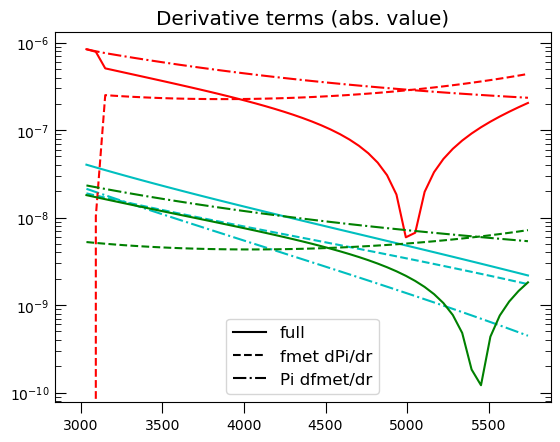

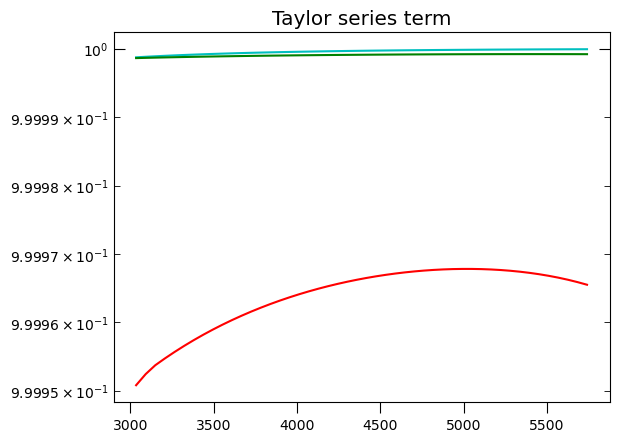

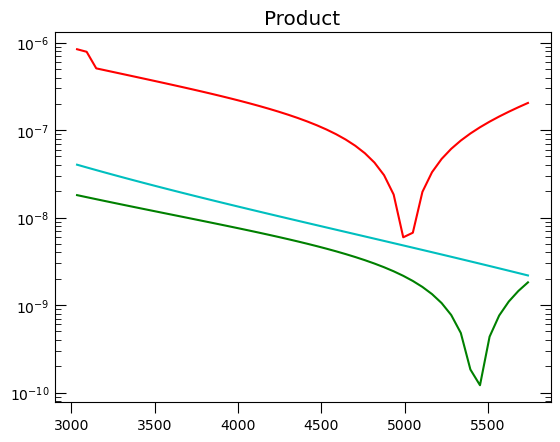

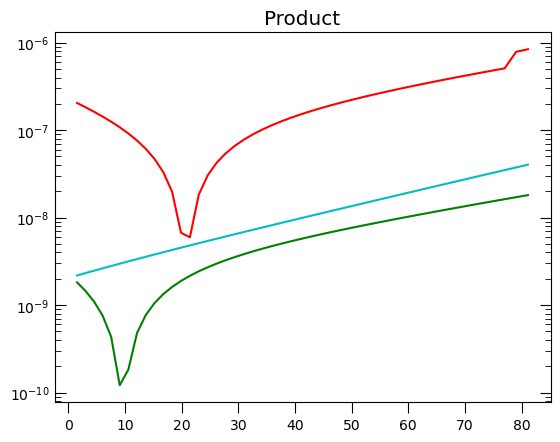

In [100]:
dr = rk[1]-rk[0] # all are the same
fmet = Mmet/Msil
Uik = Pvol*fmet
Vik = np.array([centeraveraging(U) for U in Uik]) # at all the middle layer boundaries (excludes surface and cmb)
dPdr = np.array([delta(P) for P in Pvol])/dr # -||-
dfdr = delta(fmet)/dr # -||-
series4 = 1-2*Vik+3*Vik**2-4*Vik**3+5*Vik**4

derterm = dr*dPdr*centeraveraging(fmet)+dr*dfdr*np.array([centeraveraging(P) for P in Pvol])
derterm2 = dr*dPdr*centeraveraging(fmet)

plt.figure()
for i in irange:
    plt.semilogy(rk[1:-1], abs(derterm[i]), color=vcolors[i])
    plt.semilogy(rk[1:-1], abs(derterm2[i]), '--', color=vcolors[i])
    plt.semilogy(rk[1:-1], abs(derterm[i]-derterm2[i]), '-.', color=vcolors[i])
plt.semilogy(rk[0], derterm[0,0],'-',color='k', label='full')
plt.semilogy(rk[0], derterm[0,0],'--',color='k', label='fmet dPi/dr')
plt.semilogy(rk[0], derterm[0,0],'-.',color='k', label='Pi dfmet/dr')

plt.title('Derivative terms (abs. value)')
plt.legend()

plt.figure()
for i in irange:
    plt.semilogy(rk[1:-1], abs(series4[i]), color=vcolors[i])
plt.title('Taylor series term')

plt.figure()
for i in irange:
    plt.semilogy(rk[1:-1], abs(derterm[i]*series4[i]), color=vcolors[i])
plt.title('Product')

plt.figure()
for i in irange:
    plt.semilogy(centeraveraging(pressure), abs(derterm[i]*series4[i]), color=vcolors[i])
plt.title('Product')




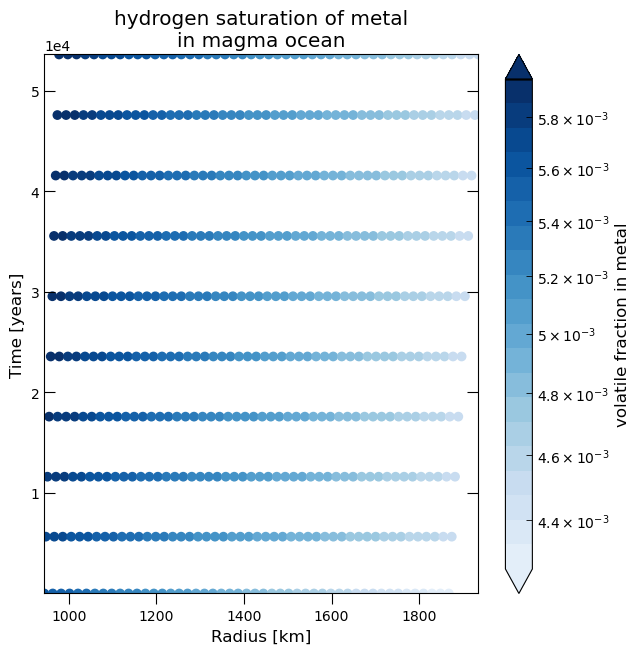

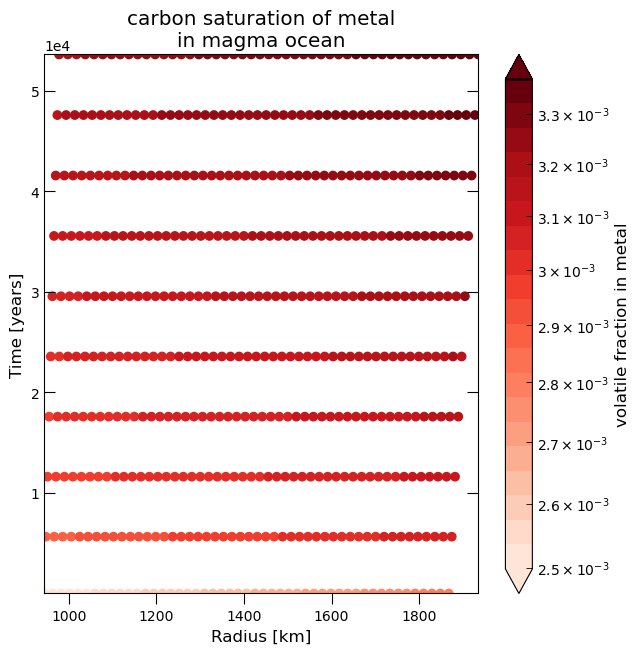

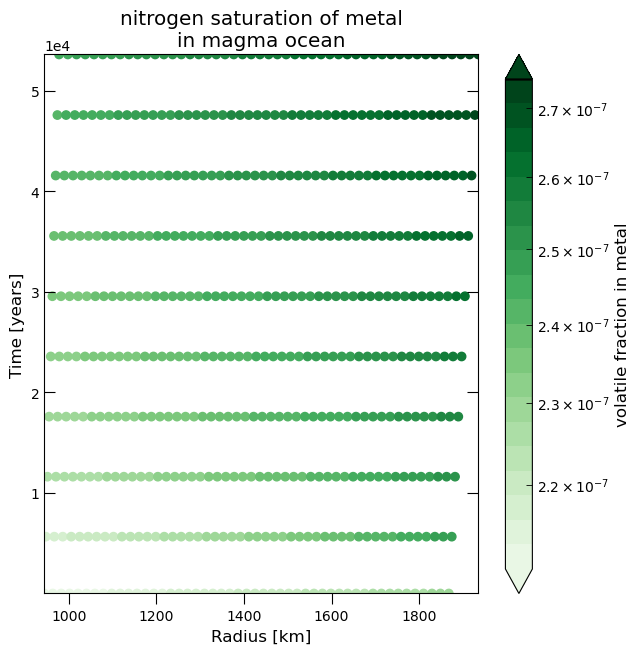

In [101]:
Mmettimeplotmatrix = np.transpose(np.transpose(np.ones_like(Mtotfromfile))*Mmettimeplotarray)

Msiltimeplotarray = (Mtotfromfile-np.sum(Mvolfromfile, axis=1))-Mmettimeplotmatrix
wrongaxvolmetsattimeplotarray = np.array([Mvolfromfile[:,i]*Pvolfromfile[:,i]/(Msiltimeplotarray+Pvolfromfile[:,i]*Mmettimeplotmatrix) for i in irange])
volmetsattimeplotarray = np.swapaxes(wrongaxvolmetsattimeplotarray, 0, 1)

timeplotmatrix = np.tile(timeplotarray, (len(rkfromfile[0]), 1)).transpose()
for i in irange:
    colorfig = plt.figure(figsize=(7,7))
    cmap = plt.get_cmap(volatilecolorstyles[i])
    cmap = cmap.from_list(volatilecolorstyles[i], cmap.__call__(np.linspace(0.1, 1, 20)), 20)
    y = volmetsattimeplotarray[:,i]
    CS = plt.scatter(rkfromfile[0:10], timeplotmatrix[0:10], c=y[0:10], cmap=cmap, norm=mplcolors.LogNorm(vmin=y[0:10].min(), vmax=y[0:10].max()))
    plt.title(volatiles[i]+' saturation of metal'+'\n'+'in magma ocean')
    colorax = plt.gca()
    colorax.set_xlabel('Radius [km]')
    colorax.set_ylabel('Time [years]')
    colorax.ticklabel_format(style='sci', axis='y', scilimits=(0,3))
    cbar = colorfig.colorbar(CS, label='volatile fraction in metal', extend='both')
    # cbar.ax.yaxis.set_label_position("left")
    contourlevels = np.array([0.01, 0.05, 0.10, 0.15])
    contour = colorax.contour(rkfromfile[0:10], timeplotmatrix[0:10], y[0:10], levels=contourlevels, colors='k', linewidths=1)
    cbar.add_lines(levels=contour.levels, colors=['k' for _ in contour.levels], linewidths=[1 for _ in contour.levels])


[41.6120501  16.3272618   8.2552045  27.59940074] [41.9  16.28  8.13 27.6 ]
Blanchard; D_C,meas.: [141  65  23 157] . D_C,func [ 68.51560133  71.69683756  64.07176189 122.45399913]
XFeO: [0.39211247 0.25173458 0.32317073 0.43162107]
XFe: [0.7962963  0.85666293 0.74298056 0.85165975]
deltaIW: [-0.61532809 -1.06373421 -0.72309086 -0.59032698]
Fischer's EPMA:
 meas.:  [ 8.7178797  38.16743357 10.22786177  9.57592064] .
 func.: [ 7.00621538  5.14356481  1.99950144 14.77532212]
Fischer's nanoSIMS:
 meas.:  [1.29265113 3.65079799 1.23974082 1.49477786] .
 func.: [1.81804226 2.39940662 0.39298738 4.74824582]


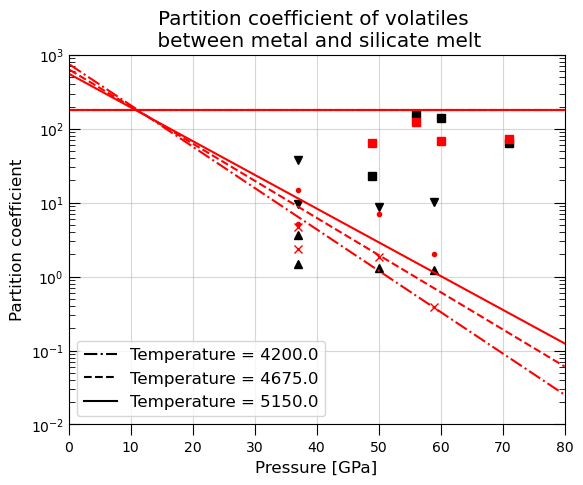

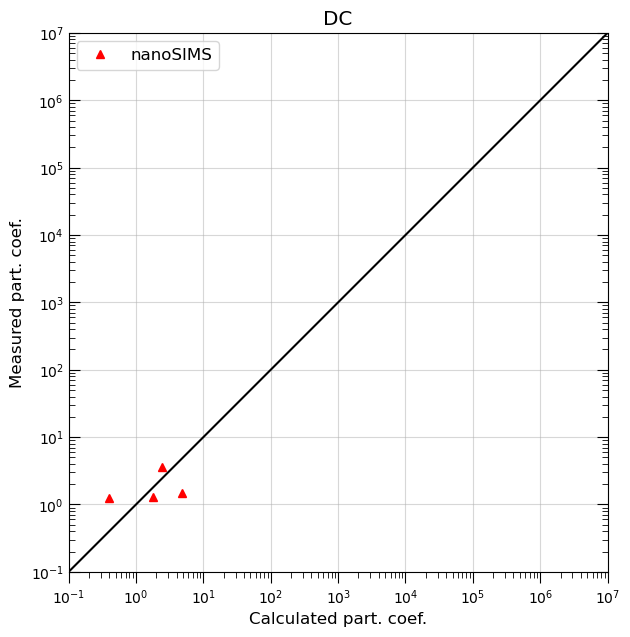

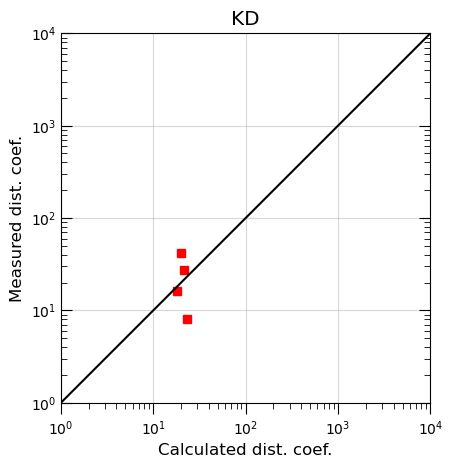

In [ ]:
# Blanchard data points
pBlanchard = np.array([60, 71, 49, 56]) 
TBlanchard = np.array([3800, 4000, 3600, 3700])
IWBlanchard = np.array([-1.06, -1.2, -0.89, -1.51])
DcBlanchard = np.array([141, 65, 23, 157])
KDBlanchard = np.array([41.9, 16.28, 8.13, 27.6])

# Blanchard fit
DcBlanchardfunc = PCfuncBlanchard(pBlanchard, TBlanchard, IWBlanchard)
KDBlanchardfunc = DcBlanchardfunc*10**(IWBlanchard/2)

print('Blanchard; D_C,meas.:', DcBlanchard, '. D_C,func', DcBlanchardfunc)

# Fischer data points
EPMAsil = np.array([97.166, 96.133, 98.4, 98.466]) # Sum of all mass fractions (unnormalized) to 100
XcsilEPMA = np.array([0.86, 0.22, 0.80, 0.64])/EPMAsil
XFeOEPMA = np.array([38.1, 24.2, 31.8, 42.5])/EPMAsil
XcsilNANO = np.array([5.8, 2.3, 6.6, 4.1])/EPMAsil

EPMAmet = np.array([97.2, 89.3, 92.6, 96.4])
XcmetEPMA = np.array([7.5, 7.8, 7.7, 6.0])/EPMAmet
XFeEPMA = np.array([77.4, 76.5, 68.8, 82.1])/EPMAmet
XometEPMA = np.array([6.2, 1.9, 7.9, 4.8])/EPMAmet
XsmetEPMA = np.array([0, 0, 0, 0])/EPMAmet # ?

deltaIWFischer = 2*np.log10(XFeOEPMA/XFeEPMA) # calc. deltaIW 
print('XFeO:', XFeOEPMA)
print('XFe:', XFeEPMA)
print('deltaIW:',deltaIWFischer)

DcEPMA = XcmetEPMA/XcsilEPMA # calculate the partition coefficient that was measured by EPMA
DcNANO = XcmetEPMA/XcsilNANO # calculate the partition coefficient that was measured by nanoSIMS

# Fischer fit
pFischer = np.array([50, 37, 59, 37])
TFischer = np.array([5150, 4350, 4200, 4950])
DcEPMAFunc = PCfuncFischer(pFischer, TFischer, Xoxygen=XometEPMA, deltaIW=deltaIWFischer, microprobe=True)
DcNANOFunc = PCfuncFischer(pFischer, TFischer, Xoxygen=XometEPMA, deltaIW=deltaIWFischer, microprobe=False)

print("Fischer's EPMA:\n meas.: ", DcEPMA, '.\n func.:', DcEPMAFunc)

print("Fischer's nanoSIMS:\n meas.: ", DcNANO, '.\n func.:', DcNANOFunc)

fitcomparisonfig = plt.figure()
plt.grid(alpha=0.5)
plt.xlabel('Pressure [GPa]')
plt.ylabel('Partition coefficient')
plt.title('Partition coefficient of volatiles \n between metal and silicate melt')
plt.gca().set_xlim(left=0, right=80)
plt.gca().set_ylim([1e-2, 1e3])
plt.semilogy(pBlanchard, DcBlanchard,'s', color='k')
plt.semilogy(pBlanchard, DcBlanchardfunc,'s',color='r')
plt.semilogy(pFischer, DcEPMA, 'v', color='k')
plt.semilogy(pFischer, DcNANO, '^', color='k')
plt.semilogy(pFischer, DcEPMAFunc, '.', color='r')
plt.semilogy(pFischer, DcNANOFunc, 'x', color='r')

plin = np.linspace(0.2, 80, number_of_layers)
Tlin = np.linspace(4200, 5150, 3)
temperaturelinestyles = ['-.','--','-']

for Tind in range(len(Tlin)):
    PClinold = PCfuncFischer(plin, Tlin[Tind], microprobe=False)
    PClinoldEPMA = PCfuncFischer(plin, Tlin[Tind], microprobe=True)
    PClin = PCfuncBlanchard(plin, Tlin[Tind], valence=2)
    plt.semilogy(plin, PClinold, color=vcolors[1], linestyle=temperaturelinestyles[Tind])
    # plt.semilogy(plin, PClinoldEPMA, color='orange', linestyle=temperaturelinestyles[Tind])
    plt.semilogy(plin, PClin, color=vcolors[1], linestyle=temperaturelinestyles[Tind])
    plt.semilogy(0, 0, label='Temperature = '+str(Tlin[Tind]), color='k', linestyle=temperaturelinestyles[Tind%len(temperaturelinestyles)])
plt.legend()

fitcomparisonfig.savefig('Plots/ResultPlots'+Ppaperlabel[1]+'/PCfitcomparison.png', bbox_inches='tight', dpi=200)

plt.figure(figsize=(7,7))
plt.title('DC')
plt.grid(alpha=0.5)
plt.xlabel('Calculated part. coef.')
plt.ylabel('Measured part. coef.')
plt.gca().set_xlim([1e-1, 1e7])
plt.gca().set_ylim([1e-1, 1e7])
# plt.loglog(DcBlanchardfunc, DcBlanchard, 's', color='r', label='Blanchard')
# plt.loglog(DcEPMAFunc, DcEPMA, 'v', color='r', label='EPMA')
plt.loglog(DcNANOFunc, DcNANO, '^', color='r', label='nanoSIMS')
plt.loglog(np.logspace(-1, 7, 50), np.logspace(-1, 7, 50), '-', color='k')
plt.gca().set_aspect(1)
plt.legend()

plt.figure()
plt.title('KD')
plt.grid(alpha=0.5)
plt.xlabel('Calculated dist. coef.')
plt.ylabel('Measured dist. coef.')
plt.gca().set_xlim([1e-0, 1e4])
plt.gca().set_ylim([1e-0, 1e4])
plt.loglog(KDBlanchardfunc, KDBlanchard, 's', color='r')
plt.loglog(np.logspace(0, 4, 50), np.logspace(0, 4, 50), '-', color='k')
plt.gca().set_aspect(1)




In [103]:
# Mass of C+O2 (as AnatomyIII, fig. 5)
print(Miatmplusmantle[1, 0]*10**15*1e-3, ' kg equiv. Carbon at start') # MC in kg at start
print(Miatmplusmantle[1, -1]*10**15*1e-3, ' kg equiv. Carbon at end') # MC in kg at end
print(Miatmequivsumtimearray[1,-1]*10**15*1e-3, ' kg equiv. Carbon in atmosphere at end')
print(Mimagma[-1, 1]*10**15*1e-3, ' kg equiv. Carbon in MO at end')
print(Micoretimearray[1, -1]*10**15*1e-3, ' kg equiv. Carbon in core at end')

atmpercentvolatiles = Miatmequivsumtimearray/np.sum(Miatmequivsumtimearray, axis=0)
print(atmpercentvolatiles[:,-1])
# print(12/44*Miatmplusmantle[1, 0]*10**15*1e-3, ' kg Carbon at start') # MC in kg at start
# print(12/44*Miatmplusmantle[1, -1]*10**15*1e-3, ' kg Carbon at end') # MC in kg at end
# print(12/44*Miatmequivsumtimearray[1,-1]*10**15*1e-3, ' kg Carbon in atmosphere at end')
# print(12/44*Mimagma[-1, 1]*10**15*1e-3, ' kg Carbon in MO at end')
print(12/44*Micoretimearray[1, -1]*10**15*1e-3, ' kg Carbon in core at end')
 
# mixing ratio check
print(protomasstimearray[0]*10**15*1e-3, 'kg starting planet mass. ', protomasstimearray[0]/earthmass, ' Earth masses')
print(protomasstimearray[-1]*10**15*1e-3, 'kg stopping planet mass. ', protomasstimearray[-1]/earthmass, ' Earth masses')
print(Mctimearray[-1]*10**15*1e-3, 'kg core mass at end. ', Mctimearray[-1]/earthmass, ' Earth masses')



4.370122246178154e+21  kg equiv. Carbon at start
1.0571854760346693e+22  kg equiv. Carbon at end
1.0365701630750181e+22  kg equiv. Carbon in atmosphere at end
1.2652097645594268e+20  kg equiv. Carbon in MO at end
1.0286708230339336e+22  kg equiv. Carbon in core at end
[0.0164326  0.98198533 0.00158207]
2.805465881001637e+21  kg Carbon in core at end
1.2621941589312442e+23 kg starting planet mass.  0.021138031868489487  Earth masses
3.8209048594186365e+24 kg stopping planet mass.  0.6398889434985658  Earth masses
1.1511417606892027e+24 kg core mass at end.  0.19278231522796133  Earth masses


In [104]:
MH2Otot0 = 2e3*1e-6*earthmass # Fig. 11, AnatomyIII.
MH2Otottest = 710*(1-coremassfraction)*1e-6*earthmass

print(MH2Otot0/earthmass, MH2Otottest/earthmass, MH2Otot0/MH2Otottest)

MNtot0 = 10**0.5*1e-6*earthmass # mass fraction of total planet mass of Venus in atmosphere, from same figure in AnatomyIII
MNtottest = 2.8*(1-coremassfraction)*1e-6*earthmass
print(MNtot0/earthmass, MNtottest/earthmass, MNtot0/MNtottest)

0.002 0.0004969999999999999 4.024144869215292
3.162277660168379e-06 1.9599999999999994e-06 1.6134069694736632


Estimated core carbon: 0.0016323713425824074
Estimated core carbon deposited after Psurf,max: 0.0016323713425824074
Upper limit of core carbon without Taylor approx.: 0.0016431298184682865
Actual core carbon: 0.0017227204297861965


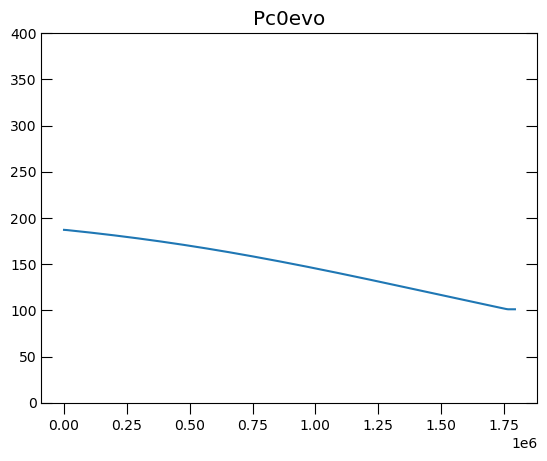

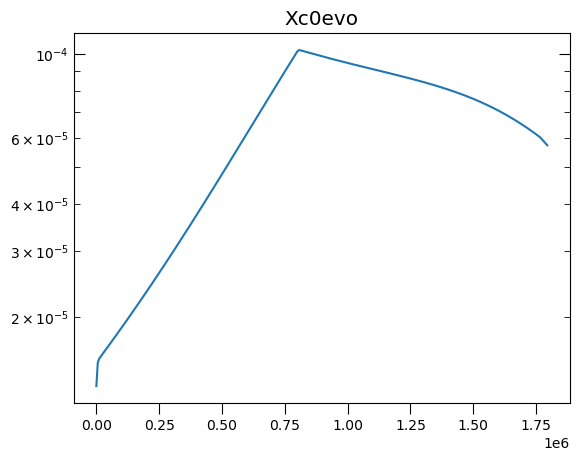

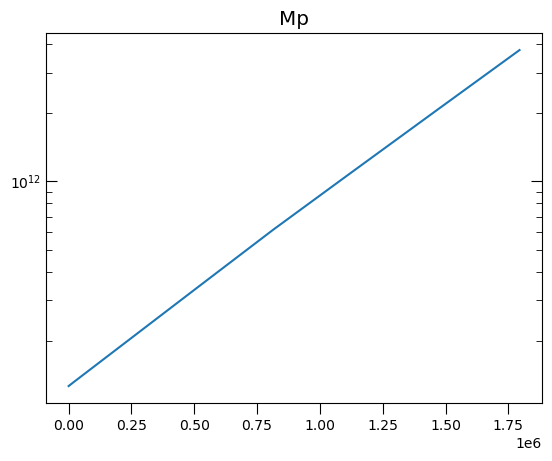

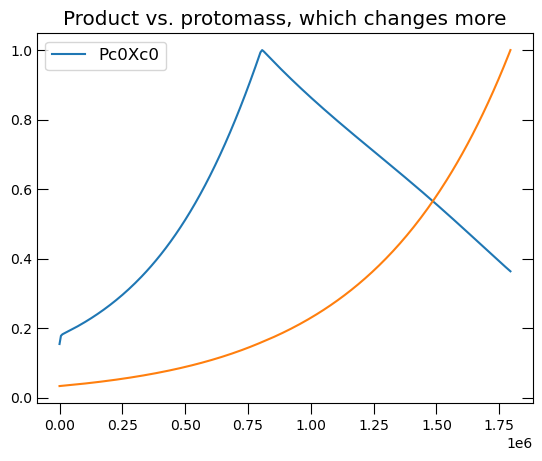

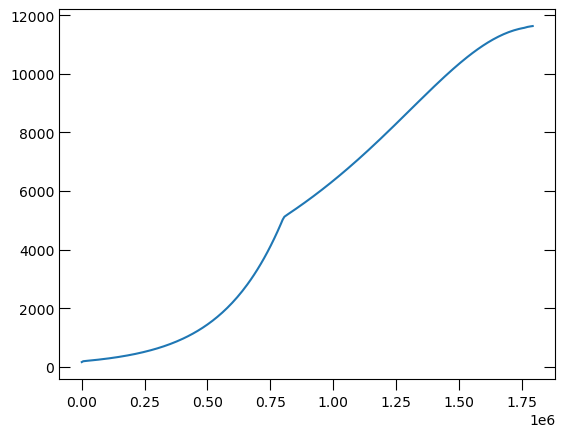

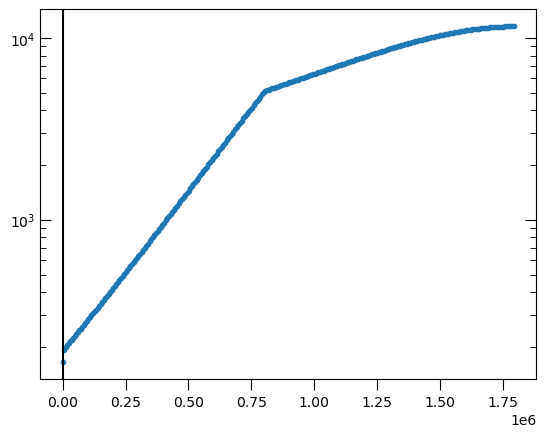

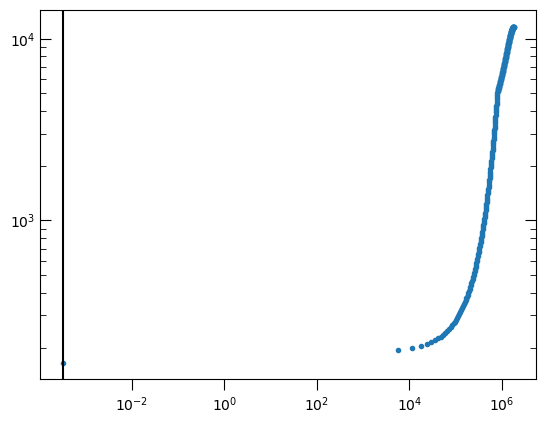

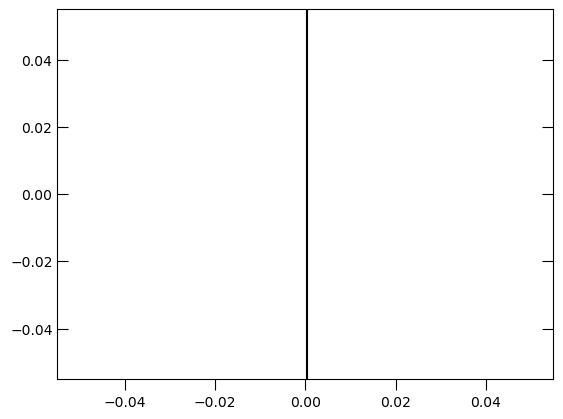

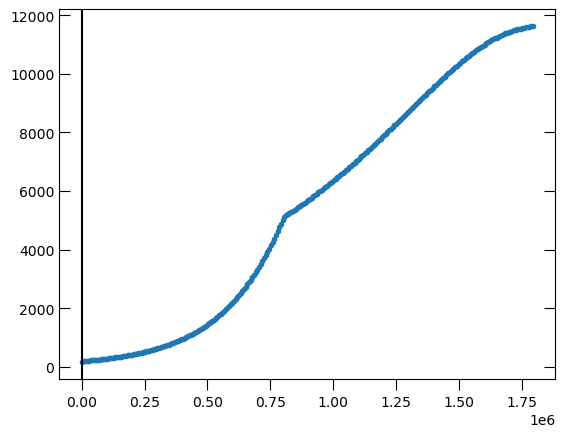

In [105]:
Pc0evo = Pvolfromfile[:,1,0]
plt.plot(timeplotarray, Pc0evo)
plt.title('Pc0evo')
plt.gca().set_ylim([0, 400])

Xc0evo = Mvolfromfile[:,1,0]/Mtotfromfile[:,0]
plt.figure()
plt.title('Xc0evo')
plt.semilogy(timeplotarray[shortstartind:], Xc0evo[shortstartind:])

plt.figure()
plt.title('Mp')
plt.semilogy(timeplotarray[shortstartind:], protomasstimeplotarray[shortstartind:])

Pc0Xc0 = Pc0evo*Xc0evo
plt.figure()
plt.title('Product vs. protomass, which changes more')
plt.plot(timeplotarray[shortstartind:], Pc0Xc0[shortstartind:]/np.max(Pc0Xc0[shortstartind:]), label='Pc0Xc0')
plt.plot(timeplotarray[shortstartind:], protomasstimeplotarray[shortstartind:]/protomasstimeplotarray[-1])
plt.legend()

integrand = Pc0Xc0*protomasstimeplotarray
coef = 0.3/(5*1e6/np.log(1e4*0.7)) # coefficient in front of integral
plt.figure()
plt.plot(timeplotarray[shortstartind:], coef*integrand[shortstartind:])

plt.figure()
integrand = Pc0Xc0*protomasstimeplotarray
plt.semilogy(timeplotarray, coef*integrand,'.')
plt.axvline(timeplotarray[shortstartind], color='k')

plt.figure()
plt.loglog(timeplotarray, coef*integrand,'.')
plt.axvline(timeplotarray[shortstartind], color='k')

plt.figure()
plt.plot(timeplotarray[:shortstartind], coef*integrand[:shortstartind],'.')
plt.axvline(timeplotarray[shortstartind], color='k')

plt.figure()
plt.plot(timeplotarray[shortstartind:], coef*integrand[shortstartind:],'.')
plt.axvline(timeplotarray[shortstartind], color='k')

integral = np.trapz(integrand, x=timeplotarray)
shortintegral = np.trapz(integrand[shortstartind:], x=timeplotarray[shortstartind:])

result = coef*integral
shortresult = coef*shortintegral

fullintegrand = protomasstimeplotarray*Pc0evo*Mvolfromfile[:,1,0]/(Pc0evo*Mmettimeplotarray+Msiltimeplotarray[:,0])
fullintegral = coef*np.trapz(fullintegrand, x=timeplotarray)

print("Estimated core carbon:", result/earthmass)
print("Estimated core carbon deposited after Psurf,max:", shortresult/earthmass)
print("Upper limit of core carbon without Taylor approx.:", fullintegral/earthmass)
print("Actual core carbon:", Micoretimearray[1, -1]/earthmass)

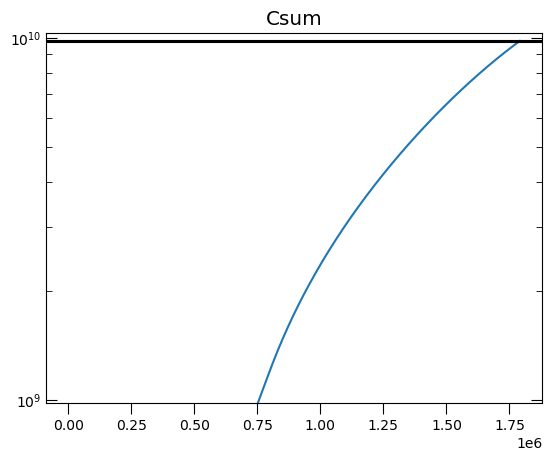

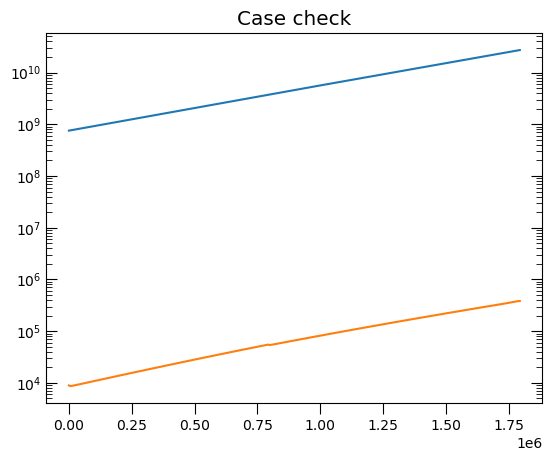

In [106]:
fullintegrand = protomasstimeplotarray*Pc0evo*Mvolfromfile[:,1,0]/(Pc0evo*Mmettimeplotarray+Msiltimeplotarray[:,0])
fullintegral = coef*np.trapz(fullintegrand, x=timeplotarray)

# SAME RESULT. Taylor approx. is valid.
# taylorintegrand = protomasstimeplotarray*Pc0evo*Mvolfromfile[:,1,0]/(Msiltimeplotarray[:,0])
# taylorintegral = coef*np.trapz(taylorintegrand, x=timeplotarray)

from scipy.integrate import cumulative_trapezoid as cumtrapz

fullcsum = coef*cumtrapz(fullintegrand,x=timeplotarray)  
plt.figure()
plt.title('Csum')
plt.semilogy(centeraveraging(timeplotarray), fullcsum)
plt.axhline(fullintegral, color='k')
plt.axhline(result, color='k')
plt.gca().set_ylim(fullintegral*1e-1, fullintegral*1.05)


plt.figure()
plt.title('Case check')
plt.semilogy(timeplotarray, Msiltimeplotarray[:,0])
plt.semilogy(timeplotarray, Mmettimeplotarray*Pc0evo)

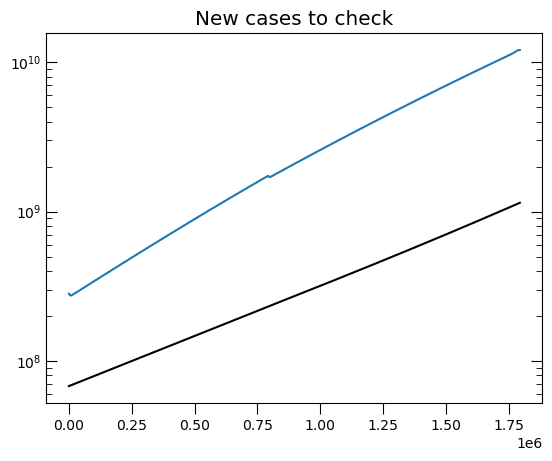

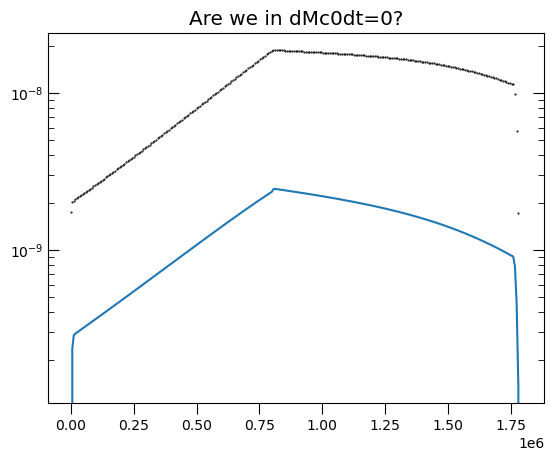

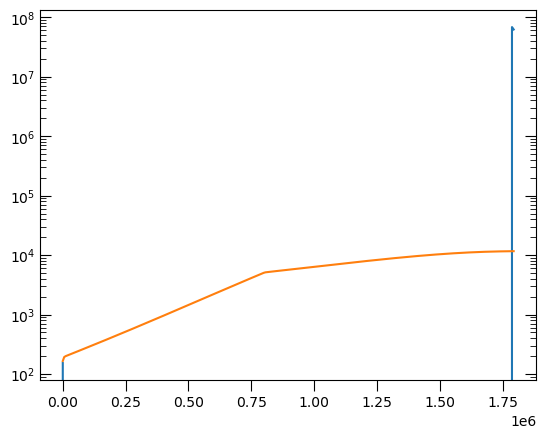

In [107]:
# DERIVED dMdt = 0 --> dPdr \propto dXdr

Xc1evo = Mvolfromfile[:,1,1]/Mtotfromfile[:,1] # check concentration in second deepest magma ocean layer
Pc1evo = Pvolfromfile[:,1,1] # check 

dXc0dr = (Xc1evo-Xc0evo)/(rkfromfile[:,1]-rkfromfile[:,0])
dPc0dr = (Pc1evo-Pc0evo)/(rkfromfile[:,1]-rkfromfile[:,0])

plt.figure()
plt.title('New cases to check')
plt.semilogy(timeplotarray, vmet*Mmettimeplotarray*Pc0evo)

diffusivitytimeplotarray = np.interp(timeplotarray, timearray, diffusivitytimearray)
rhosil0evo = Msiltimeplotarray[:,0]/(4*pi*rkfromfile[:,1]**3-rkfromfile[:,0]**3/3)
plt.semilogy(timeplotarray, 4*pi*diffusivitytimeplotarray**rhosil0evo*rkfromfile[:,1]**2, color='k')

plt.figure()
plt.title('Are we in dMc0dt=0?')

plt.semilogy(timeplotarray[shortstartind:], -dXc0dr[shortstartind:])
# plt.semilogy(Xc0evo)
plt.semilogy(timeplotarray[shortstartind:], vmet*Mmettimeplotarray[shortstartind:]*Xc0evo[shortstartind:]*dPc0dr[shortstartind:]/(vmet*Mmettimeplotarray[shortstartind:]*Pc0evo[shortstartind:]+4*pi*D**rhosil0evo[shortstartind:]*rkfromfile[shortstartind:,1]**2),'.',markersize=1, color='k')

# Calculate dMdt actually
dMc0dt = (vmet*Mmettimeplotarray*Pc0evo+4*pi*diffusivitytimeplotarray*rhosil0evo*rkfromfile[:,1]**2)*dXc0dr+vmet*Mmet*Xc0evo*dPc0dr
dMc0dtfirstterm = (vmet*Mmettimeplotarray*Pc0evo+4*pi*diffusivitytimeplotarray*rhosil0evo*rkfromfile[:,1]**2)*dXc0dr
dMc0dtsecondterm = dMc0dt-dMc0dtfirstterm 

plt.figure()
plt.semilogy(timeplotarray, dMc0dt)
plt.semilogy(timeplotarray, integrand*coef)
# plt.semilogy(timeplotarray, -dMc0dtfirstterm, '.', color='orange')
# plt.semilogy(timeplotarray, dMc0dtsecondterm, '.', color='k')


In [108]:
Mctimeplotarray = np.interp(timeplotarray, timearray, Mctimearray)
Mccoretimeplotarray = np.interp(timeplotarray, timearray, Micoretimearray[1])
print("M_c:", Mctimeplotarray[:3])
print("V_c*rho_c", 4/3*pi*rkfromfile[:3,0]**3*coremetaldensity)
print("M_c,carbon", Mccoretimeplotarray[:3])


M_c: [3.58272000e+10 3.62269878e+10 3.66541885e+10]
V_c*rho_c [3.69450131e+10 3.73569764e+10 3.77976376e+10]
M_c,carbon [5.36439719e-02 1.07903568e+06 2.31749724e+06]


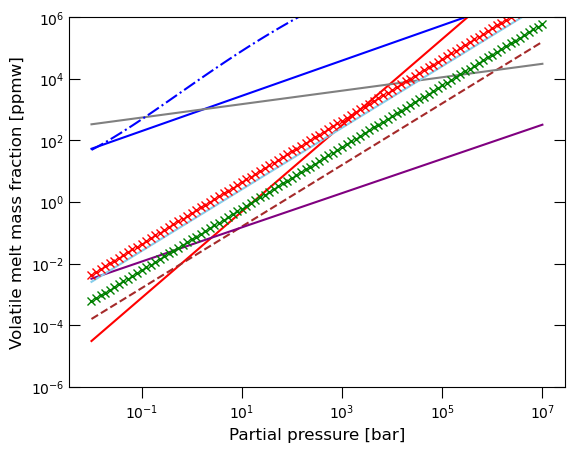

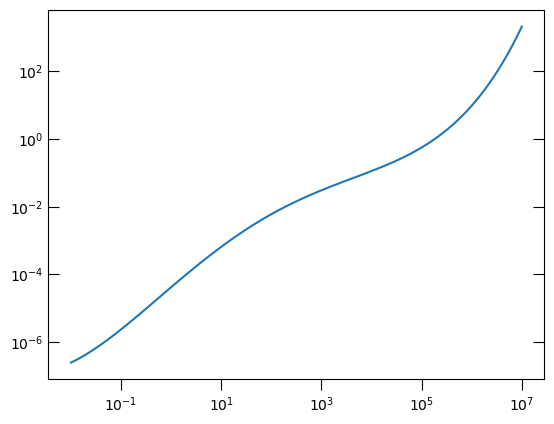

In [109]:
psurflog = np.logspace(-2, 7, 100) # bar

alphaH2O, betaH2O = 1.033e0, 1.747
alphaH2, betaH2 = 2.572e-6, 1

alphaCO2, betaCO2 = 1.937e-9, 0.714
alphaCO, betaCO = 1.6e-7, 1

alphaNred, betaNred = 7.416e1, 4.582
alphaNoxi, betaNoxi = 7.000e-5,	1.800

def XiLichtenberg(psurfbar, alpha, beta):
    psurfPa = psurfbar*1e5 # convert from bar to Pa
    return alpha*psurfPa**(1/beta)

def XNBernadou(psurfbar, Tsurf, fO2surf=fO2surf0):    
    R = 8.31446261815324 # J/(mol*K), universal gas constant
    KN2phys = np.exp(-(29344+121*Tsurf+4*psurfbar)/(R*Tsurf)) # Bernadou2021, eq. 13 & Table 6.
    KN2chem = (np.exp(-(183733+172*Tsurf-5*psurfbar)/(R*Tsurf))) # Bernadou2021, eq. 14 & Table 6.
    XN = KN2phys*psurfbar+KN2chem*psurfbar**(1/2)*fO2surf**(-3/4)
    return XN

def XH2Oburnham(psurfbar, Tsurf=1500):
    KH2Ointermediate = 0.2 # Stolper1982, fig. 4. approximate equilibrium constant for intermediate water dissolution step H2O(g) -> H2O(m)
    psurfbartrue = psurfbar
    # psurfbar = np.where(psurfbar<1e-2, psurfbar, 1e-2) # show why the curve slopes steeper
    KH2Oburnham = KH2Ointermediate*1/(np.exp(5.00+np.log(psurfbar)*(4.481e-8*Tsurf**2-1.51e-4*Tsurf-1.137)+np.log(psurfbar)**2*(1.831e-8*Tsurf**2-4.882e-5*Tsurf+4.656e-2)+7.80e-3*np.log(psurfbar)**3-5.012e-4*np.log(psurfbar)**4+Tsurf*(4.754e-3-1.621e-6*Tsurf))) # Burnham 1994, eq. 7. Taken to power -1 because their K is defined for the inverse reaction. PLACEHOLDER INCORRECT. IS ONLY EQ. CONST FOR THE H2O(melt)+O->2 OH(melt) REACTION!
    return (psurfbartrue*KH2Oburnham)**(1/2), KH2Oburnham


plt.figure()
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaH2O, betaH2O), color='blue')
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaCO2, betaCO2), color='r')
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaCO, betaCO), '--', color='brown')
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaNred, betaNred), color='grey')
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaNoxi, betaNoxi), color='purple')
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaH2, betaH2), color='skyblue')
plt.loglog(psurflog, 1e6*XH2Oburnham(psurflog)[0], '-.', color='blue')

# plt.gca().set_xlim(1, 1e4)
# plt.gca().set_ylim(1e-3, 1e4)
# plt.loglog(psurflog, 1e6*XNBernadou(psurflog, 1500),'.', color='g')
# plt.loglog(psurflog, 1e6*XNBernadou(psurflog, Tsurf, 10**deltaIW),'x')
# plt.loglog(psurflog, 1e6*XNBernadou(psurflog, 1500, 1e-7),'x')
plt.loglog(psurflog, 1e6*6.11*1e-13*(psurflog*1e5),'x', color='g') # 1e5 for conversion from bar to Pa
plt.loglog(psurflog, 1e6*4.4e-12*(psurflog*1e5), 'x', color='r')

plt.gca().set_ylim(top=1e6, bottom=1e-6)
plt.xlabel('Partial pressure [bar]')
plt.ylabel('Volatile melt mass fraction [ppmw]')

plt.figure()
plt.loglog(psurflog, XH2Oburnham(psurflog)[1])

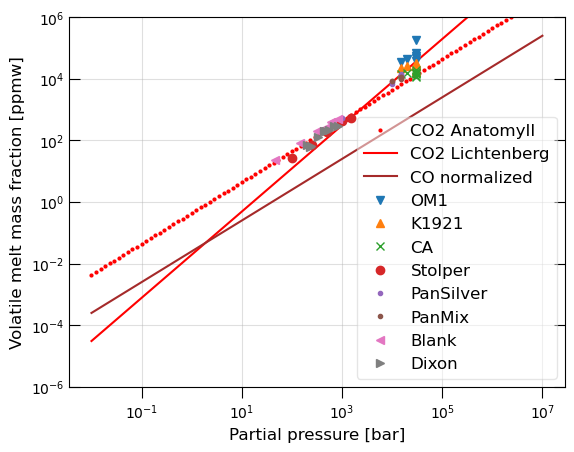

In [110]:
# Plot solubility fits:

plt.figure()
# plt.loglog(psurflog, 1e-1*1e6*4.4e-12*(psurflog*1e5), 'o', color='r', label='Carbon AnatomyII', markersize=2)
# plt.loglog(psurflog, XiLichtenberg(psurflog*1e-1, alphaCO2, betaCO2), color='r')
plt.loglog(psurflog, 1e6*4.4e-12*(psurflog*1e5), 'o', color='r', label='CO2 AnatomyII', markersize=2)
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaCO2, betaCO2), color='r', label='CO2 Lichtenberg')
# plt.errorbar(psurflog, 1e6*4.4e-12*(psurflog*1e5), yerr=0, xerr=np.vstack((np.zeros_like(psurflog), 1e1*psurflog)), xlolims=False, errorevery=10, marker='o', color='r', markersize=2)
# plt.errorbar(psurflog, XiLichtenberg(psurflog, alphaCO2, betaCO2), yerr=0, xerr=np.vstack((np.zeros_like(psurflog), 1e1*psurflog)), xlolims=False, errorevery=10, color='r', markersize=2)

# Normalized CO
plt.loglog(psurflog, XiLichtenberg(psurflog, 44/28*alphaCO, betaCO), label='CO normalized', color='brown')

plt.gca().set_ylim(top=1e6, bottom=1e-6)
plt.xlabel('Partial pressure [bar]')
plt.ylabel('Volatile melt mass fraction [ppmw]')

# Mysen1975 data
pMysenOM1 = 1e3*np.array([15, 20, 30, 30, 30, 30, 30]) # kbar to bar
XCMysenOM1 = np.array([3.41, 4.53, 17.7, 3.86, 4.84, 5.45, 7.11]) # wt%
plt.loglog(pMysenOM1, XCMysenOM1*1e6/1e2, 'v', label='OM1', alpha=1) 

pMysenK1921 = 1e3*np.array([15, 20, 30, 30, 30, 30, 30, 30]) # kbar to bar
XCMysenK1921 = np.array([2.24, 2.56, 1.66, 1.79, 3.31, 2.92, 2.90, 2.62]) 
plt.loglog(pMysenK1921, XCMysenK1921*1e6/1e2, '^', label='K1921', alpha=1)

pMysenCA = 1e3*np.array([15, 20, 30, 30, 30, 30, 30, 30, 30])
XCMysenCA = np.array([1.48, 1.61, 1.43, 1.61, 1.95, 1.16, 1.27, 1.70, 1.60])
plt.loglog(pMysenCA, XCMysenCA*1e6/1e2, 'x', label='CA', alpha=1)

# Stolper1988 data
pStolper = np.array([100, 252, 500, 503, 1010, 1531]) # bar
XCStolper = np.array([27, 73, 201, 184, 443, 549]) # ppmw
plt.loglog(pStolper, XCStolper, 'o', label='Stolper', alpha=1)

# Pan1991 data
pPanSilver = 1e3*np.array([1, 1, 10, 10, 15, 15, 15, 15, 15]) # kbar to bar
XCPanSilver = np.array([0.0543, 0.0540, np.mean([0.66, 0.70, 0.65, 0.74, 0.71, 0.65]), np.mean([0.78, 0.74, 0.79]), np.mean([1.2, 1.2, 1.35]), np.mean([1.22, 1.06, 1.06, 1.43, 1.54]), np.mean([1.20, 1.39, 1.30, 1.32, 1.28]), np.mean([1.57, 1.26]), np.mean([1.30, 1.47])]) # wt%
plt.loglog(pPanSilver, XCPanSilver*1e6/1e2, '.', label='PanSilver', alpha=1)

pPanMix = 1e3*np.array([10, 10, 15, 15, 15, 15]) # kbar to bar
XCPanMix = np.array([np.mean([0.71, 1.03, 0.81]), np.mean([0.84, 0.79, 0.87, 0.82, 0.84]), np.mean([1.16, 1.12, 1.09, 1.17]), np.mean([1.06, 0.99]), np.mean([1.12, 1.30, 0.91, 0.99, 1.28]), np.mean([1.12, 1.06, 1.14])]) # wt%
plt.loglog(pPanMix, XCPanMix*1e6/1e2, '.', label='PanMix', alpha=1)

# Blank1993 data
pBlank = np.array([604, 452, 45, 143, 312, 820, 642]) # bar
XCBlank = np.array([389, 260, 23, 80, 196, 515, 406]) # ppmw
plt.loglog(pBlank, XCBlank, '<', label='Blank', alpha=1)

# Dixon1995 data 
pDixon = np.array([815, 690, 201, 331, 489, 435, 228, 245, 546]) # bar
XCDixon = np.array([306, 293, 72, 125, 204, 197, 62, 64, 223]) # ppmw
plt.loglog(pDixon, XCDixon, '>', label='Dixon', alpha=1)


plt.grid(alpha=0.4)
plt.legend(framealpha=0.5)


Text(0, 0.5, 'Volatile melt mass fraction [ppmw]')

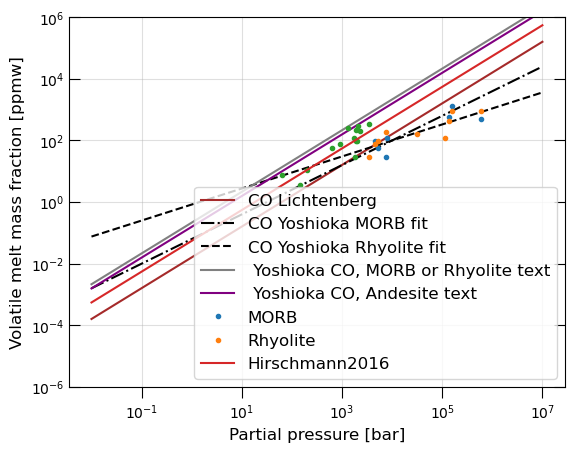

In [111]:
# CO solubility
def XCOYoshioka(fCO, phase='MORB'): # returns in wt%
    if phase=='MORB':
        return 10**(-5.20 + 0.80*np.log10(fCO))
    else:
        return 10**(-4.08 + 0.52*np.log10(fCO))

# Yoshioka data
XCOMORB = 1e-2*np.array([0.0097, 0.0059, 0.012, 0.0028, -0.0007, 0.0577, 0.1339, 0.0513])
# XCOMORBerror = 1e-2*np.array([0.0024, 0.0026, 0.015, 0.0094, 0.00060, 0.0220, 0.0205, 0.0105])
pCOMORB = 10**np.array([3.66, 3.72, 3.90, 3.87, 4.50, 5.13, 5.20, 5.77]) 

XCORhyolite = 1e-2*np.array([0.0075, 0.0028, 0.0095, -0.0042, 0.0188, 0.0161, 0.0121, 0.0437, 0.0911, 0.0918])
pCORhyolite = 10**np.array([3.66, 3.54, 3.72, 3.90, 3.87, 4.50, 5.05, 5.13, 5.20, 5.77]) 

plt.figure()
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaCO, betaCO), '-', color='brown', label='CO Lichtenberg')
plt.loglog(psurflog, 1e6/1e2*XCOYoshioka(psurflog, phase='MORB'), '-.', color='k', label='CO Yoshioka MORB fit')
plt.loglog(psurflog, 1e6/1e2*XCOYoshioka(psurflog, phase='Rhyolite'), '--', color='k', label='CO Yoshioka Rhyolite fit')
plt.loglog(psurflog, 2.15*psurflog*0.1, '-', color='grey', label=' Yoshioka CO, MORB or Rhyolite text')
plt.loglog(psurflog, 1.57*psurflog*0.1, '-', color='purple', label=' Yoshioka CO, Andesite text')
plt.loglog(pCOMORB, 1e6*XCOMORB, '.', label='MORB')
plt.loglog(pCORhyolite, 1e6*XCORhyolite, '.', label='Rhyolite')
# plt.loglog(psurflog, 10**(-7.2+6)*(1e-5)**0.8*(psurflog*1e5)**0.8, label='test')
# plt.loglog(psurflog, 10**(-4.08-2+6)*(1e-5)**0.52*(psurflog*1e5)**0.52, label='test')
# plt.loglog(psurflog, XiLichtenberg(psurflog, 10**(-4.08-2+6)*(1e-5)**0.52, 1/0.52), label='test')

# print(alphaCO)
# print(10**(-4.08-2+6)*(1e-5)**0.52)

# Armstrong2015 data
XC = 44/12*np.array([92, 57, 0, 83, 26, 60, 26, 8, 34, 69, 21, 16, 0, 3, 1, 2]) # ppmw C+O2
fCO = 10**np.array([3.54, 3.35, 3.32, 3.31, 3.29, 3.27, 3.27, 3.25, 3.24, 3.12, 2.97, 2.80, 2.71, 2.30, 2.16, 1.80]) # bar

plt.loglog(fCO, XC,'.')

def Hirschmann2016CO(pCObar): # Table 2. "Reduced"
    pCOMPa = pCObar/10 # 1 bar = 0.1 MPa
    XCOppm = 0.55*pCOMPa
    return XCOppm 

plt.loglog(psurflog, Hirschmann2016CO(psurflog),'-', label='Hirschmann2016')


plt.legend()
plt.grid(alpha=0.4)

plt.gca().set_ylim(top=1e6, bottom=1e-6)
plt.xlabel('Partial pressure [bar]')
plt.ylabel('Volatile melt mass fraction [ppmw]')


Text(0, 0.5, 'Volatile melt mass fraction [ppmw]')

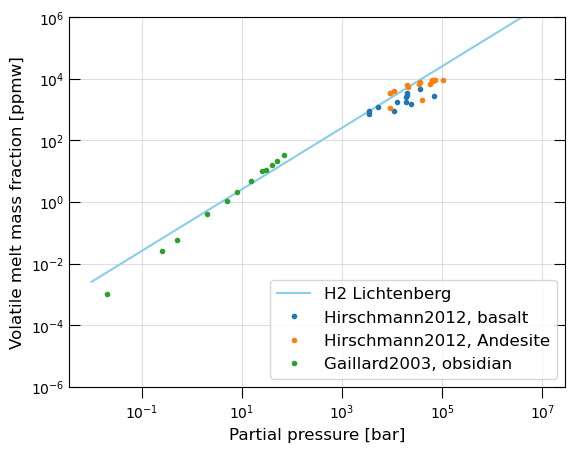

In [112]:
# H2 solubility
plt.figure()
plt.loglog(psurflog, XiLichtenberg(psurflog, alphaH2, betaH2), '-', color='skyblue', label='H2 Lichtenberg')

# Hirschmann2012 data
XH2Basalt = 1e6/1e2*np.array([0.12, 0.36, 0.30, 0.18, 0.26, 0.46, 0.07, 0.09, 0.18, 0.15, 0.28, 0.09]) # wt% to ppmw
fH2Basalt = np.array([5319, 19557, 19557, 19058, 19058, 36491, 3492, 3492, 12533, 23338, 68163, 11148]) # bar

XH2Andesite = 1e6/1e2*np.array([0.35, 0.11, 0.34, 0.64, 0.80, 0.20, 0.86, 0.86, 0.87, 0.90, 0.93, 0.90, 0.90, 0.40, 0.56, 0.66, 0.67]) # wt% to ppmw
fH2Andesite = np.array([9285, 9285, 9285, 19562, 36478, 39066, 63206, 63206, 63206, 63206, 67129, 72269, 104109, 11115, 20365, 34867, 56987]) # bar

plt.loglog(fH2Basalt, XH2Basalt, '.', label='Hirschmann2012, basalt')
plt.loglog(fH2Andesite, XH2Andesite, '.', label='Hirschmann2012, Andesite')

# Gaillard2003 data 
fH2Gaillard = np.array([0.02, 0.25, 0.50, 2, 5, 8, 15, 25, 30, 40, 70, 50]) # bar
XH2Gaillard = np.array([0.001, 0.025, 0.06, 0.4, 1.1, 2.1, 4.7, 9.9, 11.3, 16.3, 33.4, 21.7]) # ppmw
plt.loglog(fH2Gaillard, XH2Gaillard, '.', label='Gaillard2003, obsidian')

plt.legend()
plt.grid(alpha=0.4)

plt.gca().set_ylim(top=1e6, bottom=1e-6)
plt.xlabel('Partial pressure [bar]')
plt.ylabel('Volatile melt mass fraction [ppmw]')

In [113]:
# Copy into interactive window to check if we dissolve accurately
def XiLichtenberg(psurfbar, alpha, beta):
    psurfPa = psurfbar*1e5 # convert from bar to Pa
    return alpha*psurfPa**(1/beta)
    
differentCO2, differentnitrogen, differentCO = True, True, True

alphaioxi = np.array([1.033e0, 1.937e-9, 7.416e1]) # Lichtenberg2021, Table1, dissolution coefficients
betaioxi = np.array([1.747, 0.714, 4.582]) # Lichtenberg2021, Table1, stoichiometry exponent

if differentCO2:
    alphaioxi[1] = 4.4e-12*1e6 # Anatomy2 eq. 11
    betaioxi[1] = 1
if differentnitrogen:
    alphaioxi[2] = 6.11e-13*1e6 # Sossi2020 and Anatomy2 eq. 12. [ppmw/Pa]
    betaioxi[2] = 1

alphaired = np.array([2.572e-6, 1.600e-7, 0]) # fictive third element since nitrogen lacks a reduced species
betaired = np.array([1.000, 1.000, 1.000]) # -||-

alphaired[:2] *= amui[:2]/amuiextra # mass normalization of reduced species. Count reduced species mass as if they were normalized

if differentCO: # eq. 6 or 7 in Yoshioka2018
        # Alternative 1: Rhyolite
        # alphaired[1] = 44/28*10**(-4.08-2+6)*(1e-5)**0.52 # Rhyolite fit. [ppmw/Pa] essentially
        # betaired[1] = 1/0.52 # Rhyolite fit

        # Alternative 2: MORB
        # alphaired[1] = 44/28*10**(-5.2-2+6)*(1e-5)**0.80 # MORB fit
        # betaired[1] = 1/0.8

        # Alternative 3: Hirschmann2016 
        alphaired[1] = 44/28*0.55/1e6 # convert to equiv. CO2 and to Pa from MPa. 
        betaired[1] = 1 # Henrian

alphafull, betafull = np.concatenate((alphaioxi, alphaired[:-1])), np.concatenate((betaioxi, betaired[:-1]))

# COPY LINES BELOW INTO INTERACTIVE WINDOW
# XiLicht = XiLichtenberg(piatm0*GPatobar, alphafull, betafull)
# print(XiLicht)
# print(Xi0*1e6)

Text(0, 0.5, 'Volatile melt mass fraction [ppmw]')

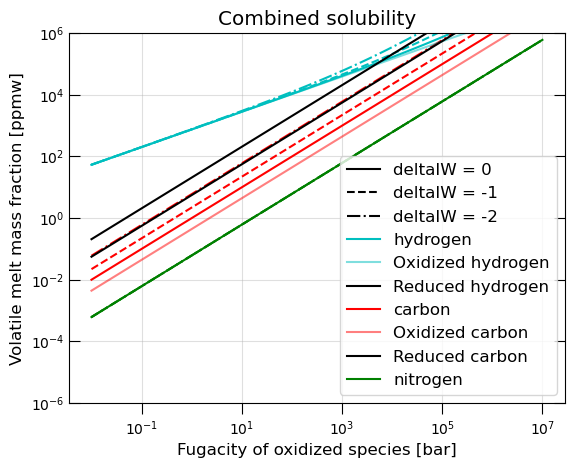

In [114]:
# Combined dissolution of volatiles as function of deltaIW

plt.figure()
plt.title('Combined solubility')

for j in range(3):
    deltaIW = -j
    fO2surf = fO2func(psurf, Tsurf, deltaIW)
    gasgassol = gasgasfunc(np.ones(3), np.ones(2), amuifull, fO2surf, Tsurf, splitbool=False) # speciate an arbitrary atmosphere
    xifulltest = gasgassol[1] # not normalized

    redmolefactor = xifulltest[3:]/xifulltest[:2] # normalized

    for i in irange:
        plt.loglog(psurflog, XiLichtenberg(psurflog, alphaioxi[i], betaioxi[i])+XiLichtenberg(psurflog*np.append(redmolefactor,0)[i], alphaired[i], betaired[i]), linestyle=['-','--','-.'][j], color=vcolors[i])
    plt.loglog(1,1,color='k', linestyle=['-','--','-.'][j], label='deltaIW = '+str(deltaIW))
for i in irange:
    plt.loglog(1,1,color=vcolors[i], label=volatiles[i])
    if i != 2:
        plt.loglog(psurflog, XiLichtenberg(psurflog, alphaioxi[i], betaioxi[i]), label='Oxidized '+volatiles[i], color=vcolors[i], alpha=0.5)
        plt.loglog(psurflog, XiLichtenberg(psurflog*redmolefactor[i], alphaired[i], betaired[i]), label='Reduced '+volatiles[i], color='k', alpha=1)


plt.legend()
plt.grid(alpha=0.4)

plt.gca().set_ylim(top=1e6, bottom=1e-6)
plt.xlabel('Fugacity of oxidized species [bar]')
plt.ylabel('Volatile melt mass fraction [ppmw]')

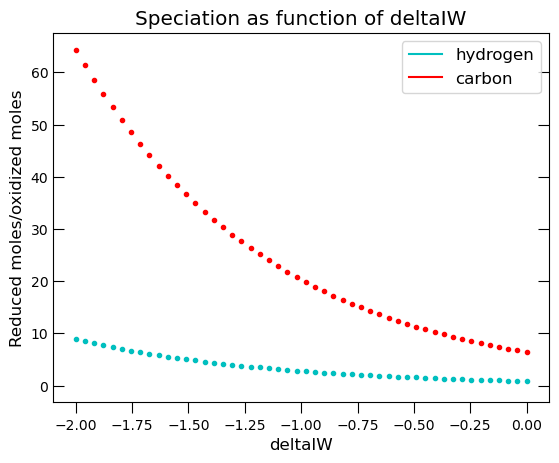

In [115]:
plt.figure()
plt.title('Speciation as function of deltaIW')

deltaIWlin = np.linspace(-2, 0)
for deltaIW in deltaIWlin:
    fO2surf = fO2func(psurf, Tsurf, deltaIW)
    gasgassol = gasgasfunc(np.ones(3), np.ones(2), amuifull, fO2surf, Tsurf, splitbool=False) # speciate an arbitrary atmosphere
    xifulltest = gasgassol[1] # not normalized

    redmolefactor = xifulltest[3:]/xifulltest[:2] # normalized
    plt.plot(deltaIW, redmolefactor[0], '.', color=vcolors[0])
    plt.plot(deltaIW, redmolefactor[1], '.', color=vcolors[1])
for i in range(2):
    plt.plot(0, 0, markersize=0, color=vcolors[i], label=volatiles[i])
plt.xlabel('deltaIW')
plt.ylabel('Reduced moles/oxidized moles')
plt.legend()



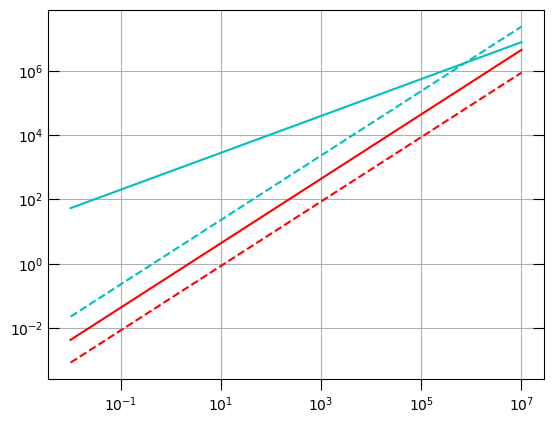

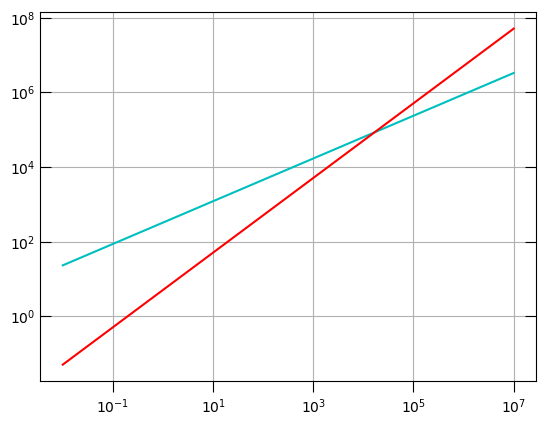

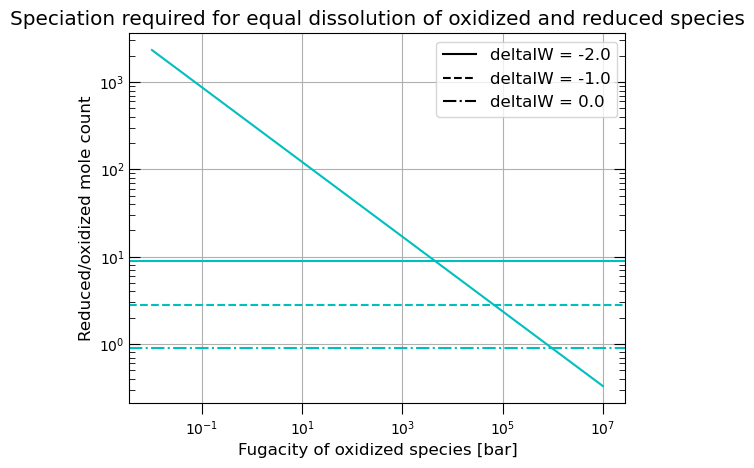

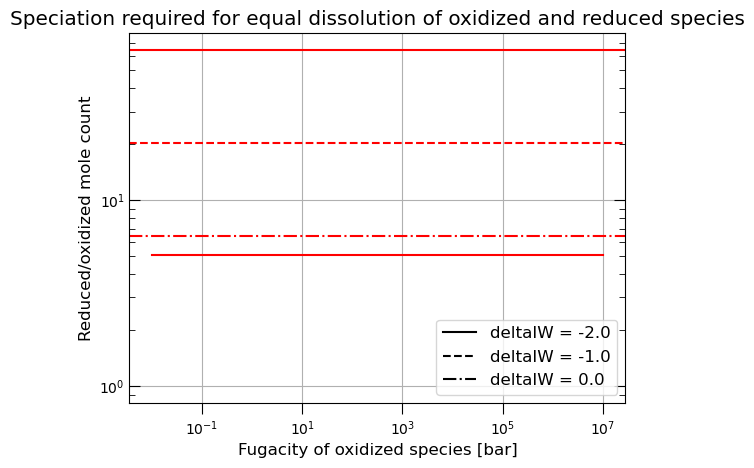

In [116]:
def log_interp(x, xp, yp):
    logx = np.log10(x)
    logxp = np.log10(xp)
    logyp = np.log10(yp)
    return 10**np.interp(logx, logxp, logyp)


Xioxi = np.array([XiLichtenberg(psurflog, alphaioxi[i], betaioxi[i]) for i in range(2)])
Xired = np.array([XiLichtenberg(psurflog, alphaired[i], betaired[i]) for i in range(2)])

plt.figure()
for i in range(2):
    plt.loglog(psurflog, Xioxi[i], '-', color=vcolors[i])
    plt.loglog(psurflog, Xired[i],'--', color=vcolors[i])
plt.grid()

# At what reduced fugacity is the dissolution of oxidized and reduced species equal?
fred_equal = GPatobar*1e-9*np.array([(Xioxi[i]/alphaired[i])**betaired[i] for i in range(2)]) # convert from Pa to bar

plt.figure()
for i in range(2):
    plt.loglog(psurflog, fred_equal[i], color=vcolors[i])
plt.grid()

redmolefactorlist = np.array([fred_equal[i]/psurflog for i in range(2)])
for i in range(2):
    plt.figure()
    plt.loglog(psurflog, redmolefactorlist[i], color=vcolors[i])

    deltaIWlin = np.array([-2., -1., 0.])
    redmolefactorIW = np.zeros((2, len(deltaIWlin)))
    j=0
    for deltaIW in deltaIWlin:
        fO2surf = fO2func(psurf, Tsurf, deltaIW)
        gasgassol = gasgasfunc(np.ones(3), np.ones(2), amuifull, fO2surf, Tsurf, splitbool=False) # speciate an arbitrary atmosphere
        xifulltest = gasgassol[1] # not normalized

        redmolefactor = xifulltest[3:]/xifulltest[:2] # normalized    
        plt.axhline(redmolefactor[i], linestyle=['-','--','-.'][j], color=vcolors[i])
        plt.loglog(1,1,linestyle=['-','--','-.'][j],color='k', label='deltaIW = '+str(deltaIW))
        j+=1
    plt.grid()
    plt.title('Speciation required for equal dissolution of oxidized and reduced species')
    plt.xlabel('Fugacity of oxidized species [bar]')
    plt.ylabel('Reduced/oxidized mole count')
    plt.legend()


In [117]:
XFeOfin = 0.059 # mole fraction. Current day. Badro2015, figure text of fig. 1. Needed for PNfuncGrewal
XO = 0.05 # 8wt% from Fischer2020 upper limit of core currently. ~5wt% seems like a good guess from Badro2015 fig. 1.
XS = 0
XNi = 0.15 # P

def deltaIWmassfunc(protomass, XFeO0=0.17): # simple deltaIW trajectories from Badro2015. 17 mol% FeO corresponds to track 9. Least steep track that still satisfies geochemistry for Si and O in the core. 
        XFeO = XFeO0+(XFeOfin-XFeO0)*protomass/(stoppingmass*earthmass)
        return 2*np.log10(XFeO/(1-XNi)) # Some Ni in the metal, the rest is Fe. 



In [118]:
# reservoir fractions
print('ficore:', ficoreinterp[:,-1])
print('fimagma', fimagmainterp[:,-1])
print('fiatm', fiatminterp[:,-1])
print('')

# Pg to kg conversion
print('Miatmequiv:', Miatmequivsumtimearray[:,-1]*1e12, ' kg')
print('Miatmsum:', Miatmsumtimearray[:,-1]*1e12, ' kg')
print('Mimagma:', Mimagma[-1]*1e12, ' kg')
print('Miatmsum+Mimagma:', 1e12*(Miatmsumtimearray[:,-1]+Mimagma[-1]), ' kg')
print('Miatmequiv+Mimagma:', 1e12*(Miatmequivsumtimearray[:,-1]+Mimagma[-1]), ' kg')
print('')

# bar 
print('pi:', pi_evo[:,-1], ' bar')
print('')

# Xicore
print('Xicore', Xicoretimearray[:,-1]*1e6, ' ppm')
print('')

# BSE mass fractions
Ximagmaavg = np.sum(Mvolfromfile[-1], axis=1)/np.sum(Mtotfromfile[-1])
print('Ximagma: ', np.array([1, 12/44, 1])*Ximagmaavg*1e6,' ppm')
print('Xiatm+magma: ', np.array([1, 12/44, 1])*Xiatmplusmantle[:,-1]*1e6, ' ppm')
print('')

print('Ximagma*protomass:', np.array([1, 12/44, 1])*Ximagmaavg*1e6*protomasstimearray[-1]/earthmass, ' ppm')
print('Xiatm*protomass:', np.array([1, 12/44, 1])*Miatmequivsumtimearray[:,-1]/np.sum(Mtotfromfile[-1])*1e6*protomasstimearray[-1]/earthmass, ' ppm')
print('Hirschmann2018 BSE:', [710, 140, 2.8], ' ppm')
print('(Xiatm+magma)*protomass:', np.array([1, 12/44, 1])*Xiatmplusmantle[:,-1]*1e6*protomasstimearray[-1]/earthmass, ' ppm')


ficore: [0.69680375 0.49505474 0.05376979]
fimagma [0.28879108 0.00608891 0.01341982]
fiatm [0.01440516 0.49885635 0.93281038]

Miatmequiv: [1.73460263e+20 1.03657016e+22 1.67000952e+19]  kg
Miatmsum: [4.54108161e+19 6.69999442e+21 1.67000952e+19]  kg
Mimagma: [3.47748764e+21 1.26520976e+20 2.40254990e+17]  kg
Miatmsum+Mimagma: [3.52289846e+21 6.82651539e+21 1.69403501e+19]  kg
Miatmequiv+Mimagma: [3.65094790e+21 1.04922226e+22 1.69403501e+19]  kg

pi: [   8.07268676   32.00938634    2.94737723   39.54872932 1132.17249856]  bar

Xicore [7.28892515e+03 8.93609161e+03 8.36248091e-01]  ppm

Ximagma:  [1.32185096e+03 1.31161991e+01 9.13249221e-02]  ppm
Xiatm+magma:  [1391.39202652 1095.96491679    6.44400061]  ppm

Ximagma*protomass: [8.45837812e+02 8.39291076e+00 5.84378079e-02]  ppm
Xiatm*protomass: [ 42.19116344 687.62043384   4.06200493]  ppm
Hirschmann2018 BSE: [710, 140, 2.8]  ppm
(Xiatm+magma)*protomass: [890.33637384 701.29583271   4.12344475]  ppm
